In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
import tensorflow as tf

In [3]:
#unseen validation data
data = pd.read_csv("traj_data_v2_validation.csv")
data.describe()

,Unnamed: 0,Vehicle_ID,X,Y,X_REL,Y_REL
count,300000.000000,300000.000000,300000.000000,300000.000000,3.000000e+05,3.000000e+05
mean,149999.500000,149975.000000,151.188246,-33.894559,-5.550338e-07,-4.796188e-07
std,86602.684716,86602.683514,0.002013,0.001323,1.358794e-05,8.747005e-06
min,0.000000,0.000000,151.184856,-33.896419,-5.215619e-05,-3.939190e-05
25%,74999.750000,74987.500000,151.187367,-33.895328,-5.693877e-06,-4.843689e-06
50%,149999.500000,149975.000000,151.187602,-33.894768,0.000000e+00,0.000000e+00
75%,224999.250000,224962.500000,151.188670,-33.894289,4.760093e-06,3.766334e-06
max,299999.000000,299950.000000,151.194422,-33.889777,5.269389e-05,4.025902e-05


In [14]:
"""
Preprocess data, removed torch tensors return type, now np arrays
"""
def preprocess_dataset(data, max = 10, max_len = 40, input_len = 30):
    scaler = MinMaxScaler(feature_range=(0, max))
    data[['X_REL', 'Y_REL']] = scaler.fit_transform(data[['X_REL', 'Y_REL']])
    global map_dict
    map_dict = {}
    unique_peds = data['Vehicle_ID'].unique()
    unique_peds = sorted(unique_peds)
    inputs = []
    indexes = []
    outputs = []
    seq = []
    for ped in unique_peds:
        if (len(data[data['Vehicle_ID'] == ped]) >= max_len):
          indexes.append(ped)
          seq_inner = []
          target_inner = 0
          i = 0
          for indx, row in data[data['Vehicle_ID'] == ped].iterrows():
            x = round(row['X_REL'])
            y = round(row['Y_REL'])
            ## Cantor pairing function:
            bin = y * max + x
            #print("X: ", x, " Y: ", y, " Bin: ", bin)
            map_dict[int(bin)] = [int(x), int(y)]
            i += 1
            if i == max_len:
              break
            seq_inner.append(int(bin))
          inputs.append([seq_inner[0:input_len]])
          outputs.append([seq_inner[input_len + 1:]])
    train_inputs, test_inputs, train_targets, test_targets, train_indx, test_indx = train_test_split(inputs, outputs, indexes, train_size=0.7, random_state=0)
    
    return np.array(train_inputs), np.array(test_inputs), np.array(train_targets), np.array(test_targets), train_indx, test_indx

In [15]:
train_data_inputs, test_data_inputs, train_data_targets, test_data_targets, train_indx, test_indx = preprocess_dataset(data, max = 100, max_len = 50, input_len = 20)

In [17]:
test_data_targets.shape

(1800, 1, 28)

In [18]:
print(train_data_inputs.shape)
print(train_data_targets.shape)
train_data_inputs = train_data_inputs.reshape(train_data_inputs.shape[0], train_data_inputs.shape[2], 1)
train_data_targets = train_data_targets.reshape(train_data_targets.shape[0], train_data_targets.shape[2], 1)
print(train_data_inputs.shape)
print(train_data_targets.shape)

print(test_data_inputs.shape)
print(test_data_targets.shape)
test_data_inputs = test_data_inputs.reshape(test_data_inputs.shape[0], test_data_inputs.shape[2], 1)
test_data_targets = test_data_targets.reshape(test_data_targets.shape[0], test_data_targets.shape[2], 1)
print(test_data_inputs.shape)
print(test_data_targets.shape)

(4200, 1, 20)
(4200, 1, 28)
(4200, 20, 1)
(4200, 28, 1)
(1800, 1, 20)
(1800, 1, 28)
(1800, 20, 1)
(1800, 28, 1)


In [21]:
model = keras.models.load_model('newencoder_decoder.h5')

In [117]:
input_len = 20
target_len = 28
def get_predictions(model, data_source_inputs, data_source_targets):

    predictions = []
    ground_truths = []
    inputs = []
    for i in range(0, data_source_inputs.shape[0], 1):
        data = data_source_inputs[i,:,:]
        res = model.predict(data_source_inputs[i:i+1])
        ground_truths.append(data_source_targets[i].squeeze().tolist())
        predictions.append((tf.argmax(res[0,:,:], axis=1)).numpy().tolist())
        inputs.append(data.squeeze().tolist())
            
    return inputs, ground_truths, predictions

In [118]:
inputs_list, target_list, preds_list = get_predictions(model, test_data_inputs, test_data_targets)

In [120]:
inputs_list

[[4950,
  4949,
  4948,
  4948,
  4947,
  4846,
  4846,
  4845,
  4844,
  4743,
  4743,
  4742,
  4641,
  4740,
  4640,
  4639,
  4638,
  4538,
  4537,
  4536],
 [4950,
  5050,
  5150,
  5249,
  5349,
  5449,
  5548,
  5648,
  5748,
  5848,
  5848,
  5947,
  6047,
  6147,
  6247,
  6346,
  6446,
  6546,
  6646,
  6745],
 [4950,
  5050,
  5049,
  5149,
  5149,
  5249,
  5249,
  5349,
  5348,
  5448,
  5448,
  5548,
  5548,
  5548,
  5647,
  5647,
  5747,
  5747,
  5747,
  5847],
 [4950,
  4949,
  4949,
  4948,
  4948,
  4847,
  4847,
  4846,
  4846,
  4845,
  4745,
  4744,
  4744,
  4743,
  4743,
  4642,
  4642,
  4641,
  4641,
  4640],
 [4950,
  4950,
  4950,
  4950,
  4950,
  4950,
  4950,
  4950,
  4950,
  4950,
  4950,
  4950,
  4950,
  4950,
  4950,
  4950,
  4950,
  4950,
  4950,
  4950],
 [4950,
  4949,
  4948,
  4948,
  4947,
  4946,
  4846,
  4845,
  4844,
  4843,
  4743,
  4742,
  4741,
  4741,
  4740,
  4739,
  4739,
  4638,
  4637,
  4637],
 [4950,
  4950,
  4850,
  4950,
  

In [121]:
import math
def calculate_eucledian_mse(targets, preds):
  err = 0
  for indx in range(0, len(targets)):
    x_target = targets[indx] % 100
    y_target = targets[indx] / 100

    x_preds = preds[indx] % 100
    y_preds = preds[indx] / 100

    dist = math.hypot(x_target - x_preds, y_target - y_preds)
    err += dist
  return (err / len(targets))

In [122]:
calculate_eucledian_mse(target_list, preds_list)

TypeError: unsupported operand type(s) for %: 'list' and 'int'

In [129]:
import numpy as np
import matplotlib.pyplot as plt

def vis_trajectory_scatter(input_list, target_list, preds_list, lag_time = 1.0):
  
  for i in range(0, 100, 1):
    print(i)
    plt.figure(figsize=(10,10))
    inputs = input_list[i]
    targets = target_list[i]
    preds = preds_list[i]

    xy_inputs = []
    xy_preds = []
    xy_target = []

    
    for inp in inputs:
      x = inp % 100
      y = inp / 100 
      xy_inputs.append([x, y])
    
    for inp in preds:
      x = inp % 100
      y = inp / 100 
      xy_preds.append([x, y])

    for inp in targets:
      x = inp % 100
      y = inp / 100 
      xy_target.append([x, y])

    x_inp, y_inp = zip(*xy_inputs)
    x_tar, y_tar = zip(*xy_target)
    x_pred, y_pred = zip(*xy_preds)

    plt.scatter(x_inp,y_inp)
    plt.scatter(x_tar,y_tar, color='r')
    plt.scatter(x_pred,y_pred, color='g')

    plt.xlim(0, 100)
    plt.ylim(0, 100)

    plt.show()
    print("Input: ", xy_inputs)
    print("Preds: ", xy_preds)
    print("Truth: ", xy_target)


0


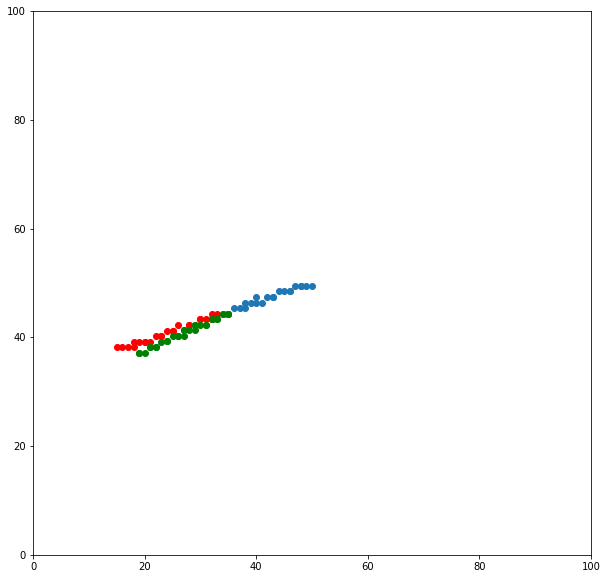

Input:  [[50, 49.5], [49, 49.49], [48, 49.48], [48, 49.48], [47, 49.47], [46, 48.46], [46, 48.46], [45, 48.45], [44, 48.44], [43, 47.43], [43, 47.43], [42, 47.42], [41, 46.41], [40, 47.4], [40, 46.4], [39, 46.39], [38, 46.38], [38, 45.38], [37, 45.37], [36, 45.36]]
Preds:  [[35, 44.35], [35, 44.35], [34, 44.34], [33, 43.33], [33, 43.33], [32, 43.32], [32, 43.32], [31, 42.31], [31, 42.31], [30, 42.3], [29, 42.29], [29, 41.29], [28, 41.28], [27, 41.27], [27, 40.27], [26, 40.26], [26, 40.26], [25, 40.25], [24, 39.24], [24, 39.24], [23, 39.23], [22, 38.22], [22, 38.22], [21, 38.21], [21, 38.21], [20, 37.2], [19, 37.19], [19, 37.19]]
Truth:  [[35, 44.35], [34, 44.34], [33, 44.33], [32, 44.32], [32, 43.32], [31, 43.31], [30, 43.3], [30, 43.3], [29, 42.29], [28, 42.28], [28, 42.28], [27, 41.27], [26, 42.26], [25, 41.25], [25, 41.25], [24, 41.24], [23, 40.23], [23, 40.23], [22, 40.22], [21, 39.21], [20, 39.2], [20, 39.2], [19, 39.19], [18, 39.18], [18, 38.18], [17, 38.17], [16, 38.16], [15, 38

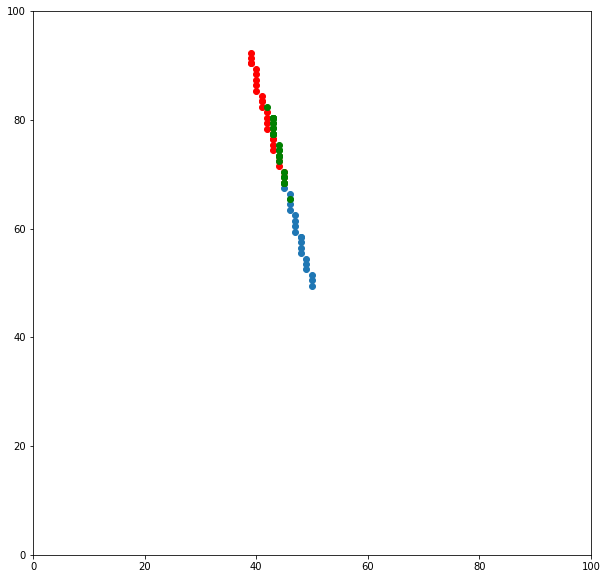

Input:  [[50, 49.5], [50, 50.5], [50, 51.5], [49, 52.49], [49, 53.49], [49, 54.49], [48, 55.48], [48, 56.48], [48, 57.48], [48, 58.48], [48, 58.48], [47, 59.47], [47, 60.47], [47, 61.47], [47, 62.47], [46, 63.46], [46, 64.46], [46, 65.46], [46, 66.46], [45, 67.45]]
Preds:  [[46, 65.46], [45, 68.45], [45, 68.45], [45, 68.45], [45, 69.45], [45, 69.45], [45, 70.45], [44, 72.44], [44, 73.44], [44, 73.44], [44, 73.44], [44, 74.44], [44, 74.44], [43, 77.43], [44, 75.44], [43, 77.43], [43, 77.43], [43, 77.43], [43, 78.43], [43, 78.43], [43, 79.43], [43, 79.43], [43, 80.43], [43, 80.43], [43, 80.43], [43, 80.43], [43, 80.43], [42, 82.42]]
Truth:  [[45, 68.45], [45, 69.45], [45, 70.45], [44, 71.44], [44, 72.44], [44, 73.44], [43, 74.43], [43, 75.43], [43, 76.43], [43, 76.43], [43, 77.43], [42, 78.42], [42, 79.42], [42, 80.42], [42, 81.42], [41, 82.41], [41, 83.41], [41, 83.41], [41, 84.41], [40, 85.4], [40, 86.4], [40, 87.4], [40, 88.4], [40, 89.4], [39, 90.39], [39, 90.39], [39, 91.39], [39, 9

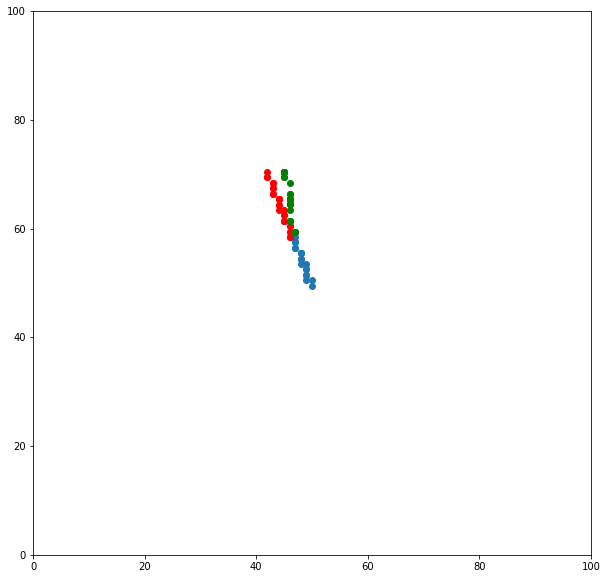

Input:  [[50, 49.5], [50, 50.5], [49, 50.49], [49, 51.49], [49, 51.49], [49, 52.49], [49, 52.49], [49, 53.49], [48, 53.48], [48, 54.48], [48, 54.48], [48, 55.48], [48, 55.48], [48, 55.48], [47, 56.47], [47, 56.47], [47, 57.47], [47, 57.47], [47, 57.47], [47, 58.47]]
Preds:  [[47, 59.47], [47, 59.47], [47, 59.47], [46, 61.46], [46, 61.46], [46, 61.46], [46, 63.46], [46, 64.46], [46, 64.46], [46, 64.46], [46, 64.46], [46, 64.46], [46, 65.46], [46, 65.46], [46, 65.46], [46, 65.46], [46, 65.46], [46, 66.46], [46, 66.46], [46, 68.46], [45, 69.45], [45, 69.45], [45, 70.45], [45, 70.45], [45, 70.45], [45, 70.45], [45, 70.45], [45, 70.45]]
Truth:  [[46, 58.46], [46, 58.46], [46, 59.46], [46, 59.46], [46, 60.46], [46, 60.46], [45, 61.45], [45, 61.45], [45, 61.45], [45, 62.45], [45, 62.45], [45, 63.45], [44, 63.44], [44, 64.44], [44, 64.44], [44, 65.44], [44, 65.44], [44, 65.44], [44, 65.44], [43, 66.43], [43, 66.43], [43, 67.43], [43, 67.43], [43, 68.43], [43, 68.43], [42, 69.42], [42, 69.42], 

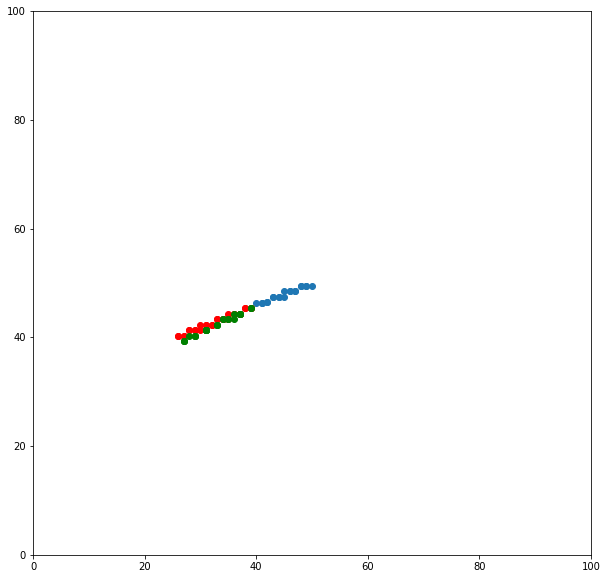

Input:  [[50, 49.5], [49, 49.49], [49, 49.49], [48, 49.48], [48, 49.48], [47, 48.47], [47, 48.47], [46, 48.46], [46, 48.46], [45, 48.45], [45, 47.45], [44, 47.44], [44, 47.44], [43, 47.43], [43, 47.43], [42, 46.42], [42, 46.42], [41, 46.41], [41, 46.41], [40, 46.4]]
Preds:  [[39, 45.39], [39, 45.39], [37, 44.37], [37, 44.37], [37, 44.37], [37, 44.37], [36, 44.36], [36, 43.36], [35, 43.35], [35, 43.35], [34, 43.34], [34, 43.34], [33, 42.33], [33, 42.33], [33, 42.33], [31, 41.31], [31, 41.31], [31, 41.31], [31, 41.31], [31, 41.31], [31, 41.31], [29, 40.29], [29, 40.29], [29, 40.29], [28, 40.28], [27, 39.27], [27, 39.27], [27, 39.27]]
Truth:  [[39, 45.39], [39, 45.39], [38, 45.38], [38, 45.38], [37, 44.37], [37, 44.37], [36, 44.36], [36, 44.36], [35, 44.35], [35, 43.35], [34, 43.34], [34, 43.34], [33, 43.33], [33, 43.33], [32, 42.32], [32, 42.32], [31, 42.31], [31, 42.31], [30, 42.3], [30, 41.3], [29, 41.29], [29, 41.29], [28, 41.28], [28, 41.28], [27, 40.27], [27, 40.27], [26, 40.26], [2

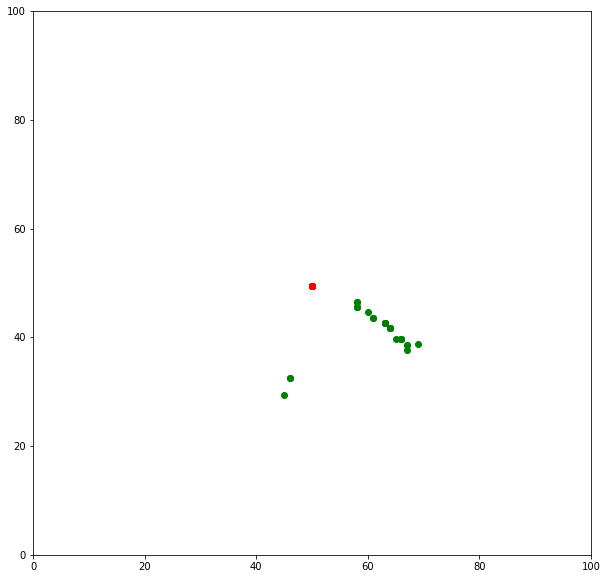

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
Preds:  [[58, 46.58], [58, 46.58], [58, 45.58], [58, 45.58], [58, 45.58], [46, 32.46], [46, 32.46], [60, 44.6], [61, 43.61], [61, 43.61], [45, 29.45], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [64, 41.64], [64, 41.64], [64, 41.64], [64, 41.64], [65, 39.65], [66, 39.66], [66, 39.66], [66, 39.66], [67, 38.67], [67, 38.67], [67, 37.67], [69, 38.69]]
Truth:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
5


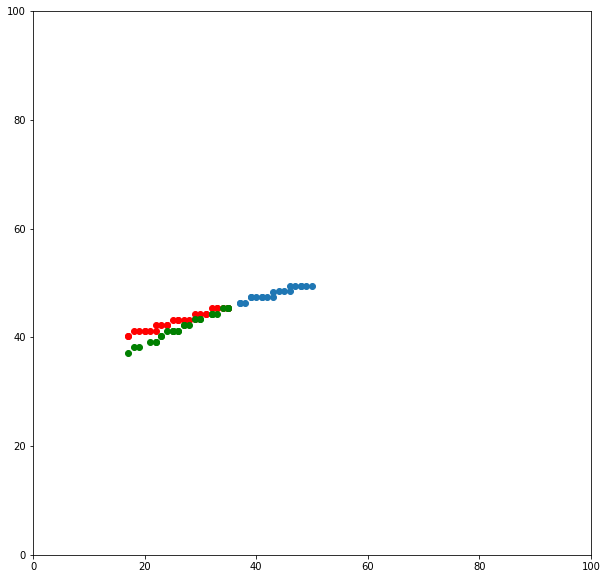

Input:  [[50, 49.5], [49, 49.49], [48, 49.48], [48, 49.48], [47, 49.47], [46, 49.46], [46, 48.46], [45, 48.45], [44, 48.44], [43, 48.43], [43, 47.43], [42, 47.42], [41, 47.41], [41, 47.41], [40, 47.4], [39, 47.39], [39, 47.39], [38, 46.38], [37, 46.37], [37, 46.37]]
Preds:  [[35, 45.35], [35, 45.35], [35, 45.35], [34, 45.34], [33, 44.33], [32, 44.32], [32, 44.32], [32, 44.32], [30, 43.3], [30, 43.3], [29, 43.29], [28, 42.28], [27, 42.27], [27, 42.27], [26, 41.26], [26, 41.26], [25, 41.25], [25, 41.25], [25, 41.25], [24, 41.24], [23, 40.23], [23, 40.23], [22, 39.22], [22, 39.22], [21, 39.21], [19, 38.19], [18, 38.18], [17, 37.17]]
Truth:  [[35, 45.35], [35, 45.35], [34, 45.34], [33, 45.33], [33, 45.33], [32, 45.32], [31, 44.31], [31, 44.31], [30, 44.3], [29, 44.29], [29, 43.29], [28, 43.28], [27, 43.27], [26, 43.26], [26, 43.26], [25, 43.25], [24, 42.24], [24, 42.24], [23, 42.23], [22, 42.22], [22, 41.22], [21, 41.21], [20, 41.2], [20, 41.2], [19, 41.19], [18, 41.18], [17, 40.17], [17, 

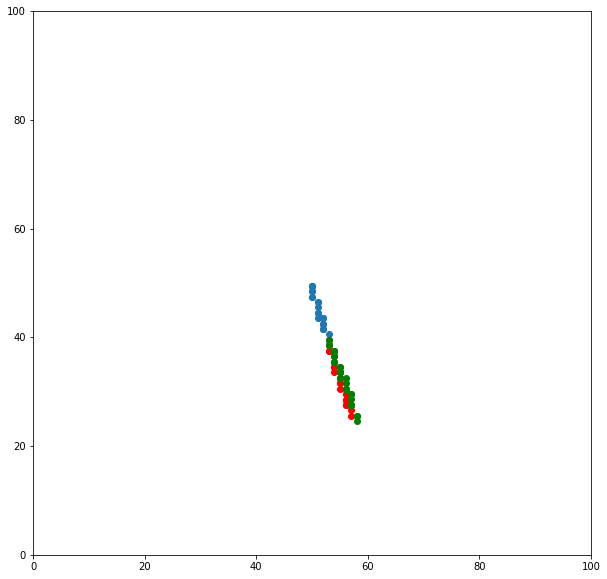

Input:  [[50, 49.5], [50, 49.5], [50, 48.5], [50, 49.5], [50, 48.5], [50, 47.5], [50, 47.5], [51, 46.51], [51, 46.51], [51, 45.51], [51, 44.51], [51, 44.51], [52, 43.52], [51, 43.51], [52, 43.52], [52, 42.52], [52, 42.52], [52, 41.52], [52, 41.52], [53, 40.53]]
Preds:  [[53, 39.53], [53, 38.53], [54, 37.54], [54, 37.54], [54, 37.54], [54, 36.54], [54, 35.54], [54, 35.54], [55, 34.55], [55, 34.55], [55, 33.55], [55, 33.55], [55, 32.55], [56, 32.56], [56, 31.56], [56, 30.56], [56, 30.56], [56, 30.56], [57, 29.57], [57, 29.57], [57, 28.57], [57, 27.57], [57, 27.57], [57, 27.57], [57, 27.57], [58, 25.58], [58, 25.58], [58, 24.58]]
Truth:  [[53, 39.53], [53, 38.53], [53, 38.53], [53, 38.53], [53, 37.53], [53, 37.53], [54, 36.54], [54, 36.54], [54, 35.54], [54, 34.54], [54, 34.54], [55, 33.55], [54, 33.54], [55, 33.55], [55, 32.55], [55, 32.55], [55, 31.55], [55, 31.55], [55, 30.55], [56, 29.56], [56, 29.56], [56, 28.56], [56, 28.56], [56, 28.56], [56, 27.56], [56, 27.56], [57, 26.57], [57, 

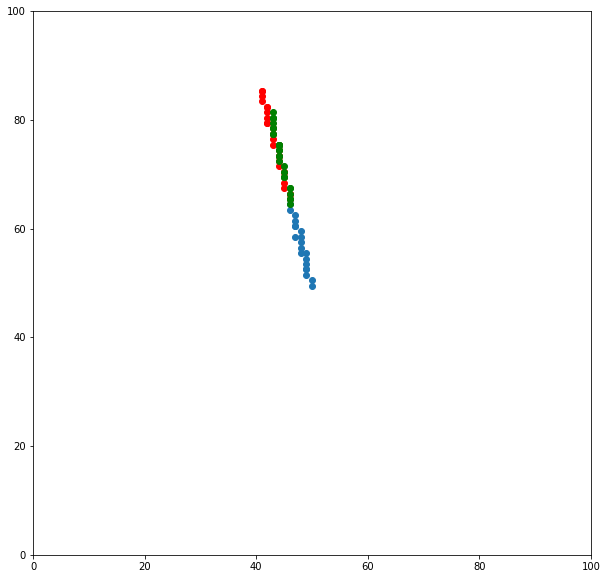

Input:  [[50, 49.5], [50, 50.5], [49, 51.49], [49, 52.49], [49, 52.49], [49, 53.49], [49, 54.49], [49, 55.49], [48, 55.48], [48, 56.48], [48, 57.48], [48, 58.48], [47, 58.47], [48, 59.48], [47, 60.47], [47, 60.47], [47, 61.47], [47, 62.47], [46, 63.46], [46, 64.46]]
Preds:  [[46, 64.46], [46, 65.46], [46, 65.46], [46, 66.46], [46, 67.46], [46, 67.46], [45, 69.45], [45, 69.45], [45, 70.45], [44, 72.44], [45, 71.45], [44, 73.44], [44, 73.44], [44, 74.44], [44, 74.44], [44, 75.44], [44, 75.44], [44, 75.44], [44, 75.44], [43, 77.43], [43, 77.43], [43, 78.43], [43, 78.43], [43, 79.43], [43, 80.43], [43, 80.43], [43, 80.43], [43, 81.43]]
Truth:  [[46, 65.46], [46, 66.46], [46, 66.46], [45, 67.45], [45, 68.45], [45, 69.45], [45, 70.45], [45, 70.45], [44, 71.44], [44, 72.44], [44, 73.44], [44, 73.44], [44, 74.44], [44, 75.44], [43, 75.43], [43, 76.43], [43, 77.43], [43, 78.43], [42, 79.42], [42, 79.42], [42, 80.42], [42, 81.42], [42, 82.42], [42, 82.42], [41, 83.41], [41, 84.41], [41, 85.41], 

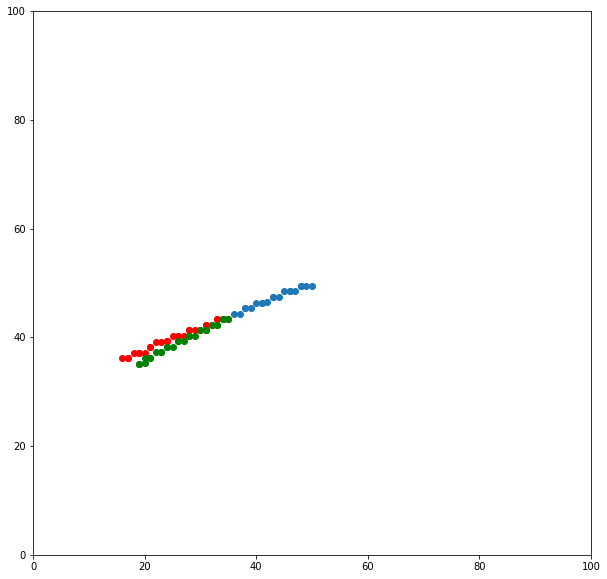

Input:  [[50, 49.5], [49, 49.49], [48, 49.48], [48, 49.48], [47, 48.47], [46, 48.46], [46, 48.46], [45, 48.45], [44, 47.44], [43, 47.43], [43, 47.43], [42, 46.42], [41, 46.41], [41, 46.41], [40, 46.4], [39, 45.39], [38, 45.38], [38, 45.38], [37, 44.37], [36, 44.36]]
Preds:  [[35, 43.35], [34, 43.34], [34, 43.34], [33, 42.33], [33, 42.33], [32, 42.32], [31, 41.31], [31, 41.31], [31, 41.31], [30, 41.3], [29, 40.29], [28, 40.28], [28, 40.28], [27, 39.27], [26, 39.26], [26, 39.26], [25, 38.25], [24, 38.24], [24, 38.24], [23, 37.23], [23, 37.23], [22, 37.22], [21, 36.21], [21, 36.21], [20, 36.2], [20, 35.2], [19, 35.19], [19, 35.19]]
Truth:  [[35, 43.35], [34, 43.34], [33, 43.33], [33, 43.33], [32, 42.32], [31, 42.31], [31, 42.31], [30, 41.3], [29, 41.29], [28, 41.28], [28, 41.28], [27, 40.27], [26, 40.26], [26, 40.26], [25, 40.25], [24, 39.24], [24, 39.24], [23, 39.23], [22, 39.22], [21, 38.21], [21, 38.21], [20, 37.2], [19, 37.19], [19, 37.19], [18, 37.18], [17, 36.17], [17, 36.17], [16, 

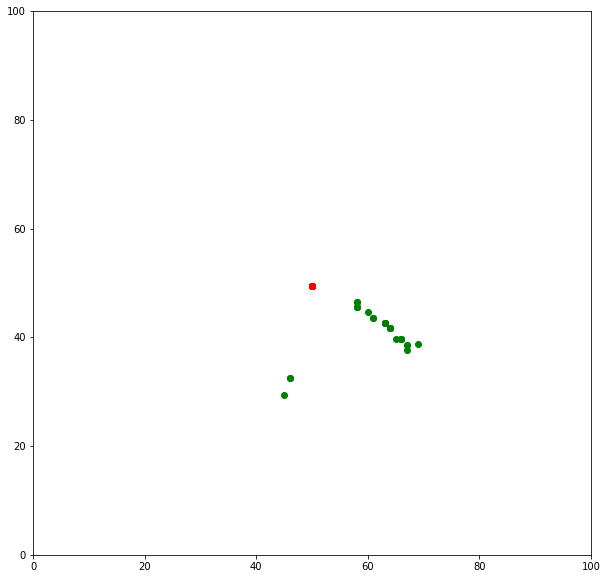

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
Preds:  [[58, 46.58], [58, 46.58], [58, 45.58], [58, 45.58], [58, 45.58], [46, 32.46], [46, 32.46], [60, 44.6], [61, 43.61], [61, 43.61], [45, 29.45], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [64, 41.64], [64, 41.64], [64, 41.64], [64, 41.64], [65, 39.65], [66, 39.66], [66, 39.66], [66, 39.66], [67, 38.67], [67, 38.67], [67, 37.67], [69, 38.69]]
Truth:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
10


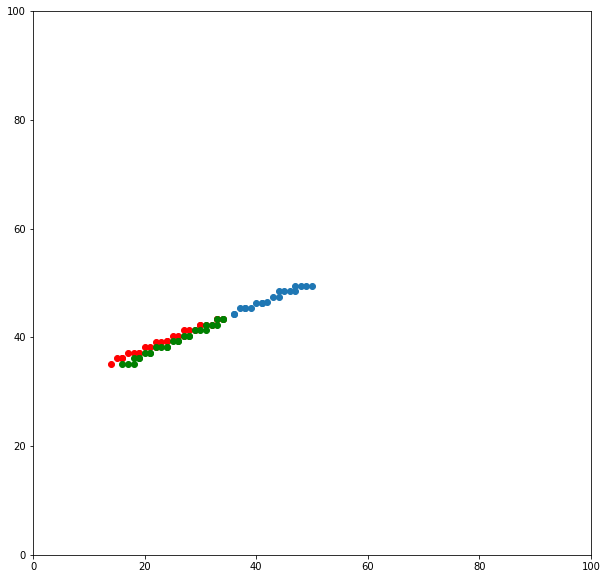

Input:  [[50, 49.5], [49, 49.49], [48, 49.48], [47, 49.47], [47, 48.47], [46, 48.46], [45, 48.45], [44, 48.44], [44, 47.44], [43, 47.43], [42, 46.42], [41, 46.41], [41, 46.41], [40, 46.4], [39, 45.39], [38, 45.38], [38, 45.38], [37, 45.37], [36, 44.36], [36, 44.36]]
Preds:  [[34, 43.34], [34, 43.34], [33, 43.33], [33, 42.33], [32, 42.32], [31, 42.31], [31, 41.31], [30, 41.3], [29, 41.29], [28, 40.28], [28, 40.28], [27, 40.27], [26, 39.26], [26, 39.26], [25, 39.25], [24, 38.24], [24, 38.24], [23, 38.23], [22, 38.22], [21, 37.21], [21, 37.21], [20, 37.2], [19, 36.19], [19, 36.19], [18, 36.18], [18, 35.18], [17, 35.17], [16, 35.16]]
Truth:  [[34, 43.34], [33, 43.33], [33, 43.33], [32, 42.32], [31, 42.31], [30, 42.3], [30, 42.3], [29, 41.29], [28, 41.28], [27, 41.27], [27, 40.27], [26, 40.26], [25, 40.25], [24, 39.24], [24, 39.24], [23, 39.23], [22, 39.22], [22, 38.22], [21, 38.21], [20, 38.2], [19, 37.19], [19, 37.19], [18, 37.18], [17, 37.17], [16, 36.16], [16, 36.16], [15, 36.15], [14, 

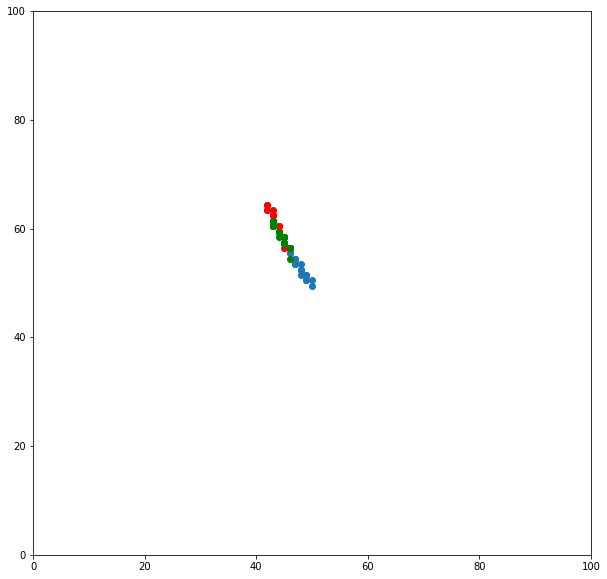

Input:  [[50, 49.5], [50, 50.5], [49, 50.49], [49, 50.49], [49, 51.49], [49, 51.49], [49, 51.49], [48, 51.48], [48, 52.48], [48, 52.48], [48, 52.48], [48, 53.48], [47, 53.47], [47, 53.47], [47, 53.47], [47, 54.47], [47, 54.47], [47, 54.47], [46, 55.46], [46, 55.46]]
Preds:  [[46, 54.46], [46, 56.46], [46, 56.46], [46, 56.46], [46, 56.46], [46, 56.46], [45, 57.45], [45, 57.45], [45, 57.45], [45, 58.45], [45, 58.45], [45, 58.45], [45, 58.45], [44, 58.44], [44, 59.44], [44, 59.44], [44, 59.44], [44, 59.44], [44, 59.44], [44, 59.44], [44, 59.44], [43, 60.43], [43, 60.43], [43, 60.43], [43, 61.43], [43, 61.43], [43, 61.43], [43, 61.43]]
Truth:  [[46, 56.46], [46, 56.46], [46, 56.46], [45, 56.45], [45, 57.45], [45, 57.45], [45, 57.45], [45, 58.45], [45, 58.45], [45, 58.45], [44, 59.44], [44, 59.44], [44, 59.44], [44, 60.44], [44, 60.44], [44, 60.44], [43, 60.43], [43, 61.43], [43, 61.43], [43, 61.43], [43, 62.43], [43, 62.43], [43, 62.43], [43, 63.43], [42, 63.42], [42, 63.42], [42, 64.42], 

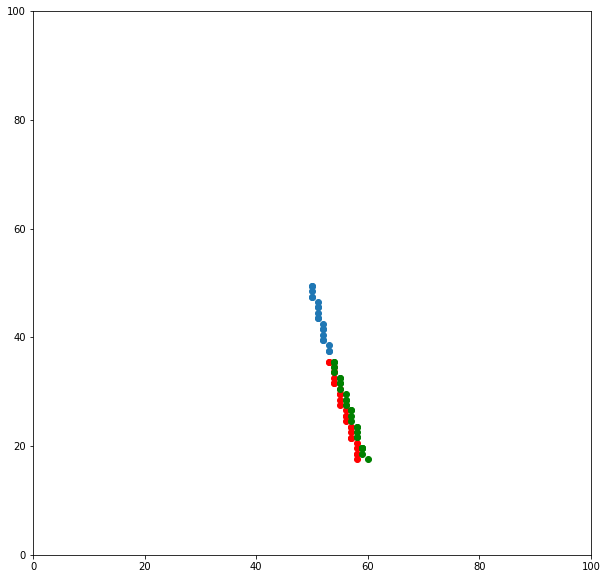

Input:  [[50, 49.5], [50, 49.5], [50, 48.5], [50, 47.5], [50, 47.5], [51, 46.51], [51, 45.51], [51, 45.51], [51, 44.51], [51, 43.51], [51, 43.51], [52, 42.52], [52, 41.52], [52, 41.52], [52, 40.52], [52, 39.52], [52, 39.52], [53, 38.53], [53, 37.53], [53, 37.53]]
Preds:  [[54, 35.54], [54, 35.54], [54, 34.54], [54, 33.54], [55, 32.55], [55, 32.55], [55, 31.55], [55, 31.55], [55, 30.55], [56, 29.56], [56, 28.56], [56, 28.56], [56, 27.56], [57, 26.57], [57, 26.57], [57, 25.57], [57, 24.57], [58, 23.58], [58, 23.58], [58, 22.58], [58, 21.58], [58, 21.58], [59, 19.59], [59, 19.59], [59, 19.59], [59, 19.59], [59, 18.59], [60, 17.6]]
Truth:  [[53, 35.53], [53, 35.53], [54, 34.54], [54, 33.54], [54, 33.54], [54, 32.54], [54, 31.54], [54, 31.54], [55, 30.55], [55, 29.55], [55, 29.55], [55, 28.55], [55, 27.55], [56, 27.56], [56, 26.56], [56, 25.56], [56, 25.56], [56, 24.56], [57, 23.57], [57, 23.57], [57, 22.57], [57, 21.57], [57, 21.57], [58, 20.58], [58, 19.58], [58, 18.58], [58, 18.58], [58,

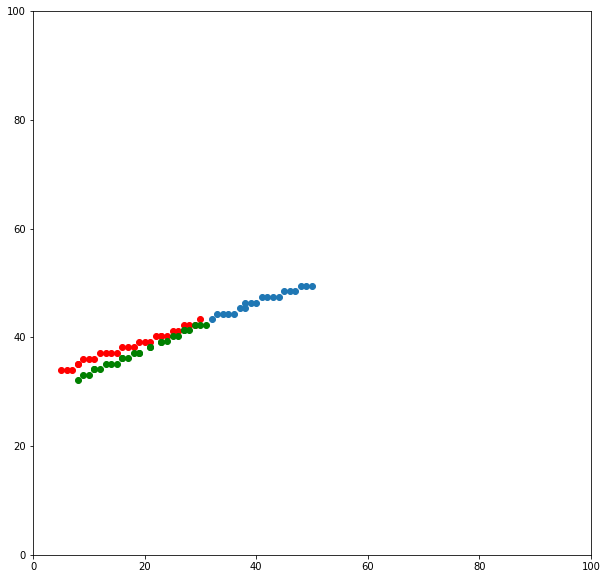

Input:  [[50, 49.5], [49, 49.49], [48, 49.48], [47, 48.47], [46, 48.46], [45, 48.45], [44, 47.44], [43, 47.43], [42, 47.42], [41, 47.41], [40, 46.4], [39, 46.39], [38, 46.38], [38, 45.38], [37, 45.37], [36, 44.36], [35, 44.35], [34, 44.34], [33, 44.33], [32, 43.32]]
Preds:  [[31, 42.31], [30, 42.3], [29, 42.29], [28, 41.28], [27, 41.27], [27, 41.27], [26, 40.26], [25, 40.25], [24, 39.24], [23, 39.23], [23, 39.23], [21, 38.21], [21, 38.21], [19, 37.19], [19, 37.19], [18, 37.18], [17, 36.17], [16, 36.16], [16, 36.16], [15, 35.15], [14, 35.14], [13, 35.13], [12, 34.12], [11, 34.11], [11, 34.11], [10, 33.1], [9, 33.09], [8, 32.08]]
Truth:  [[30, 43.3], [29, 42.29], [28, 42.28], [27, 42.27], [26, 41.26], [25, 41.25], [24, 40.24], [23, 40.23], [23, 40.23], [22, 40.22], [21, 39.21], [20, 39.2], [19, 39.19], [18, 38.18], [17, 38.17], [16, 38.16], [15, 37.15], [14, 37.14], [13, 37.13], [12, 37.12], [11, 36.11], [10, 36.1], [9, 36.09], [8, 35.08], [8, 35.08], [7, 34.07], [6, 34.06], [5, 34.05]]


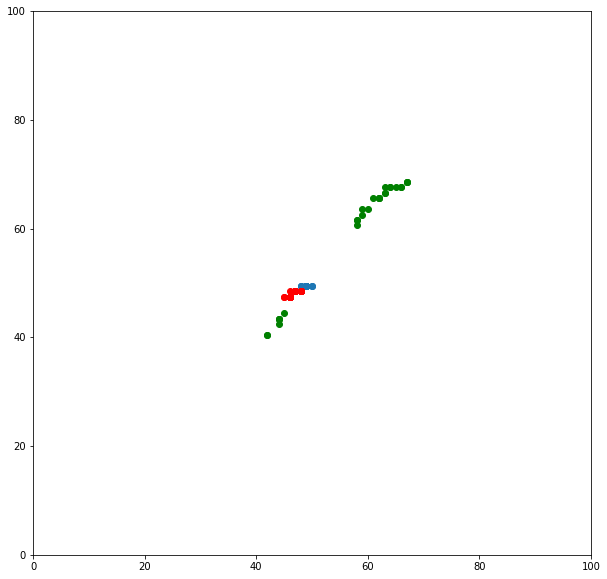

Input:  [[50, 49.5], [50, 49.5], [49, 49.49], [49, 49.49], [49, 49.49], [49, 49.49], [49, 49.49], [49, 49.49], [49, 49.49], [49, 49.49], [49, 49.49], [49, 49.49], [49, 49.49], [49, 49.49], [48, 49.48], [48, 49.48], [48, 49.48], [48, 48.48], [48, 48.48], [48, 48.48]]
Preds:  [[45, 44.45], [44, 43.44], [44, 43.44], [44, 43.44], [44, 42.44], [58, 60.58], [58, 61.58], [58, 61.58], [59, 62.59], [59, 63.59], [60, 63.6], [42, 40.42], [42, 40.42], [61, 65.61], [62, 65.62], [62, 65.62], [62, 65.62], [63, 66.63], [63, 66.63], [63, 67.63], [64, 67.64], [64, 67.64], [65, 67.65], [66, 67.66], [66, 67.66], [67, 68.67], [67, 68.67], [67, 68.67]]
Truth:  [[48, 48.48], [48, 48.48], [48, 48.48], [48, 48.48], [48, 48.48], [48, 48.48], [47, 48.47], [47, 48.47], [48, 48.48], [47, 48.47], [47, 48.47], [47, 48.47], [47, 48.47], [47, 48.47], [47, 48.47], [47, 48.47], [46, 48.46], [46, 47.46], [46, 47.46], [46, 47.46], [46, 47.46], [46, 47.46], [46, 47.46], [46, 47.46], [46, 47.46], [46, 47.46], [45, 47.45], [

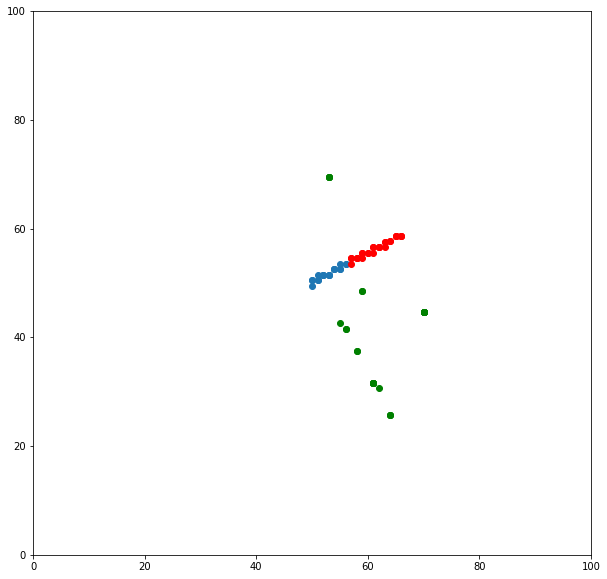

Input:  [[50, 49.5], [50, 50.5], [50, 50.5], [51, 50.51], [51, 50.51], [51, 51.51], [52, 51.52], [52, 51.52], [52, 51.52], [53, 51.53], [53, 51.53], [53, 51.53], [54, 52.54], [54, 52.54], [54, 52.54], [55, 52.55], [55, 53.55], [55, 52.55], [56, 53.56], [56, 53.56]]
Preds:  [[55, 42.55], [56, 41.56], [56, 41.56], [59, 48.59], [59, 48.59], [58, 37.58], [58, 37.58], [53, 69.53], [53, 69.53], [53, 69.53], [53, 69.53], [61, 31.61], [61, 31.61], [61, 31.61], [61, 31.61], [61, 31.61], [61, 31.61], [62, 30.62], [70, 44.7], [70, 44.7], [70, 44.7], [70, 44.7], [70, 44.7], [70, 44.7], [70, 44.7], [64, 25.64], [64, 25.64], [64, 25.64]]
Truth:  [[57, 53.57], [57, 54.57], [57, 54.57], [58, 54.58], [58, 54.58], [58, 54.58], [59, 54.59], [59, 55.59], [59, 55.59], [60, 55.6], [60, 55.6], [61, 55.61], [61, 56.61], [61, 56.61], [62, 56.62], [62, 56.62], [62, 56.62], [63, 56.63], [63, 57.63], [63, 57.63], [64, 57.64], [64, 57.64], [65, 58.65], [65, 58.65], [65, 58.65], [66, 58.66], [66, 58.66], [66, 58.66

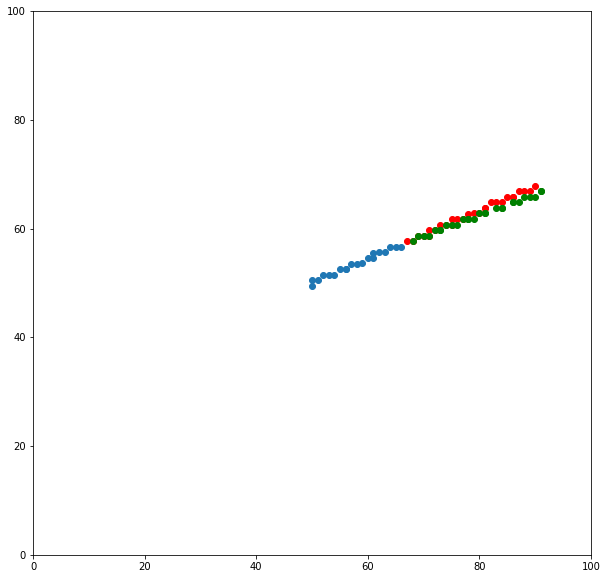

Input:  [[50, 49.5], [50, 50.5], [51, 50.51], [52, 51.52], [53, 51.53], [54, 51.54], [55, 52.55], [56, 52.56], [56, 52.56], [57, 53.57], [58, 53.58], [59, 53.59], [60, 54.6], [61, 54.61], [61, 55.61], [62, 55.62], [63, 55.63], [64, 56.64], [65, 56.65], [66, 56.66]]
Preds:  [[68, 57.68], [69, 58.69], [70, 58.7], [71, 58.71], [72, 59.72], [73, 59.73], [73, 59.73], [74, 60.74], [75, 60.75], [76, 60.76], [77, 61.77], [78, 61.78], [78, 61.78], [79, 61.79], [80, 62.8], [81, 62.81], [81, 62.81], [83, 63.83], [84, 63.84], [84, 63.84], [86, 64.86], [86, 64.86], [87, 64.87], [88, 65.88], [89, 65.89], [90, 65.9], [91, 66.91], [91, 66.91]]
Truth:  [[67, 57.67], [68, 57.68], [69, 58.69], [70, 58.7], [71, 58.71], [71, 59.71], [72, 59.72], [73, 60.73], [74, 60.74], [75, 60.75], [75, 61.75], [76, 61.76], [77, 61.77], [78, 62.78], [79, 62.79], [80, 62.8], [81, 63.81], [81, 63.81], [82, 64.82], [83, 64.83], [84, 64.84], [85, 65.85], [86, 65.86], [86, 65.86], [87, 66.87], [88, 66.88], [89, 66.89], [90, 6

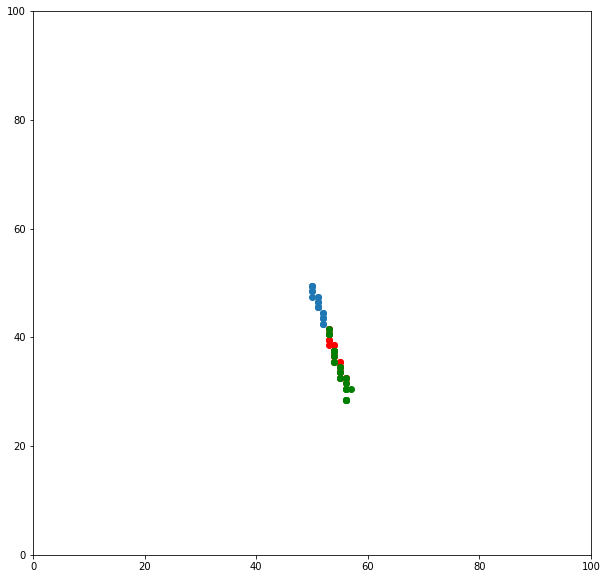

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 48.5], [50, 48.5], [50, 47.5], [51, 47.51], [51, 47.51], [51, 46.51], [51, 46.51], [51, 45.51], [51, 45.51], [51, 45.51], [52, 44.52], [52, 44.52], [52, 43.52], [52, 43.52], [52, 43.52], [52, 42.52], [52, 42.52]]
Preds:  [[53, 41.53], [53, 40.53], [53, 40.53], [53, 40.53], [54, 37.54], [54, 37.54], [54, 37.54], [54, 37.54], [54, 37.54], [54, 36.54], [54, 35.54], [54, 35.54], [55, 34.55], [55, 34.55], [55, 33.55], [55, 33.55], [55, 32.55], [55, 32.55], [56, 32.56], [56, 31.56], [56, 30.56], [56, 30.56], [56, 30.56], [57, 30.57], [56, 28.56], [56, 28.56], [56, 28.56], [56, 28.56]]
Truth:  [[53, 41.53], [53, 41.53], [53, 40.53], [53, 40.53], [53, 40.53], [53, 39.53], [53, 39.53], [53, 38.53], [54, 38.54], [54, 38.54], [54, 37.54], [54, 37.54], [54, 37.54], [54, 36.54], [54, 36.54], [54, 36.54], [54, 35.54], [55, 35.55], [55, 35.55], [55, 34.55], [55, 34.55], [55, 34.55], [55, 33.55], [55, 33.55], [55, 32.55], [56, 32.56], [56, 32.56], [56,

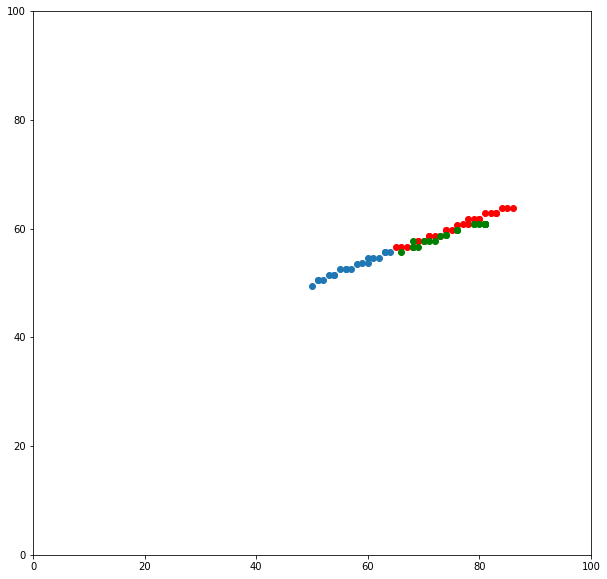

Input:  [[50, 49.5], [51, 50.51], [51, 50.51], [52, 50.52], [53, 51.53], [54, 51.54], [54, 51.54], [55, 52.55], [56, 52.56], [56, 52.56], [57, 52.57], [58, 53.58], [59, 53.59], [60, 53.6], [60, 54.6], [61, 54.61], [62, 54.62], [63, 55.63], [63, 55.63], [64, 55.64]]
Preds:  [[68, 57.68], [66, 55.66], [68, 56.68], [68, 56.68], [69, 56.69], [70, 57.7], [71, 57.71], [72, 57.72], [73, 58.73], [74, 58.74], [74, 58.74], [76, 59.76], [76, 59.76], [76, 59.76], [79, 60.79], [79, 60.79], [80, 60.8], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81]]
Truth:  [[65, 56.65], [66, 56.66], [67, 56.67], [68, 56.68], [69, 57.69], [69, 57.69], [70, 57.7], [71, 58.71], [71, 58.71], [72, 58.72], [73, 58.73], [74, 59.74], [74, 59.74], [75, 59.75], [76, 60.76], [77, 60.77], [78, 60.78], [78, 61.78], [79, 61.79], [80, 61.8], [80, 61.8], [81, 62.81], [82, 62.82], [83, 62.83], [83, 62.83], [84, 63.84], [85, 63.85], [86, 6

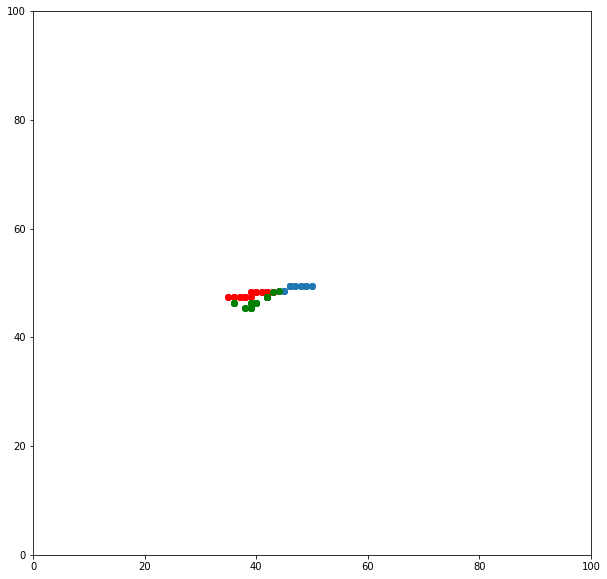

Input:  [[50, 49.5], [50, 49.5], [49, 49.49], [49, 49.49], [49, 49.49], [48, 49.48], [48, 49.48], [48, 49.48], [47, 49.47], [47, 49.47], [47, 49.47], [46, 49.46], [46, 49.46], [46, 49.46], [46, 49.46], [45, 48.45], [45, 48.45], [45, 48.45], [44, 48.44], [44, 48.44]]
Preds:  [[43, 48.43], [44, 48.44], [42, 47.42], [42, 47.42], [42, 47.42], [42, 47.42], [42, 47.42], [42, 47.42], [42, 47.42], [42, 47.42], [42, 47.42], [42, 47.42], [40, 46.4], [40, 46.4], [40, 46.4], [40, 46.4], [39, 46.39], [39, 46.39], [39, 46.39], [39, 45.39], [39, 45.39], [39, 45.39], [39, 45.39], [38, 45.38], [38, 45.38], [36, 46.36], [36, 46.36], [36, 46.36]]
Truth:  [[43, 48.43], [43, 48.43], [43, 48.43], [42, 48.42], [42, 48.42], [42, 48.42], [42, 48.42], [41, 48.41], [41, 48.41], [41, 48.41], [40, 48.4], [40, 48.4], [40, 48.4], [39, 48.39], [39, 48.39], [39, 47.39], [38, 47.38], [38, 47.38], [38, 47.38], [38, 47.38], [37, 47.37], [37, 47.37], [37, 47.37], [36, 47.36], [36, 47.36], [36, 47.36], [35, 47.35], [35, 47

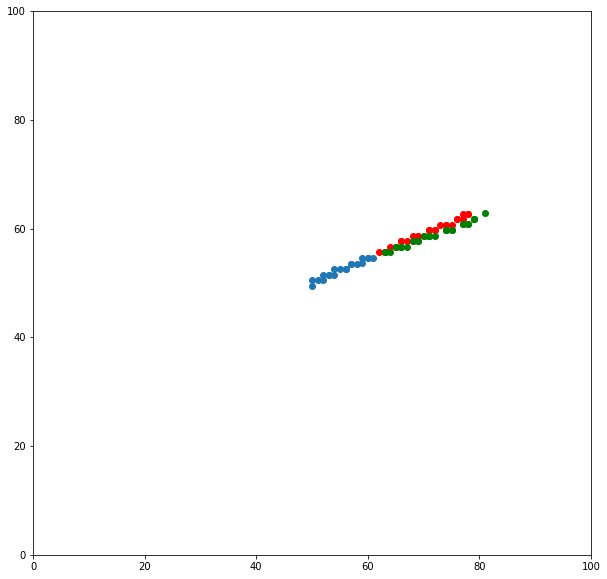

Input:  [[50, 49.5], [50, 50.5], [51, 50.51], [52, 50.52], [52, 51.52], [53, 51.53], [53, 51.53], [54, 51.54], [54, 52.54], [55, 52.55], [56, 52.56], [56, 52.56], [57, 53.57], [57, 53.57], [58, 53.58], [59, 53.59], [59, 54.59], [60, 54.6], [60, 54.6], [61, 54.61]]
Preds:  [[63, 55.63], [63, 55.63], [64, 55.64], [65, 56.65], [66, 56.66], [66, 56.66], [67, 56.67], [68, 57.68], [69, 57.69], [69, 57.69], [70, 58.7], [71, 58.71], [71, 58.71], [71, 58.71], [72, 58.72], [74, 59.74], [74, 59.74], [74, 59.74], [75, 59.75], [75, 59.75], [77, 60.77], [77, 60.77], [78, 60.78], [78, 60.78], [79, 61.79], [79, 61.79], [79, 61.79], [81, 62.81]]
Truth:  [[62, 55.62], [63, 55.63], [63, 55.63], [64, 56.64], [65, 56.65], [65, 56.65], [66, 57.66], [66, 57.66], [67, 57.67], [68, 57.68], [68, 58.68], [69, 58.69], [69, 58.69], [70, 58.7], [71, 59.71], [71, 59.71], [72, 59.72], [72, 59.72], [73, 60.73], [74, 60.74], [74, 60.74], [75, 60.75], [76, 61.76], [76, 61.76], [77, 61.77], [77, 62.77], [78, 62.78], [78,

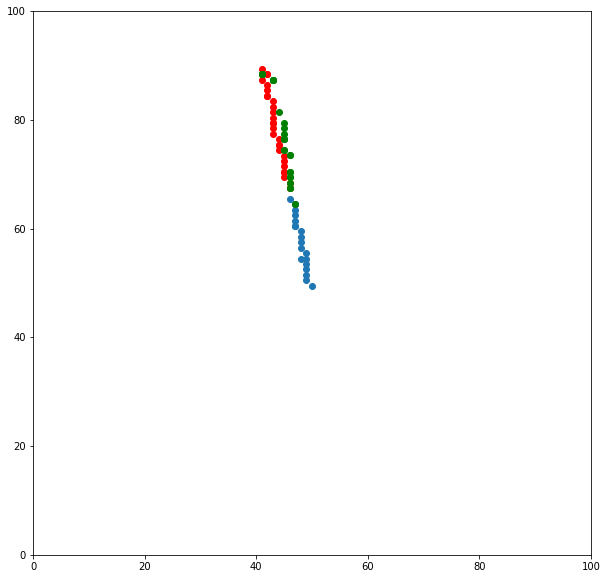

Input:  [[50, 49.5], [49, 50.49], [49, 51.49], [49, 52.49], [49, 53.49], [48, 54.48], [49, 54.49], [49, 55.49], [48, 56.48], [48, 57.48], [48, 58.48], [48, 59.48], [47, 60.47], [47, 60.47], [47, 61.47], [47, 62.47], [47, 63.47], [47, 64.47], [47, 64.47], [46, 65.46]]
Preds:  [[47, 64.47], [46, 67.46], [46, 67.46], [46, 68.46], [46, 69.46], [46, 69.46], [46, 70.46], [46, 70.46], [45, 74.45], [46, 73.46], [46, 73.46], [45, 74.45], [45, 76.45], [45, 76.45], [45, 76.45], [45, 77.45], [45, 78.45], [45, 79.45], [44, 81.44], [41, 88.41], [41, 88.41], [41, 88.41], [41, 88.41], [41, 88.41], [43, 87.43], [43, 87.43], [43, 87.43], [43, 87.43]]
Truth:  [[46, 67.46], [46, 68.46], [45, 69.45], [45, 70.45], [45, 70.45], [45, 71.45], [45, 72.45], [45, 73.45], [44, 74.44], [44, 75.44], [44, 75.44], [44, 76.44], [43, 77.43], [43, 78.43], [43, 79.43], [43, 79.43], [43, 80.43], [43, 81.43], [43, 82.43], [43, 83.43], [42, 84.42], [42, 84.42], [42, 85.42], [42, 86.42], [41, 87.41], [42, 88.42], [42, 88.42],

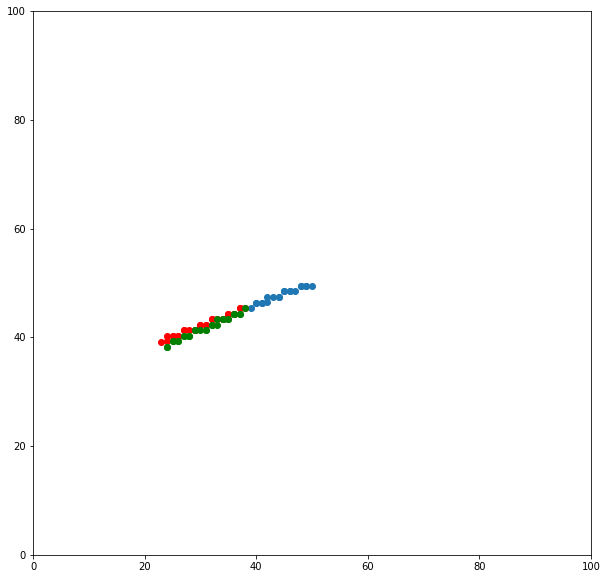

Input:  [[50, 49.5], [49, 49.49], [49, 49.49], [48, 49.48], [48, 49.48], [47, 48.47], [46, 48.46], [46, 48.46], [45, 48.45], [45, 48.45], [44, 47.44], [44, 47.44], [43, 47.43], [42, 47.42], [42, 46.42], [41, 46.41], [41, 46.41], [40, 46.4], [40, 46.4], [39, 45.39]]
Preds:  [[38, 45.38], [37, 44.37], [37, 44.37], [36, 44.36], [36, 44.36], [35, 43.35], [35, 43.35], [34, 43.34], [34, 43.34], [33, 43.33], [33, 42.33], [32, 42.32], [32, 42.32], [31, 41.31], [31, 41.31], [30, 41.3], [29, 41.29], [29, 41.29], [28, 40.28], [28, 40.28], [27, 40.27], [27, 40.27], [26, 39.26], [26, 39.26], [25, 39.25], [25, 39.25], [24, 38.24], [24, 38.24]]
Truth:  [[38, 45.38], [37, 45.37], [37, 45.37], [36, 44.36], [36, 44.36], [35, 44.35], [35, 44.35], [34, 43.34], [34, 43.34], [33, 43.33], [32, 43.32], [32, 43.32], [31, 42.31], [31, 42.31], [30, 42.3], [30, 42.3], [29, 41.29], [29, 41.29], [28, 41.28], [27, 41.27], [27, 41.27], [26, 40.26], [26, 40.26], [25, 40.25], [25, 40.25], [24, 40.24], [24, 39.24], [23,

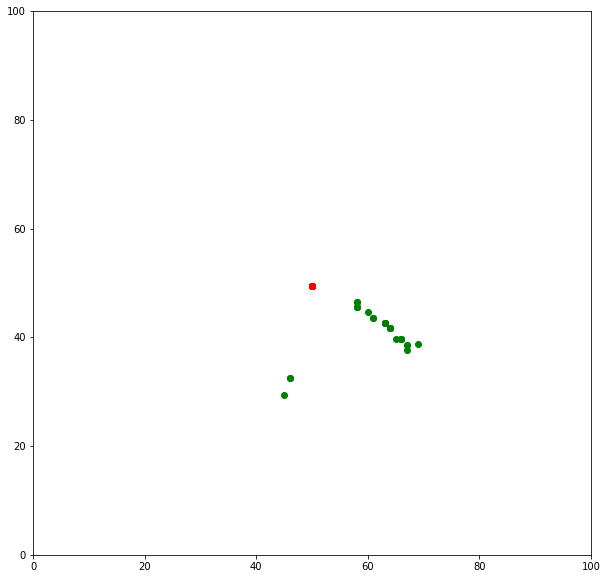

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
Preds:  [[58, 46.58], [58, 46.58], [58, 45.58], [58, 45.58], [58, 45.58], [46, 32.46], [46, 32.46], [60, 44.6], [61, 43.61], [61, 43.61], [45, 29.45], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [64, 41.64], [64, 41.64], [64, 41.64], [64, 41.64], [65, 39.65], [66, 39.66], [66, 39.66], [66, 39.66], [67, 38.67], [67, 38.67], [67, 37.67], [69, 38.69]]
Truth:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
24


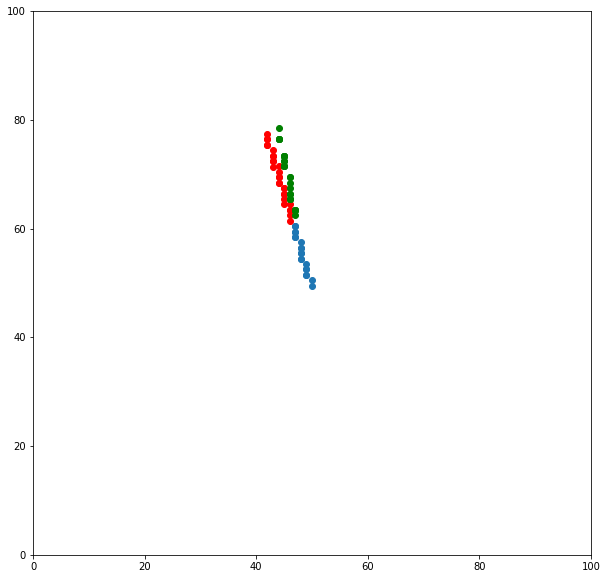

Input:  [[50, 49.5], [50, 50.5], [49, 51.49], [49, 51.49], [49, 52.49], [49, 52.49], [49, 53.49], [48, 54.48], [48, 54.48], [48, 55.48], [48, 55.48], [48, 56.48], [48, 56.48], [48, 57.48], [47, 58.47], [47, 58.47], [47, 59.47], [47, 59.47], [47, 60.47], [47, 60.47]]
Preds:  [[47, 62.47], [47, 63.47], [47, 63.47], [47, 63.47], [47, 63.47], [46, 65.46], [46, 65.46], [46, 65.46], [46, 66.46], [46, 66.46], [46, 67.46], [46, 68.46], [46, 69.46], [46, 69.46], [45, 71.45], [45, 71.45], [45, 71.45], [45, 72.45], [45, 72.45], [45, 73.45], [45, 73.45], [45, 73.45], [45, 73.45], [44, 76.44], [44, 76.44], [44, 76.44], [44, 76.44], [44, 78.44]]
Truth:  [[46, 61.46], [46, 62.46], [46, 63.46], [46, 63.46], [46, 64.46], [45, 64.45], [45, 65.45], [45, 66.45], [45, 66.45], [45, 67.45], [45, 67.45], [44, 68.44], [44, 68.44], [44, 69.44], [44, 69.44], [44, 70.44], [44, 71.44], [43, 71.43], [43, 72.43], [43, 72.43], [43, 73.43], [43, 73.43], [43, 74.43], [42, 75.42], [42, 75.42], [42, 76.42], [42, 76.42], 

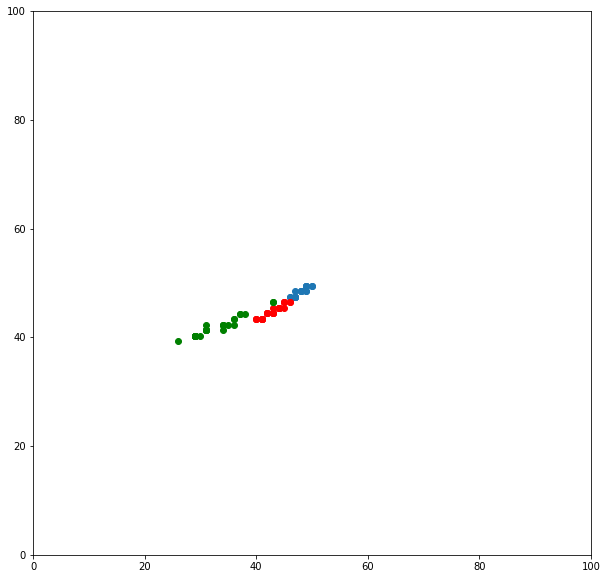

Input:  [[50, 49.5], [50, 49.5], [49, 49.49], [49, 49.49], [49, 49.49], [49, 49.49], [49, 48.49], [49, 48.49], [48, 48.48], [48, 48.48], [48, 48.48], [48, 48.48], [47, 48.47], [47, 47.47], [47, 47.47], [47, 47.47], [47, 47.47], [47, 47.47], [46, 47.46], [46, 47.46]]
Preds:  [[43, 46.43], [43, 46.43], [38, 44.38], [37, 44.37], [37, 44.37], [36, 42.36], [36, 43.36], [36, 43.36], [35, 42.35], [34, 42.34], [34, 42.34], [34, 42.34], [31, 42.31], [34, 41.34], [31, 41.31], [31, 41.31], [31, 41.31], [31, 41.31], [31, 41.31], [30, 40.3], [29, 40.29], [29, 40.29], [26, 39.26], [29, 40.29], [29, 40.29], [29, 40.29], [29, 40.29], [29, 40.29]]
Truth:  [[46, 46.46], [46, 46.46], [45, 46.45], [45, 46.45], [45, 46.45], [45, 45.45], [44, 45.44], [44, 45.44], [44, 45.44], [44, 45.44], [44, 45.44], [43, 45.43], [43, 44.43], [43, 44.43], [43, 44.43], [43, 44.43], [42, 44.42], [42, 44.42], [42, 44.42], [42, 44.42], [41, 43.41], [41, 43.41], [41, 43.41], [41, 43.41], [41, 43.41], [40, 43.4], [40, 43.4], [40

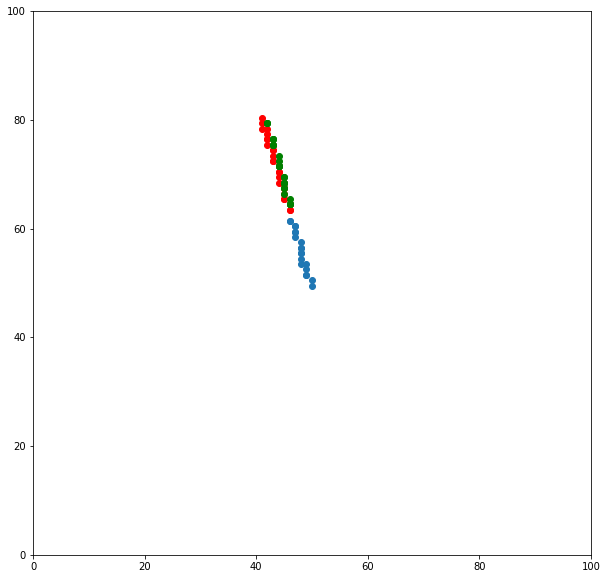

Input:  [[50, 49.5], [50, 50.5], [49, 51.49], [49, 51.49], [49, 52.49], [49, 53.49], [48, 53.48], [48, 54.48], [48, 55.48], [48, 55.48], [48, 56.48], [48, 56.48], [48, 57.48], [47, 58.47], [47, 59.47], [47, 59.47], [47, 60.47], [47, 60.47], [46, 61.46], [46, 61.46]]
Preds:  [[46, 64.46], [46, 64.46], [46, 64.46], [46, 64.46], [46, 65.46], [45, 66.45], [45, 67.45], [45, 67.45], [45, 68.45], [45, 68.45], [45, 68.45], [45, 69.45], [45, 69.45], [44, 71.44], [44, 71.44], [44, 71.44], [44, 71.44], [44, 72.44], [44, 73.44], [43, 75.43], [43, 75.43], [43, 75.43], [43, 76.43], [43, 76.43], [43, 76.43], [42, 79.42], [42, 79.42], [42, 79.42]]
Truth:  [[46, 63.46], [46, 63.46], [46, 64.46], [45, 65.45], [45, 65.45], [45, 66.45], [45, 67.45], [45, 67.45], [45, 68.45], [44, 68.44], [44, 69.44], [44, 70.44], [44, 70.44], [44, 71.44], [43, 72.43], [43, 72.43], [43, 73.43], [43, 74.43], [43, 74.43], [43, 75.43], [42, 75.42], [42, 76.42], [42, 76.42], [42, 77.42], [42, 78.42], [41, 78.41], [41, 79.41], 

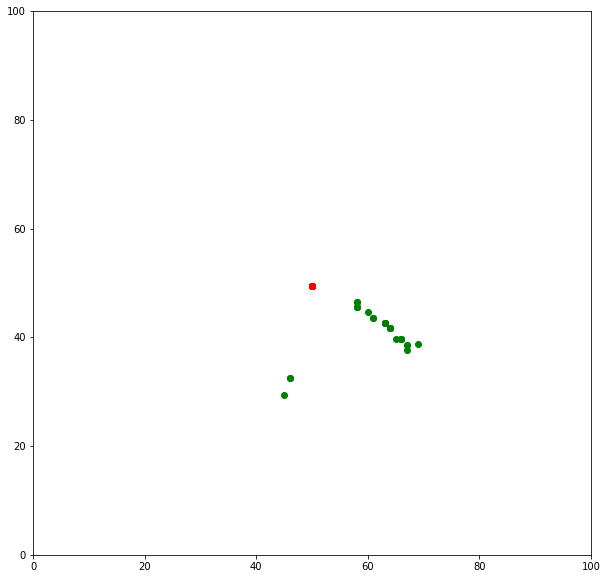

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
Preds:  [[58, 46.58], [58, 46.58], [58, 45.58], [58, 45.58], [58, 45.58], [46, 32.46], [46, 32.46], [60, 44.6], [61, 43.61], [61, 43.61], [45, 29.45], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [64, 41.64], [64, 41.64], [64, 41.64], [64, 41.64], [65, 39.65], [66, 39.66], [66, 39.66], [66, 39.66], [67, 38.67], [67, 38.67], [67, 37.67], [69, 38.69]]
Truth:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
28


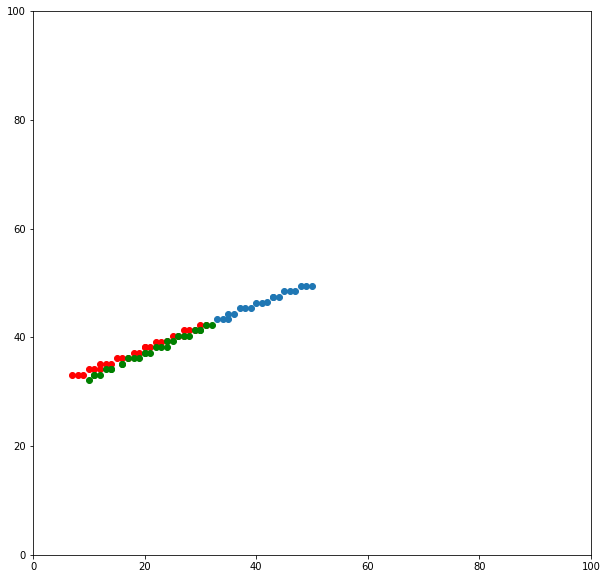

Input:  [[50, 49.5], [49, 49.49], [48, 49.48], [47, 48.47], [46, 48.46], [45, 48.45], [44, 47.44], [43, 47.43], [43, 47.43], [42, 46.42], [41, 46.41], [40, 46.4], [39, 45.39], [38, 45.38], [37, 45.37], [36, 44.36], [35, 44.35], [35, 43.35], [34, 43.34], [33, 43.33]]
Preds:  [[32, 42.32], [31, 42.31], [30, 41.3], [30, 41.3], [29, 41.29], [28, 40.28], [27, 40.27], [26, 40.26], [25, 39.25], [24, 39.24], [24, 38.24], [23, 38.23], [22, 38.22], [21, 37.21], [20, 37.2], [20, 37.2], [19, 36.19], [18, 36.18], [17, 36.17], [16, 35.16], [16, 35.16], [14, 34.14], [14, 34.14], [13, 34.13], [12, 33.12], [11, 33.11], [11, 33.11], [10, 32.1]]
Truth:  [[31, 42.31], [30, 42.3], [29, 41.29], [28, 41.28], [27, 41.27], [27, 40.27], [26, 40.26], [25, 40.25], [24, 39.24], [23, 39.23], [22, 39.22], [21, 38.21], [20, 38.2], [20, 38.2], [19, 37.19], [18, 37.18], [17, 36.17], [16, 36.16], [15, 36.15], [14, 35.14], [13, 35.13], [12, 35.12], [12, 34.12], [11, 34.11], [10, 34.1], [9, 33.09], [8, 33.08], [7, 33.07]]

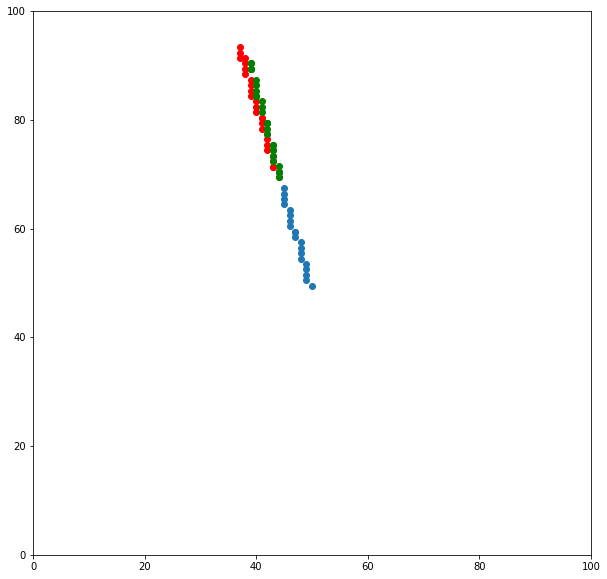

Input:  [[50, 49.5], [49, 50.49], [49, 51.49], [49, 52.49], [49, 53.49], [48, 54.48], [48, 55.48], [48, 56.48], [48, 57.48], [47, 58.47], [47, 59.47], [47, 59.47], [46, 60.46], [46, 61.46], [46, 62.46], [46, 63.46], [45, 64.45], [45, 65.45], [45, 66.45], [45, 67.45]]
Preds:  [[44, 69.44], [44, 70.44], [44, 70.44], [44, 71.44], [43, 72.43], [43, 73.43], [43, 74.43], [43, 74.43], [43, 75.43], [43, 75.43], [42, 77.42], [42, 78.42], [42, 79.42], [42, 79.42], [42, 79.42], [41, 81.41], [41, 82.41], [41, 83.41], [40, 84.4], [40, 84.4], [40, 85.4], [40, 86.4], [40, 87.4], [39, 89.39], [39, 89.39], [39, 89.39], [39, 90.39], [39, 90.39]]
Truth:  [[44, 69.44], [44, 70.44], [43, 71.43], [43, 71.43], [43, 72.43], [43, 73.43], [42, 74.42], [42, 75.42], [42, 76.42], [42, 77.42], [41, 78.41], [41, 79.41], [41, 80.41], [41, 80.41], [40, 81.4], [40, 82.4], [40, 83.4], [39, 84.39], [39, 85.39], [39, 86.39], [39, 87.39], [38, 88.38], [38, 89.38], [38, 90.38], [38, 91.38], [37, 91.37], [37, 92.37], [37, 93

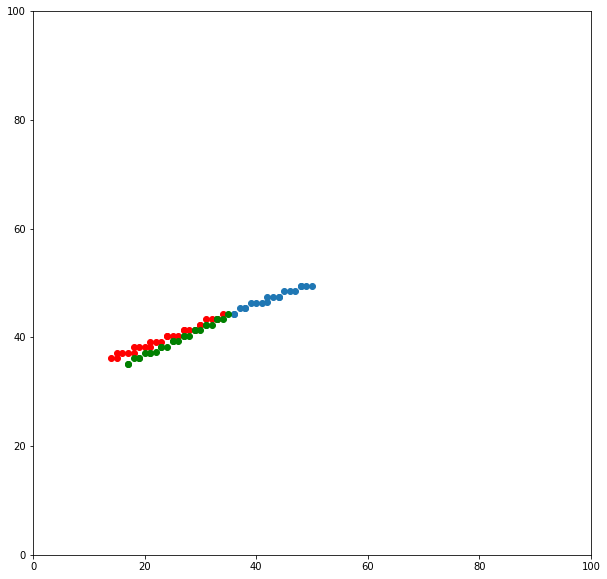

Input:  [[50, 49.5], [49, 49.49], [48, 49.48], [48, 49.48], [47, 48.47], [46, 48.46], [45, 48.45], [44, 47.44], [44, 47.44], [43, 47.43], [42, 47.42], [42, 46.42], [41, 46.41], [40, 46.4], [39, 46.39], [38, 45.38], [38, 45.38], [37, 45.37], [36, 44.36], [36, 44.36]]
Preds:  [[35, 44.35], [34, 43.34], [33, 43.33], [33, 43.33], [32, 42.32], [31, 42.31], [31, 42.31], [30, 41.3], [29, 41.29], [29, 41.29], [28, 40.28], [27, 40.27], [27, 40.27], [26, 39.26], [25, 39.25], [25, 39.25], [24, 38.24], [23, 38.23], [23, 38.23], [22, 37.22], [21, 37.21], [21, 37.21], [20, 37.2], [19, 36.19], [19, 36.19], [18, 36.18], [17, 35.17], [17, 35.17]]
Truth:  [[34, 44.34], [33, 43.33], [33, 43.33], [32, 43.32], [31, 43.31], [30, 42.3], [30, 42.3], [29, 41.29], [28, 41.28], [27, 41.27], [27, 41.27], [26, 40.26], [25, 40.25], [24, 40.24], [24, 40.24], [23, 39.23], [22, 39.22], [21, 39.21], [21, 38.21], [20, 38.2], [19, 38.19], [18, 38.18], [18, 37.18], [17, 37.17], [16, 37.16], [15, 37.15], [15, 36.15], [14, 

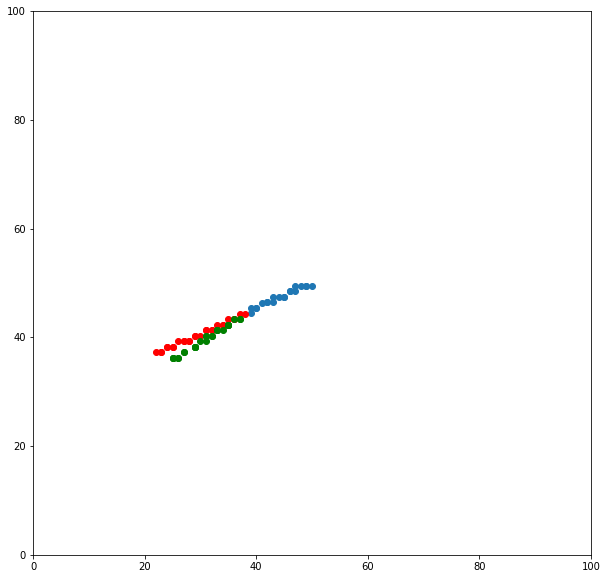

Input:  [[50, 49.5], [49, 49.49], [49, 49.49], [48, 49.48], [47, 49.47], [47, 48.47], [46, 48.46], [46, 48.46], [45, 47.45], [45, 47.45], [44, 47.44], [43, 47.43], [43, 46.43], [42, 46.42], [42, 46.42], [41, 46.41], [40, 45.4], [40, 45.4], [39, 45.39], [39, 44.39]]
Preds:  [[37, 43.37], [37, 43.37], [36, 43.36], [35, 42.35], [35, 42.35], [35, 42.35], [35, 42.35], [33, 41.33], [33, 41.33], [33, 41.33], [34, 41.34], [31, 40.31], [31, 40.31], [32, 40.32], [32, 40.32], [30, 39.3], [31, 39.31], [29, 38.29], [29, 38.29], [29, 38.29], [29, 38.29], [27, 37.27], [27, 37.27], [25, 36.25], [25, 36.25], [25, 36.25], [26, 36.26], [26, 36.26]]
Truth:  [[38, 44.38], [37, 44.37], [36, 43.36], [36, 43.36], [35, 43.35], [35, 42.35], [34, 42.34], [34, 42.34], [33, 42.33], [32, 41.32], [32, 41.32], [31, 41.31], [31, 41.31], [30, 40.3], [29, 40.29], [29, 40.29], [28, 39.28], [28, 39.28], [27, 39.27], [27, 39.27], [26, 39.26], [25, 38.25], [25, 38.25], [24, 38.24], [24, 38.24], [23, 37.23], [23, 37.23], [22

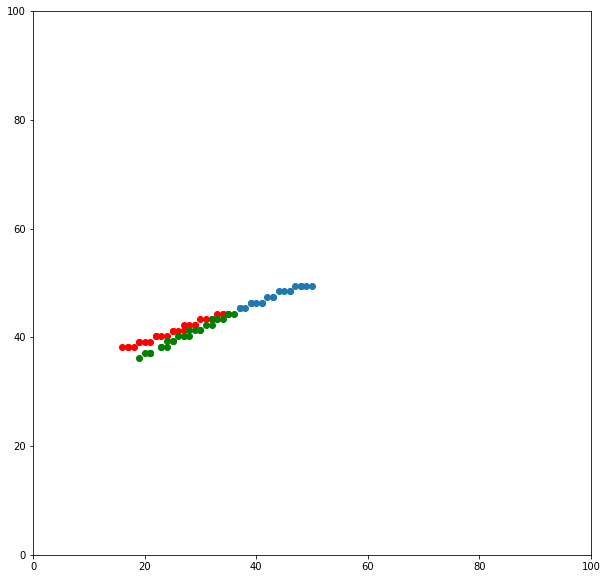

Input:  [[50, 49.5], [49, 49.49], [48, 49.48], [48, 49.48], [47, 49.47], [46, 48.46], [46, 48.46], [45, 48.45], [44, 48.44], [43, 47.43], [43, 47.43], [42, 47.42], [41, 46.41], [41, 46.41], [40, 46.4], [39, 46.39], [39, 46.39], [38, 45.38], [37, 45.37], [37, 45.37]]
Preds:  [[36, 44.36], [35, 44.35], [35, 44.35], [34, 43.34], [33, 43.33], [33, 43.33], [32, 43.32], [32, 42.32], [31, 42.31], [30, 41.3], [30, 41.3], [29, 41.29], [28, 41.28], [28, 40.28], [27, 40.27], [27, 40.27], [26, 40.26], [25, 39.25], [25, 39.25], [24, 39.24], [24, 38.24], [23, 38.23], [23, 38.23], [21, 37.21], [21, 37.21], [21, 37.21], [20, 37.2], [19, 36.19]]
Truth:  [[35, 44.35], [34, 44.34], [34, 44.34], [33, 44.33], [32, 43.32], [32, 43.32], [31, 43.31], [30, 43.3], [29, 42.29], [29, 42.29], [28, 42.28], [27, 42.27], [27, 41.27], [26, 41.26], [25, 41.25], [25, 41.25], [24, 40.24], [23, 40.23], [22, 40.22], [22, 40.22], [21, 39.21], [20, 39.2], [19, 39.19], [19, 39.19], [18, 38.18], [17, 38.17], [17, 38.17], [16, 

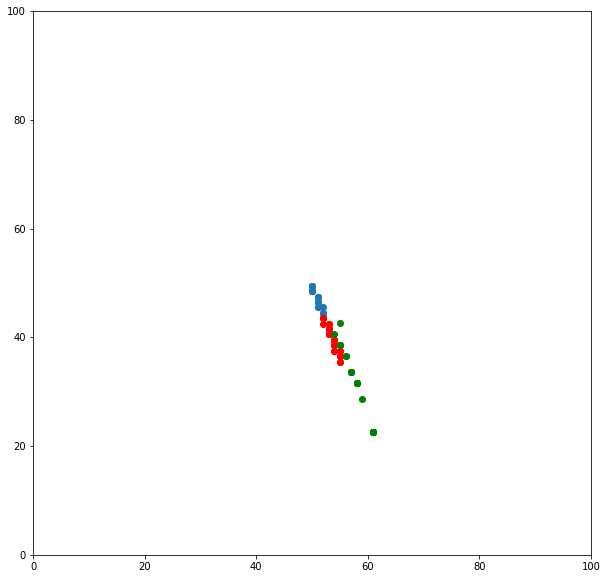

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 48.5], [50, 48.5], [50, 48.5], [50, 48.5], [51, 47.51], [51, 47.51], [51, 47.51], [51, 46.51], [51, 46.51], [51, 46.51], [51, 45.51], [51, 45.51], [52, 45.52], [52, 44.52], [52, 44.52], [52, 44.52], [52, 43.52]]
Preds:  [[55, 42.55], [54, 40.54], [55, 38.55], [55, 38.55], [55, 38.55], [56, 36.56], [56, 36.56], [57, 33.57], [57, 33.57], [57, 33.57], [57, 33.57], [58, 31.58], [58, 31.58], [58, 31.58], [58, 31.58], [59, 28.59], [61, 22.61], [61, 22.61], [61, 22.61], [61, 22.61], [61, 22.61], [61, 22.61], [61, 22.61], [61, 22.61], [61, 22.61], [61, 22.61], [61, 22.61], [61, 22.61]]
Truth:  [[52, 43.52], [52, 43.52], [52, 42.52], [53, 42.53], [53, 42.53], [53, 41.53], [53, 41.53], [53, 41.53], [53, 41.53], [53, 40.53], [53, 40.53], [53, 40.53], [54, 39.54], [54, 39.54], [54, 39.54], [54, 39.54], [54, 38.54], [54, 38.54], [54, 38.54], [54, 37.54], [54, 37.54], [55, 37.55], [55, 37.55], [55, 36.55], [55, 36.55], [55, 36.55], [55, 35.55], [55, 

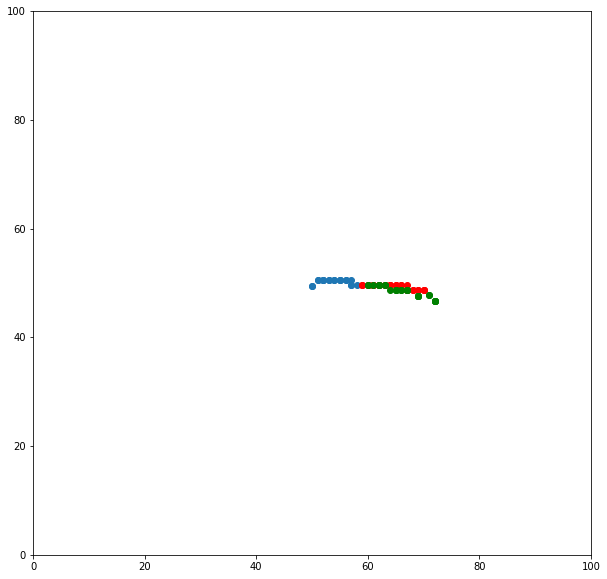

Input:  [[50, 49.5], [50, 49.5], [51, 50.51], [51, 50.51], [52, 50.52], [52, 50.52], [52, 50.52], [53, 50.53], [53, 50.53], [54, 50.54], [54, 50.54], [55, 50.55], [55, 50.55], [55, 50.55], [56, 50.56], [56, 50.56], [57, 50.57], [57, 49.57], [57, 49.57], [58, 49.58]]
Preds:  [[60, 49.6], [60, 49.6], [61, 49.61], [62, 49.62], [62, 49.62], [62, 49.62], [63, 49.63], [63, 49.63], [64, 48.64], [65, 48.65], [65, 48.65], [65, 48.65], [66, 48.66], [66, 48.66], [67, 48.67], [67, 48.67], [67, 48.67], [69, 47.69], [69, 47.69], [69, 47.69], [69, 47.69], [71, 47.71], [71, 47.71], [72, 46.72], [72, 46.72], [72, 46.72], [72, 46.72], [72, 46.72]]
Truth:  [[59, 49.59], [59, 49.59], [60, 49.6], [60, 49.6], [61, 49.61], [61, 49.61], [61, 49.61], [62, 49.62], [62, 49.62], [63, 49.63], [63, 49.63], [64, 49.64], [64, 49.64], [64, 49.64], [65, 49.65], [65, 49.65], [66, 49.66], [66, 49.66], [67, 49.67], [67, 48.67], [67, 48.67], [68, 48.68], [68, 48.68], [69, 48.69], [69, 48.69], [70, 48.7], [70, 48.7], [70, 4

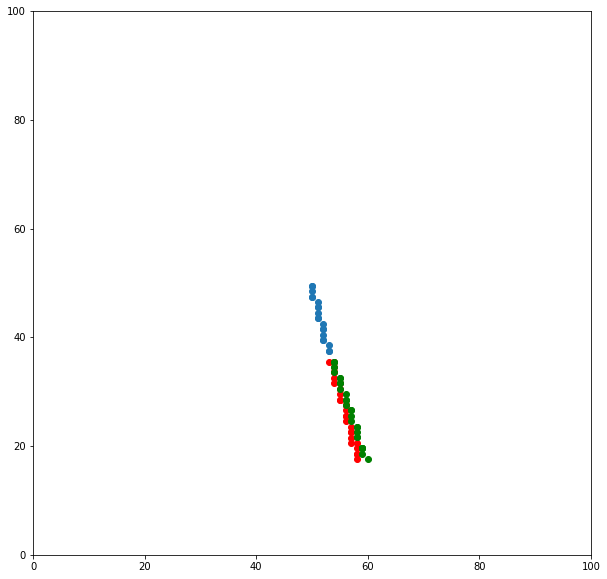

Input:  [[50, 49.5], [50, 49.5], [50, 48.5], [50, 47.5], [50, 47.5], [51, 46.51], [51, 45.51], [51, 45.51], [51, 44.51], [51, 43.51], [51, 43.51], [52, 42.52], [52, 41.52], [52, 41.52], [52, 40.52], [52, 39.52], [52, 39.52], [53, 38.53], [53, 37.53], [53, 37.53]]
Preds:  [[54, 35.54], [54, 35.54], [54, 34.54], [54, 33.54], [55, 32.55], [55, 32.55], [55, 31.55], [55, 31.55], [55, 30.55], [56, 29.56], [56, 28.56], [56, 28.56], [56, 27.56], [57, 26.57], [57, 26.57], [57, 25.57], [57, 24.57], [58, 23.58], [58, 23.58], [58, 22.58], [58, 21.58], [58, 21.58], [59, 19.59], [59, 19.59], [59, 19.59], [59, 19.59], [59, 18.59], [60, 17.6]]
Truth:  [[53, 35.53], [54, 35.54], [54, 34.54], [54, 33.54], [54, 33.54], [54, 32.54], [54, 31.54], [55, 31.55], [55, 30.55], [55, 29.55], [55, 28.55], [55, 28.55], [56, 27.56], [56, 27.56], [56, 26.56], [56, 25.56], [56, 25.56], [56, 24.56], [57, 23.57], [57, 22.57], [57, 22.57], [57, 21.57], [57, 20.57], [58, 20.58], [58, 19.58], [58, 18.58], [58, 18.58], [58,

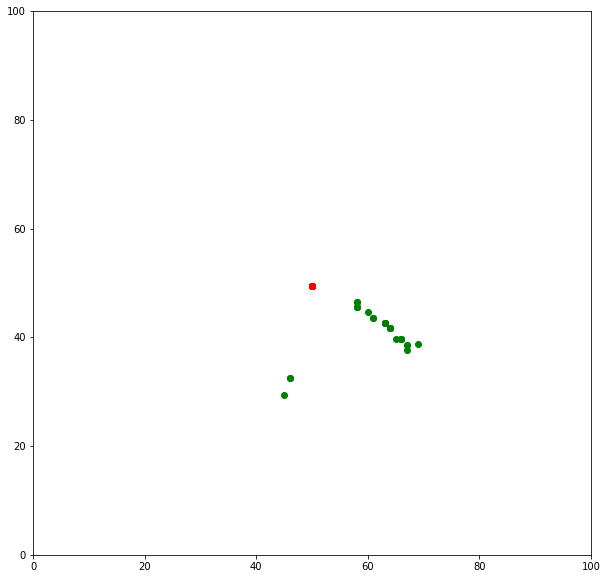

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
Preds:  [[58, 46.58], [58, 46.58], [58, 45.58], [58, 45.58], [58, 45.58], [46, 32.46], [46, 32.46], [60, 44.6], [61, 43.61], [61, 43.61], [45, 29.45], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [64, 41.64], [64, 41.64], [64, 41.64], [64, 41.64], [65, 39.65], [66, 39.66], [66, 39.66], [66, 39.66], [67, 38.67], [67, 38.67], [67, 37.67], [69, 38.69]]
Truth:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
37


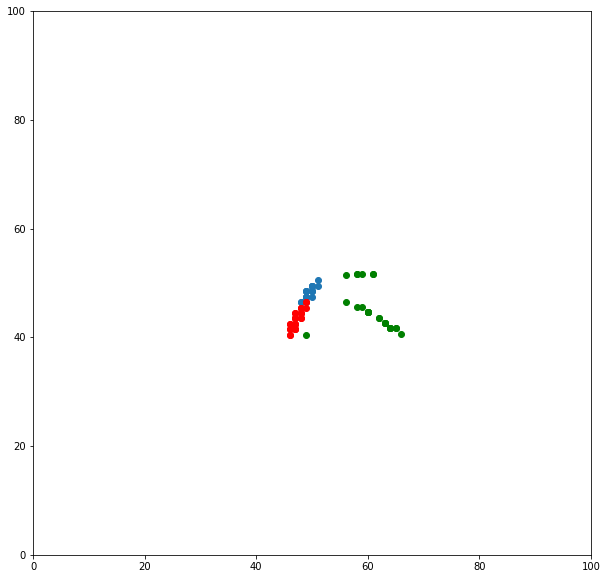

Input:  [[50, 49.5], [51, 50.51], [51, 49.51], [50, 49.5], [50, 49.5], [50, 49.5], [50, 48.5], [50, 48.5], [49, 48.49], [49, 48.49], [49, 48.49], [50, 48.5], [50, 47.5], [49, 47.49], [49, 47.49], [49, 47.49], [49, 47.49], [49, 46.49], [48, 46.48], [48, 46.48]]
Preds:  [[58, 51.58], [58, 51.58], [56, 46.56], [49, 40.49], [59, 51.59], [58, 45.58], [61, 51.61], [61, 51.61], [59, 45.59], [60, 44.6], [60, 44.6], [60, 44.6], [60, 44.6], [60, 44.6], [56, 51.56], [62, 43.62], [62, 43.62], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [64, 41.64], [64, 41.64], [64, 41.64], [64, 41.64], [65, 41.65], [65, 41.65], [66, 40.66]]
Truth:  [[49, 46.49], [49, 46.49], [49, 45.49], [48, 45.48], [48, 45.48], [48, 45.48], [48, 44.48], [48, 44.48], [47, 44.47], [47, 44.47], [48, 44.48], [48, 43.48], [48, 43.48], [47, 43.47], [47, 43.47], [47, 43.47], [47, 42.47], [47, 42.47], [46, 42.46], [46, 42.46], [47, 42.47], [47, 41.47], [47, 41.47], [47, 41.47], [46, 41.46], [46, 41.46], [46, 40.46], [46, 40.46]

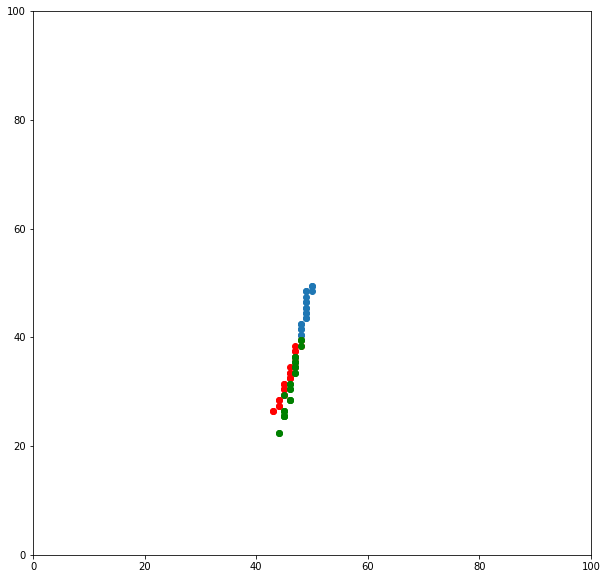

Input:  [[50, 49.5], [50, 49.5], [50, 48.5], [49, 48.49], [49, 48.49], [49, 47.49], [49, 46.49], [49, 46.49], [49, 45.49], [49, 45.49], [49, 44.49], [49, 44.49], [49, 43.49], [49, 43.49], [48, 42.48], [48, 42.48], [48, 41.48], [48, 41.48], [48, 40.48], [48, 40.48]]
Preds:  [[48, 39.48], [48, 39.48], [48, 38.48], [47, 36.47], [47, 36.47], [47, 35.47], [47, 35.47], [47, 34.47], [47, 34.47], [47, 33.47], [47, 33.47], [46, 31.46], [46, 31.46], [46, 30.46], [46, 30.46], [45, 29.45], [46, 28.46], [46, 28.46], [46, 28.46], [45, 26.45], [45, 26.45], [45, 26.45], [45, 25.45], [45, 25.45], [45, 25.45], [45, 25.45], [44, 22.44], [44, 22.44]]
Truth:  [[48, 39.48], [48, 38.48], [47, 38.47], [47, 37.47], [47, 37.47], [47, 36.47], [47, 36.47], [47, 35.47], [47, 35.47], [47, 34.47], [46, 34.46], [46, 33.46], [46, 33.46], [46, 32.46], [46, 32.46], [46, 32.46], [45, 31.45], [45, 31.45], [45, 30.45], [45, 30.45], [45, 29.45], [45, 29.45], [44, 28.44], [44, 28.44], [44, 27.44], [44, 27.44], [43, 26.43], [

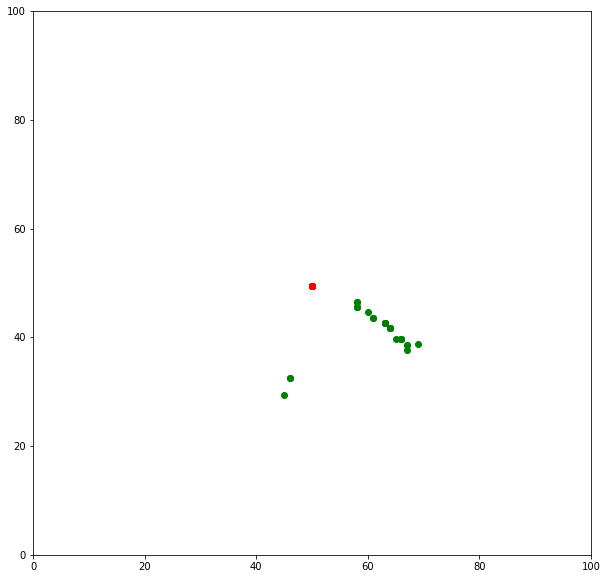

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
Preds:  [[58, 46.58], [58, 46.58], [58, 45.58], [58, 45.58], [58, 45.58], [46, 32.46], [46, 32.46], [60, 44.6], [61, 43.61], [61, 43.61], [45, 29.45], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [64, 41.64], [64, 41.64], [64, 41.64], [64, 41.64], [65, 39.65], [66, 39.66], [66, 39.66], [66, 39.66], [67, 38.67], [67, 38.67], [67, 37.67], [69, 38.69]]
Truth:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
40


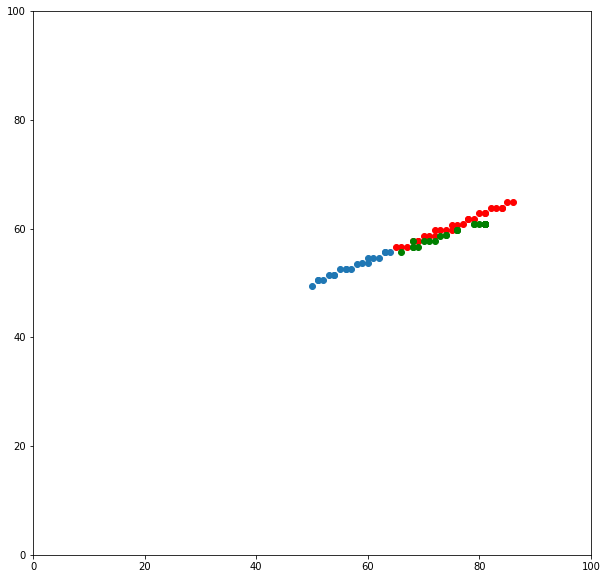

Input:  [[50, 49.5], [51, 50.51], [51, 50.51], [52, 50.52], [53, 51.53], [54, 51.54], [54, 51.54], [55, 52.55], [56, 52.56], [56, 52.56], [57, 52.57], [58, 53.58], [59, 53.59], [60, 53.6], [60, 54.6], [61, 54.61], [62, 54.62], [63, 55.63], [63, 55.63], [64, 55.64]]
Preds:  [[68, 57.68], [66, 55.66], [68, 56.68], [68, 56.68], [69, 56.69], [70, 57.7], [71, 57.71], [72, 57.72], [73, 58.73], [74, 58.74], [74, 58.74], [76, 59.76], [76, 59.76], [76, 59.76], [79, 60.79], [79, 60.79], [80, 60.8], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81]]
Truth:  [[65, 56.65], [66, 56.66], [67, 56.67], [68, 57.68], [69, 57.69], [69, 57.69], [70, 58.7], [71, 58.71], [72, 58.72], [72, 59.72], [73, 59.73], [74, 59.74], [75, 59.75], [75, 60.75], [76, 60.76], [77, 60.77], [78, 61.78], [78, 61.78], [79, 61.79], [80, 62.8], [81, 62.81], [81, 62.81], [82, 63.82], [83, 63.83], [84, 63.84], [84, 63.84], [85, 64.85], [86, 

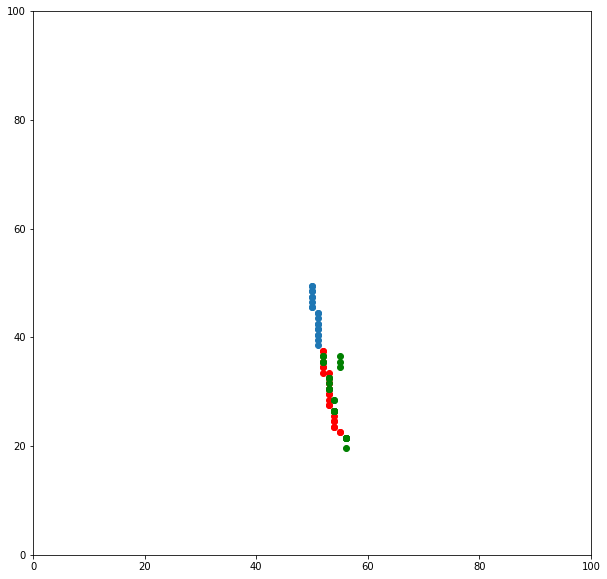

Input:  [[50, 49.5], [50, 49.5], [50, 48.5], [50, 48.5], [50, 47.5], [50, 47.5], [50, 46.5], [50, 45.5], [50, 45.5], [51, 44.51], [51, 44.51], [51, 43.51], [51, 42.51], [51, 42.51], [51, 41.51], [51, 41.51], [51, 40.51], [51, 40.51], [51, 39.51], [51, 38.51]]
Preds:  [[52, 36.52], [52, 36.52], [52, 35.52], [52, 35.52], [55, 36.55], [55, 35.55], [55, 34.55], [53, 32.53], [53, 32.53], [53, 32.53], [53, 31.53], [53, 30.53], [53, 30.53], [53, 30.53], [54, 28.54], [54, 28.54], [54, 26.54], [54, 26.54], [54, 26.54], [54, 26.54], [54, 26.54], [56, 21.56], [56, 21.56], [56, 21.56], [56, 21.56], [56, 21.56], [56, 21.56], [56, 19.56]]
Truth:  [[52, 37.52], [52, 37.52], [52, 36.52], [52, 35.52], [52, 35.52], [52, 34.52], [52, 34.52], [52, 33.52], [53, 33.53], [53, 32.53], [53, 31.53], [53, 31.53], [53, 30.53], [53, 30.53], [53, 29.53], [53, 29.53], [53, 28.53], [53, 27.53], [53, 27.53], [54, 26.54], [54, 26.54], [54, 25.54], [54, 24.54], [54, 24.54], [54, 23.54], [54, 23.54], [55, 22.55], [55, 22

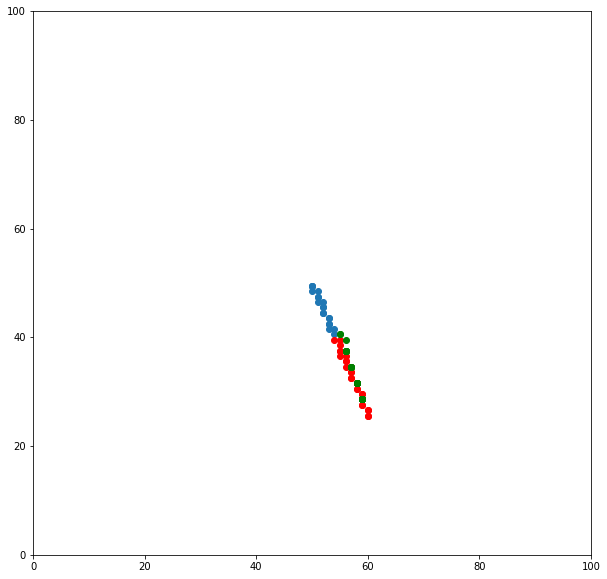

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 48.5], [51, 48.51], [51, 47.51], [51, 47.51], [51, 46.51], [52, 46.52], [52, 45.52], [52, 45.52], [52, 44.52], [52, 44.52], [53, 43.53], [53, 43.53], [53, 42.53], [53, 42.53], [53, 41.53], [54, 41.54], [54, 40.54]]
Preds:  [[56, 39.56], [55, 40.55], [55, 40.55], [56, 37.56], [56, 37.56], [56, 37.56], [56, 37.56], [56, 37.56], [57, 34.57], [57, 34.57], [57, 34.57], [57, 34.57], [58, 31.58], [58, 31.58], [58, 31.58], [58, 31.58], [58, 31.58], [58, 31.58], [59, 28.59], [59, 28.59], [59, 28.59], [59, 28.59], [59, 28.59], [59, 28.59], [59, 28.59], [59, 28.59], [59, 28.59], [59, 28.59]]
Truth:  [[54, 39.54], [55, 39.55], [55, 38.55], [55, 37.55], [55, 37.55], [55, 36.55], [56, 36.56], [56, 35.56], [56, 35.56], [56, 34.56], [57, 34.57], [57, 33.57], [57, 33.57], [57, 32.57], [57, 32.57], [58, 31.58], [58, 31.58], [58, 30.58], [58, 30.58], [59, 29.59], [59, 29.59], [59, 28.59], [59, 27.59], [59, 27.59], [60, 26.6], [60, 26.6], [60, 25.6], [60, 

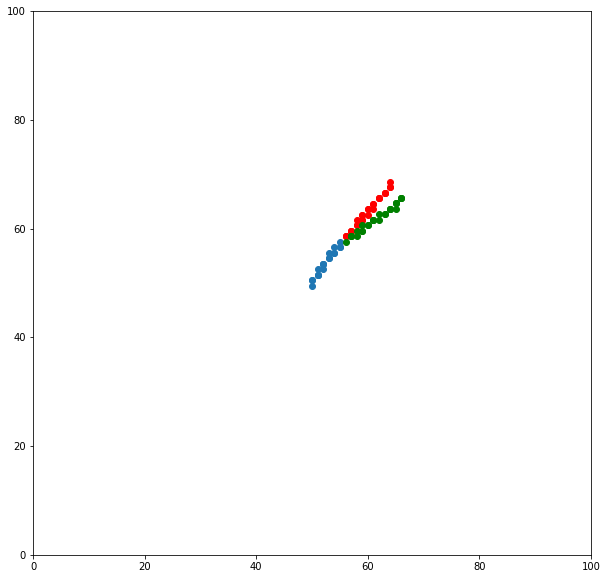

Input:  [[50, 49.5], [50, 50.5], [50, 50.5], [51, 51.51], [51, 51.51], [51, 51.51], [51, 52.51], [52, 52.52], [52, 53.52], [52, 53.52], [52, 53.52], [53, 54.53], [53, 54.53], [53, 55.53], [54, 55.54], [54, 55.54], [54, 56.54], [55, 56.55], [55, 56.55], [55, 57.55]]
Preds:  [[56, 57.56], [57, 58.57], [57, 58.57], [57, 58.57], [58, 58.58], [58, 59.58], [59, 59.59], [59, 59.59], [59, 60.59], [60, 60.6], [60, 60.6], [61, 61.61], [61, 61.61], [61, 61.61], [62, 61.62], [62, 62.62], [63, 62.63], [63, 62.63], [64, 63.64], [64, 63.64], [64, 63.64], [65, 63.65], [65, 64.65], [65, 64.65], [65, 64.65], [66, 65.66], [66, 65.66], [66, 65.66]]
Truth:  [[56, 58.56], [56, 58.56], [56, 58.56], [57, 59.57], [57, 59.57], [57, 59.57], [58, 60.58], [58, 60.58], [58, 61.58], [59, 61.59], [59, 61.59], [59, 62.59], [59, 62.59], [60, 62.6], [60, 63.6], [60, 63.6], [61, 63.61], [61, 64.61], [61, 64.61], [62, 65.62], [62, 65.62], [62, 65.62], [63, 66.63], [63, 66.63], [63, 66.63], [64, 67.64], [64, 67.64], [64, 6

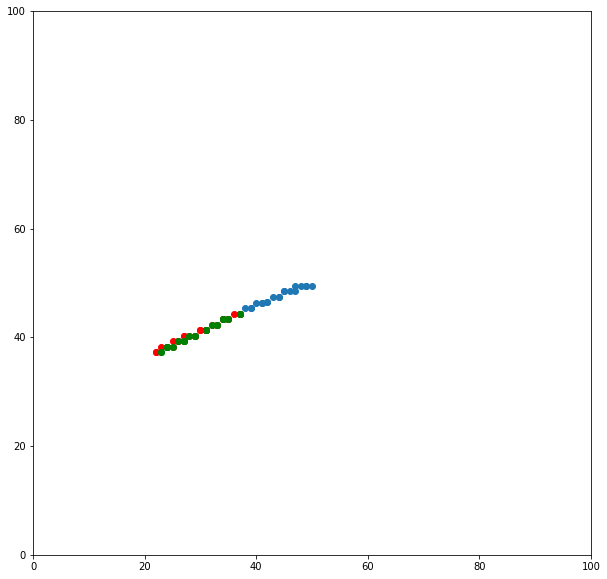

Input:  [[50, 49.5], [49, 49.49], [49, 49.49], [48, 49.48], [47, 49.47], [47, 48.47], [46, 48.46], [45, 48.45], [45, 48.45], [44, 47.44], [44, 47.44], [43, 47.43], [42, 46.42], [42, 46.42], [41, 46.41], [41, 46.41], [40, 46.4], [39, 45.39], [39, 45.39], [38, 45.38]]
Preds:  [[37, 44.37], [37, 44.37], [37, 44.37], [35, 43.35], [35, 43.35], [34, 43.34], [34, 43.34], [33, 42.33], [33, 42.33], [32, 42.32], [31, 41.31], [31, 41.31], [31, 41.31], [31, 41.31], [29, 40.29], [29, 40.29], [28, 40.28], [27, 39.27], [27, 39.27], [27, 39.27], [27, 39.27], [26, 39.26], [25, 38.25], [24, 38.24], [24, 38.24], [24, 38.24], [23, 37.23], [23, 37.23]]
Truth:  [[37, 44.37], [37, 44.37], [36, 44.36], [35, 43.35], [35, 43.35], [34, 43.34], [34, 43.34], [33, 42.33], [33, 42.33], [32, 42.32], [31, 41.31], [31, 41.31], [30, 41.3], [30, 41.3], [29, 40.29], [29, 40.29], [28, 40.28], [27, 40.27], [27, 40.27], [26, 39.26], [26, 39.26], [25, 39.25], [25, 38.25], [24, 38.24], [24, 38.24], [23, 38.23], [22, 37.22], [2

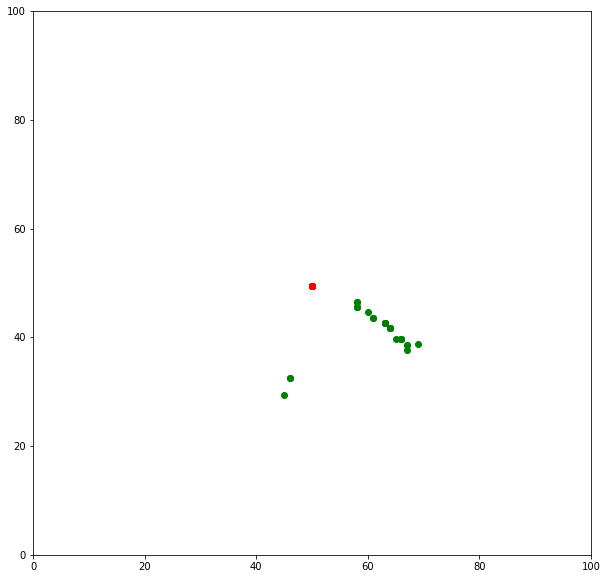

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
Preds:  [[58, 46.58], [58, 46.58], [58, 45.58], [58, 45.58], [58, 45.58], [46, 32.46], [46, 32.46], [60, 44.6], [61, 43.61], [61, 43.61], [45, 29.45], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [64, 41.64], [64, 41.64], [64, 41.64], [64, 41.64], [65, 39.65], [66, 39.66], [66, 39.66], [66, 39.66], [67, 38.67], [67, 38.67], [67, 37.67], [69, 38.69]]
Truth:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
46


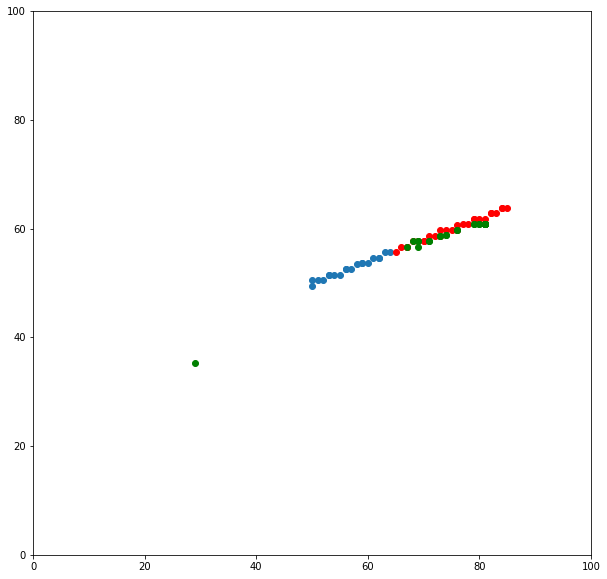

Input:  [[50, 49.5], [50, 50.5], [51, 50.51], [52, 50.52], [53, 51.53], [53, 51.53], [54, 51.54], [55, 51.55], [56, 52.56], [56, 52.56], [57, 52.57], [58, 53.58], [59, 53.59], [59, 53.59], [60, 53.6], [61, 54.61], [62, 54.62], [62, 54.62], [63, 55.63], [64, 55.64]]
Preds:  [[68, 57.68], [67, 56.67], [69, 57.69], [69, 57.69], [69, 56.69], [71, 57.71], [71, 57.71], [73, 58.73], [73, 58.73], [74, 58.74], [74, 58.74], [76, 59.76], [76, 59.76], [79, 60.79], [79, 60.79], [80, 60.8], [80, 60.8], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [29, 35.29]]
Truth:  [[65, 55.65], [66, 56.66], [67, 56.67], [67, 56.67], [68, 57.68], [69, 57.69], [70, 57.7], [70, 57.7], [71, 58.71], [72, 58.72], [73, 58.73], [73, 59.73], [74, 59.74], [75, 59.75], [76, 59.76], [76, 60.76], [77, 60.77], [78, 60.78], [79, 61.79], [79, 61.79], [80, 61.8], [81, 61.81], [82, 62.82], [82, 62.82], [83, 62.83], [84, 63.84], [84, 63.84], [85, 6

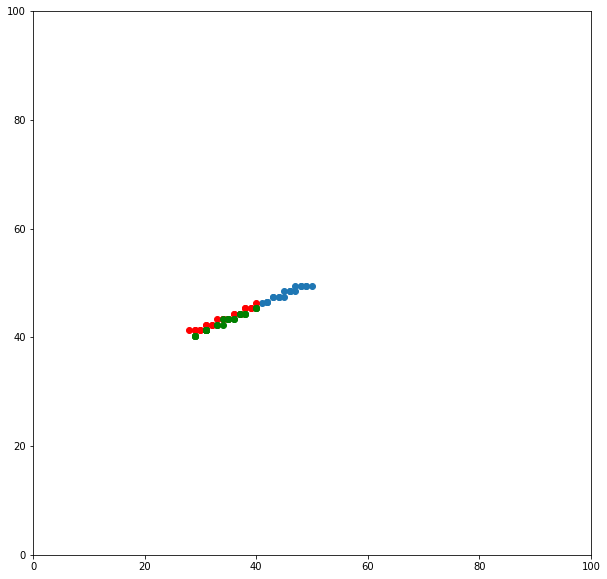

Input:  [[50, 49.5], [49, 49.49], [49, 49.49], [48, 49.48], [48, 49.48], [47, 49.47], [47, 48.47], [46, 48.46], [46, 48.46], [46, 48.46], [45, 48.45], [45, 47.45], [44, 47.44], [44, 47.44], [43, 47.43], [43, 47.43], [42, 46.42], [42, 46.42], [42, 46.42], [41, 46.41]]
Preds:  [[40, 45.4], [40, 45.4], [40, 45.4], [38, 44.38], [38, 44.38], [38, 44.38], [37, 44.37], [37, 44.37], [36, 43.36], [36, 43.36], [35, 43.35], [35, 43.35], [35, 43.35], [34, 43.34], [34, 42.34], [33, 42.33], [33, 42.33], [31, 41.31], [31, 41.31], [31, 41.31], [31, 41.31], [31, 41.31], [31, 41.31], [31, 41.31], [29, 40.29], [29, 40.29], [29, 40.29], [29, 40.29]]
Truth:  [[40, 46.4], [40, 45.4], [39, 45.39], [39, 45.39], [38, 45.38], [38, 45.38], [37, 44.37], [37, 44.37], [37, 44.37], [36, 44.36], [36, 44.36], [35, 43.35], [35, 43.35], [34, 43.34], [34, 43.34], [34, 43.34], [33, 43.33], [33, 42.33], [32, 42.32], [32, 42.32], [31, 42.31], [31, 42.31], [31, 41.31], [30, 41.3], [30, 41.3], [29, 41.29], [29, 41.29], [28, 4

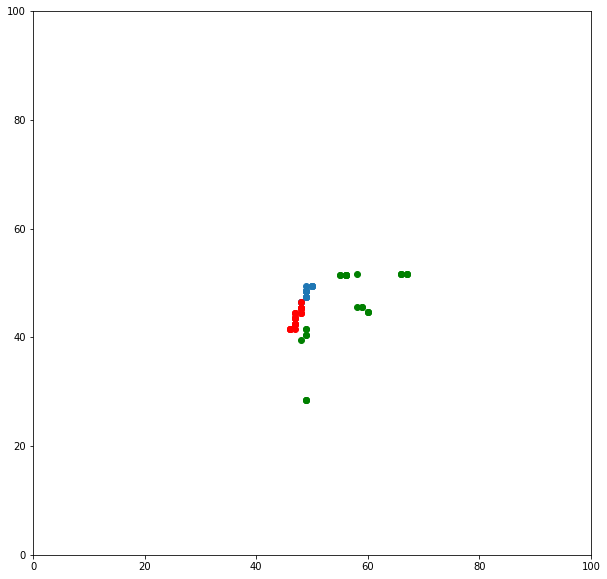

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [49, 49.49], [49, 48.49], [49, 48.49], [49, 48.49], [49, 48.49], [49, 48.49], [49, 48.49], [49, 47.49], [49, 47.49], [49, 47.49], [49, 47.49], [49, 47.49], [48, 46.48], [48, 46.48], [48, 46.48]]
Preds:  [[58, 51.58], [49, 41.49], [49, 41.49], [49, 40.49], [49, 40.49], [48, 39.48], [58, 45.58], [59, 45.59], [59, 45.59], [55, 51.55], [55, 51.55], [60, 44.6], [60, 44.6], [60, 44.6], [56, 51.56], [56, 51.56], [56, 51.56], [56, 51.56], [56, 51.56], [66, 51.66], [66, 51.66], [66, 51.66], [67, 51.67], [67, 51.67], [67, 51.67], [49, 28.49], [49, 28.49], [49, 28.49]]
Truth:  [[48, 46.48], [48, 45.48], [48, 45.48], [48, 45.48], [48, 45.48], [48, 45.48], [48, 45.48], [48, 44.48], [48, 44.48], [48, 44.48], [47, 44.47], [47, 44.47], [47, 44.47], [47, 43.47], [47, 43.47], [47, 43.47], [47, 43.47], [47, 43.47], [47, 42.47], [47, 42.47], [47, 42.47], [47, 42.47], [47, 42.47], [47, 41.47], [46, 41.46], [46, 41.46], [46, 41.46], [46, 4

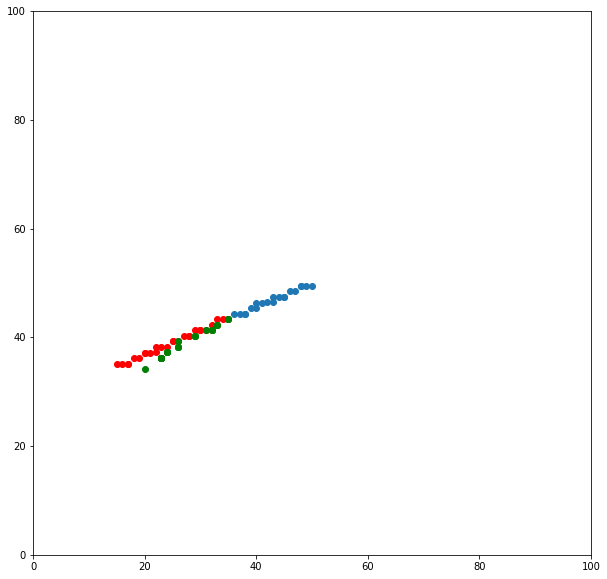

Input:  [[50, 49.5], [49, 49.49], [48, 49.48], [48, 49.48], [47, 48.47], [46, 48.46], [45, 47.45], [45, 47.45], [44, 47.44], [43, 47.43], [43, 46.43], [42, 46.42], [41, 46.41], [40, 46.4], [40, 45.4], [39, 45.39], [38, 44.38], [38, 44.38], [37, 44.37], [36, 44.36]]
Preds:  [[35, 43.35], [35, 43.35], [33, 42.33], [33, 42.33], [32, 41.32], [32, 41.32], [32, 41.32], [31, 41.31], [29, 40.29], [29, 40.29], [29, 40.29], [26, 39.26], [26, 38.26], [26, 38.26], [26, 38.26], [24, 37.24], [24, 37.24], [24, 37.24], [24, 37.24], [23, 36.23], [23, 36.23], [23, 36.23], [23, 36.23], [23, 36.23], [23, 36.23], [23, 36.23], [23, 36.23], [20, 34.2]]
Truth:  [[35, 43.35], [34, 43.34], [33, 43.33], [33, 42.33], [32, 42.32], [31, 41.31], [30, 41.3], [30, 41.3], [29, 41.29], [28, 40.28], [28, 40.28], [27, 40.27], [26, 39.26], [25, 39.25], [25, 39.25], [24, 38.24], [23, 38.23], [22, 38.22], [22, 37.22], [21, 37.21], [20, 37.2], [20, 37.2], [19, 36.19], [18, 36.18], [17, 35.17], [17, 35.17], [16, 35.16], [15, 3

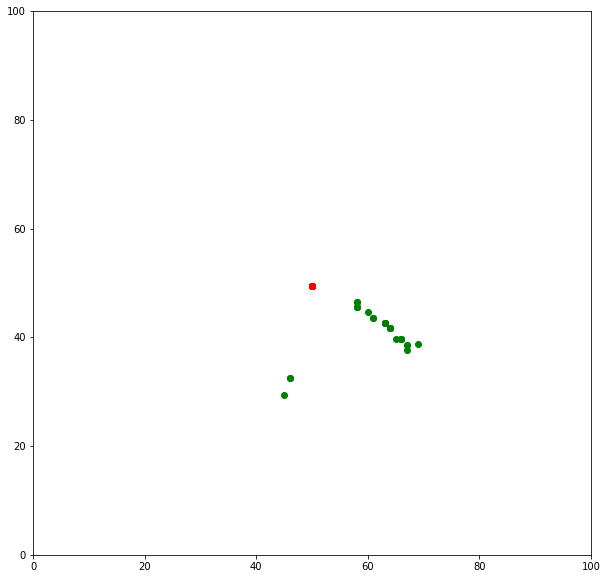

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
Preds:  [[58, 46.58], [58, 46.58], [58, 45.58], [58, 45.58], [58, 45.58], [46, 32.46], [46, 32.46], [60, 44.6], [61, 43.61], [61, 43.61], [45, 29.45], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [64, 41.64], [64, 41.64], [64, 41.64], [64, 41.64], [65, 39.65], [66, 39.66], [66, 39.66], [66, 39.66], [67, 38.67], [67, 38.67], [67, 37.67], [69, 38.69]]
Truth:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
51


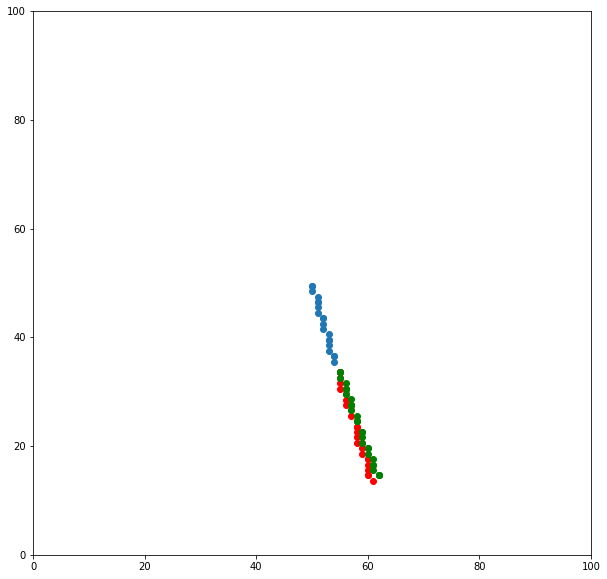

Input:  [[50, 49.5], [50, 49.5], [50, 48.5], [51, 47.51], [51, 46.51], [51, 46.51], [51, 45.51], [51, 44.51], [52, 43.52], [52, 43.52], [52, 42.52], [52, 41.52], [53, 40.53], [53, 39.53], [53, 39.53], [53, 38.53], [53, 37.53], [54, 36.54], [54, 36.54], [54, 35.54]]
Preds:  [[55, 33.55], [55, 33.55], [55, 32.55], [56, 31.56], [56, 30.56], [56, 30.56], [56, 29.56], [57, 28.57], [57, 27.57], [57, 27.57], [57, 26.57], [58, 25.58], [58, 24.58], [58, 24.58], [59, 22.59], [59, 22.59], [59, 21.59], [59, 20.59], [60, 19.6], [60, 19.6], [60, 18.6], [61, 17.61], [61, 16.61], [61, 16.61], [61, 15.61], [62, 14.62], [62, 14.62], [62, 14.62]]
Truth:  [[55, 33.55], [55, 33.55], [55, 32.55], [55, 31.55], [55, 30.55], [56, 30.56], [56, 29.56], [56, 28.56], [56, 27.56], [57, 27.57], [57, 26.57], [57, 25.57], [58, 24.58], [58, 23.58], [58, 23.58], [58, 22.58], [58, 21.58], [58, 20.58], [59, 20.59], [59, 19.59], [59, 18.59], [60, 17.6], [60, 17.6], [60, 16.6], [60, 15.6], [60, 14.6], [60, 14.6], [61, 13.61

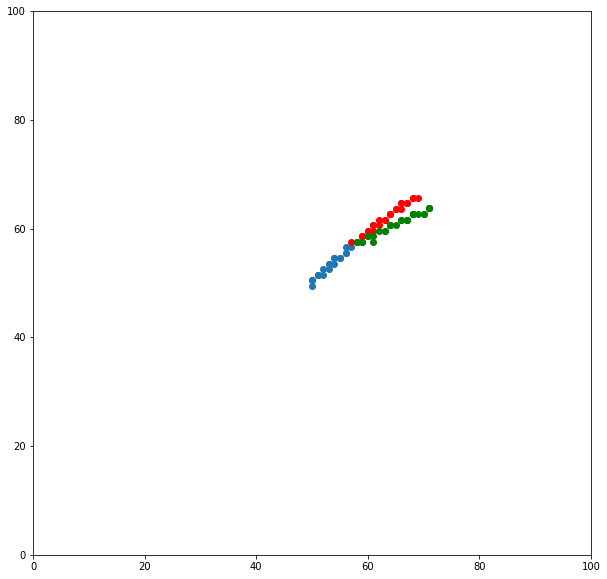

Input:  [[50, 49.5], [50, 50.5], [50, 50.5], [51, 51.51], [51, 51.51], [51, 51.51], [52, 51.52], [52, 52.52], [53, 52.53], [53, 53.53], [53, 53.53], [54, 53.54], [54, 54.54], [54, 54.54], [55, 54.55], [55, 54.55], [56, 55.56], [56, 55.56], [56, 56.56], [57, 56.57]]
Preds:  [[61, 57.61], [59, 57.59], [59, 57.59], [58, 57.58], [60, 58.6], [60, 58.6], [61, 58.61], [63, 59.63], [63, 59.63], [62, 59.62], [64, 60.64], [64, 60.64], [64, 60.64], [65, 60.65], [66, 61.66], [66, 61.66], [67, 61.67], [67, 61.67], [67, 61.67], [68, 62.68], [68, 62.68], [68, 62.68], [69, 62.69], [70, 62.7], [70, 62.7], [71, 63.71], [71, 63.71], [71, 63.71]]
Truth:  [[57, 57.57], [58, 57.58], [58, 57.58], [59, 58.59], [59, 58.59], [59, 58.59], [60, 59.6], [60, 59.6], [61, 59.61], [61, 60.61], [61, 60.61], [62, 60.62], [62, 61.62], [63, 61.63], [63, 61.63], [64, 62.64], [64, 62.64], [64, 62.64], [65, 63.65], [65, 63.65], [66, 63.66], [66, 64.66], [66, 64.66], [67, 64.67], [67, 64.67], [68, 65.68], [68, 65.68], [69, 65

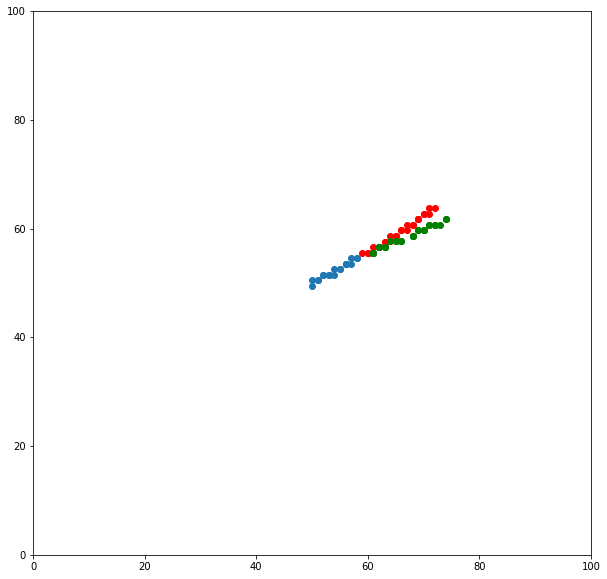

Input:  [[50, 49.5], [50, 50.5], [51, 50.51], [51, 50.51], [52, 51.52], [52, 51.52], [53, 51.53], [53, 51.53], [53, 51.53], [54, 51.54], [54, 52.54], [55, 52.55], [55, 52.55], [56, 53.56], [56, 53.56], [56, 53.56], [57, 53.57], [57, 54.57], [58, 54.58], [58, 54.58]]
Preds:  [[61, 55.61], [61, 55.61], [61, 55.61], [62, 56.62], [62, 56.62], [63, 56.63], [63, 56.63], [63, 56.63], [64, 57.64], [65, 57.65], [65, 57.65], [66, 57.66], [66, 57.66], [68, 58.68], [68, 58.68], [68, 58.68], [69, 59.69], [69, 59.69], [70, 59.7], [70, 59.7], [70, 59.7], [71, 60.71], [71, 60.71], [72, 60.72], [72, 60.72], [73, 60.73], [74, 61.74], [74, 61.74]]
Truth:  [[59, 55.59], [60, 55.6], [60, 55.6], [61, 55.61], [61, 56.61], [62, 56.62], [62, 56.62], [63, 57.63], [63, 57.63], [64, 57.64], [64, 58.64], [65, 58.65], [65, 58.65], [65, 58.65], [66, 59.66], [66, 59.66], [67, 59.67], [67, 60.67], [68, 60.68], [68, 60.68], [69, 61.69], [69, 61.69], [69, 61.69], [70, 62.7], [70, 62.7], [71, 62.71], [71, 63.71], [72, 63

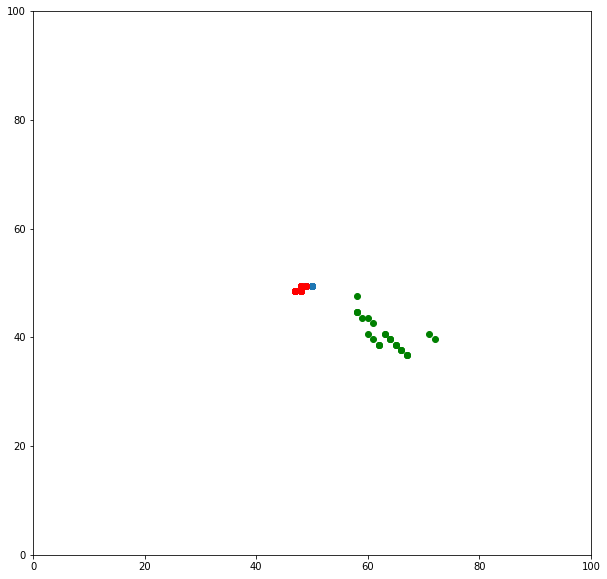

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [49, 49.49], [49, 49.49], [49, 49.49], [49, 49.49], [49, 49.49], [49, 49.49], [49, 49.49], [49, 49.49], [49, 49.49], [49, 49.49]]
Preds:  [[58, 47.58], [58, 44.58], [58, 44.58], [58, 44.58], [59, 43.59], [60, 43.6], [60, 40.6], [61, 42.61], [61, 39.61], [62, 38.62], [62, 38.62], [62, 38.62], [63, 40.63], [63, 40.63], [64, 39.64], [64, 39.64], [64, 39.64], [65, 38.65], [65, 38.65], [65, 38.65], [66, 37.66], [66, 37.66], [66, 37.66], [67, 36.67], [67, 36.67], [67, 36.67], [71, 40.71], [72, 39.72]]
Truth:  [[49, 49.49], [49, 49.49], [49, 49.49], [48, 49.48], [48, 49.48], [48, 49.48], [48, 49.48], [48, 49.48], [48, 49.48], [48, 49.48], [48, 48.48], [48, 48.48], [48, 48.48], [48, 48.48], [48, 48.48], [48, 48.48], [48, 48.48], [48, 48.48], [47, 48.47], [47, 48.47], [47, 48.47], [47, 48.47], [47, 48.47], [47, 48.47], [47, 48.47], [47, 48.47], [47, 48.47], [47, 48.47

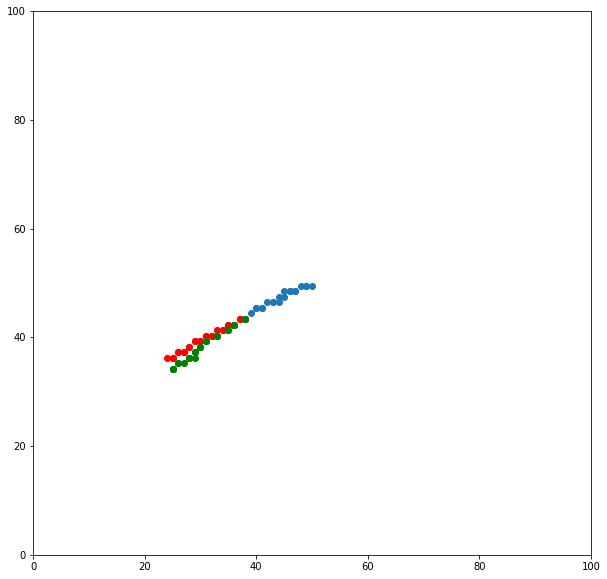

Input:  [[50, 49.5], [49, 49.49], [49, 49.49], [48, 49.48], [47, 48.47], [47, 48.47], [46, 48.46], [46, 48.46], [45, 48.45], [45, 47.45], [44, 47.44], [44, 46.44], [43, 46.43], [43, 46.43], [42, 46.42], [41, 45.41], [41, 45.41], [40, 45.4], [40, 45.4], [39, 44.39]]
Preds:  [[38, 43.38], [38, 43.38], [36, 42.36], [36, 42.36], [36, 42.36], [35, 41.35], [35, 41.35], [33, 40.33], [33, 40.33], [33, 40.33], [31, 39.31], [31, 39.31], [31, 39.31], [30, 38.3], [30, 38.3], [30, 38.3], [29, 37.29], [29, 37.29], [28, 36.28], [28, 36.28], [29, 36.29], [28, 36.28], [26, 35.26], [26, 35.26], [27, 35.27], [25, 34.25], [25, 34.25], [25, 34.25]]
Truth:  [[38, 43.38], [38, 43.38], [37, 43.37], [37, 43.37], [36, 42.36], [36, 42.36], [35, 42.35], [35, 42.35], [34, 41.34], [34, 41.34], [33, 41.33], [32, 40.32], [32, 40.32], [31, 40.31], [31, 40.31], [30, 39.3], [30, 39.3], [29, 39.29], [29, 39.29], [28, 38.28], [28, 38.28], [27, 37.27], [27, 37.27], [26, 37.26], [26, 37.26], [25, 36.25], [25, 36.25], [24, 3

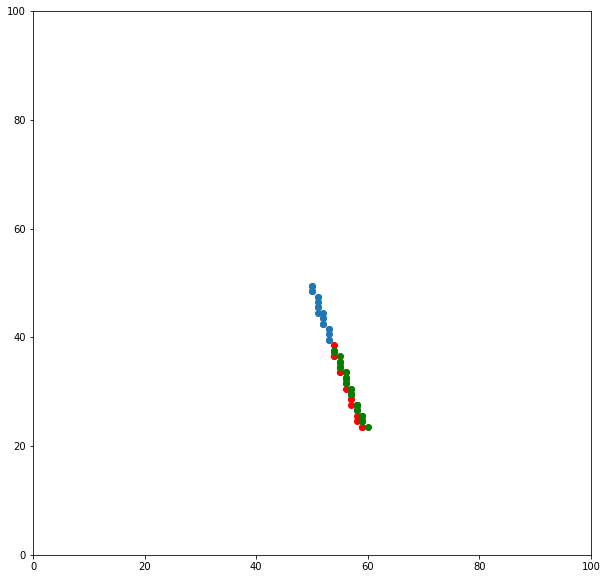

Input:  [[50, 49.5], [50, 49.5], [50, 48.5], [50, 48.5], [51, 47.51], [51, 47.51], [51, 46.51], [51, 45.51], [51, 45.51], [51, 44.51], [52, 44.52], [52, 43.52], [52, 43.52], [52, 42.52], [52, 42.52], [53, 41.53], [53, 41.53], [53, 40.53], [53, 39.53], [53, 39.53]]
Preds:  [[54, 37.54], [54, 37.54], [54, 37.54], [55, 36.55], [55, 35.55], [55, 35.55], [55, 34.55], [55, 34.55], [56, 33.56], [56, 33.56], [56, 32.56], [56, 32.56], [56, 31.56], [57, 30.57], [57, 30.57], [57, 29.57], [57, 29.57], [57, 29.57], [58, 27.58], [58, 27.58], [58, 27.58], [58, 26.58], [59, 25.59], [59, 25.59], [59, 25.59], [59, 24.59], [59, 24.59], [60, 23.6]]
Truth:  [[54, 38.54], [54, 37.54], [54, 37.54], [54, 36.54], [54, 36.54], [55, 35.55], [55, 34.55], [55, 34.55], [55, 33.55], [55, 33.55], [56, 32.56], [56, 32.56], [56, 31.56], [56, 31.56], [56, 30.56], [57, 29.57], [57, 29.57], [57, 28.57], [57, 28.57], [57, 27.57], [58, 27.58], [58, 26.58], [58, 26.58], [58, 25.58], [58, 24.58], [59, 24.59], [59, 23.59], [59

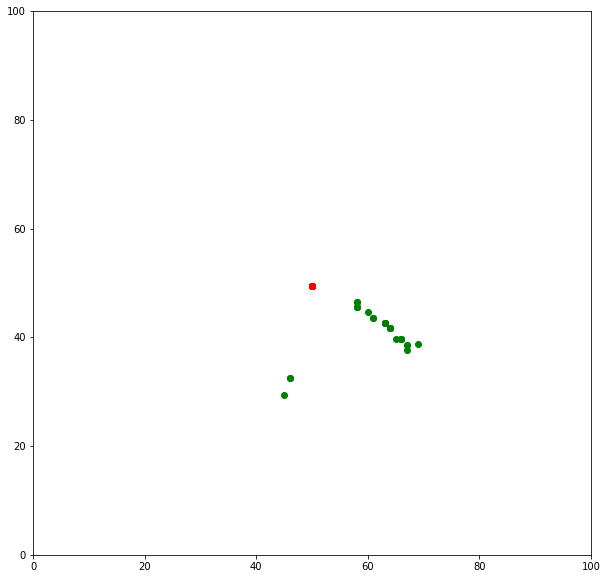

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
Preds:  [[58, 46.58], [58, 46.58], [58, 45.58], [58, 45.58], [58, 45.58], [46, 32.46], [46, 32.46], [60, 44.6], [61, 43.61], [61, 43.61], [45, 29.45], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [64, 41.64], [64, 41.64], [64, 41.64], [64, 41.64], [65, 39.65], [66, 39.66], [66, 39.66], [66, 39.66], [67, 38.67], [67, 38.67], [67, 37.67], [69, 38.69]]
Truth:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
58


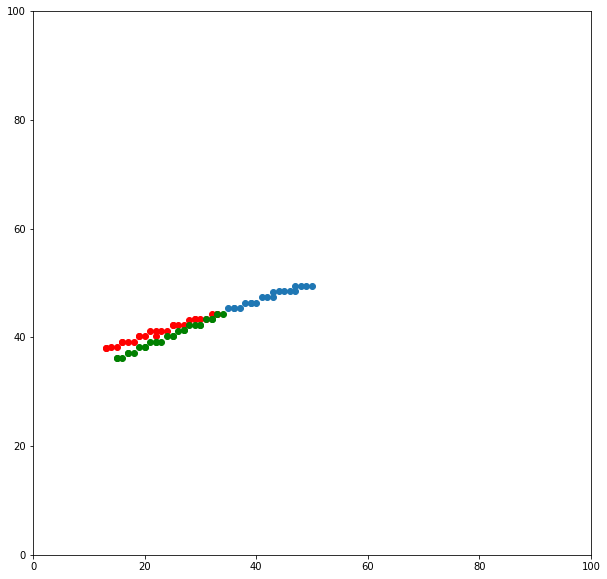

Input:  [[50, 49.5], [49, 49.49], [48, 49.48], [47, 49.47], [47, 48.47], [46, 48.46], [45, 48.45], [44, 48.44], [43, 48.43], [43, 47.43], [42, 47.42], [41, 47.41], [40, 46.4], [39, 46.39], [39, 46.39], [38, 46.38], [37, 45.37], [36, 45.36], [36, 45.36], [35, 45.35]]
Preds:  [[34, 44.34], [33, 44.33], [32, 43.32], [32, 43.32], [31, 43.31], [30, 42.3], [30, 42.3], [29, 42.29], [28, 42.28], [27, 41.27], [27, 41.27], [26, 41.26], [25, 40.25], [25, 40.25], [24, 40.24], [23, 39.23], [22, 39.22], [22, 39.22], [21, 39.21], [20, 38.2], [20, 38.2], [19, 38.19], [18, 37.18], [17, 37.17], [17, 37.17], [16, 36.16], [15, 36.15], [15, 36.15]]
Truth:  [[33, 44.33], [33, 44.33], [32, 44.32], [31, 43.31], [30, 43.3], [29, 43.29], [29, 43.29], [28, 43.28], [27, 42.27], [26, 42.26], [25, 42.25], [25, 42.25], [24, 41.24], [23, 41.23], [22, 41.22], [22, 40.22], [21, 41.21], [20, 40.2], [19, 40.19], [19, 40.19], [18, 39.18], [17, 39.17], [16, 39.16], [16, 39.16], [15, 38.15], [14, 38.14], [13, 38.13], [13, 3

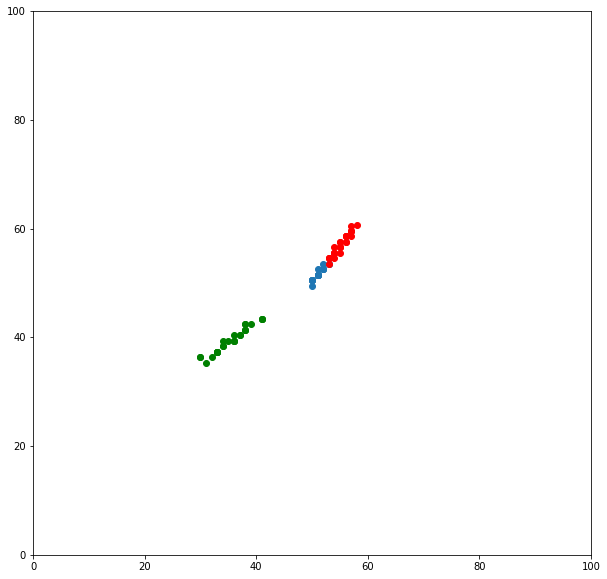

Input:  [[50, 49.5], [50, 50.5], [50, 50.5], [50, 50.5], [50, 50.5], [50, 50.5], [51, 51.51], [51, 51.51], [51, 51.51], [51, 51.51], [51, 51.51], [51, 51.51], [51, 52.51], [52, 52.52], [52, 52.52], [52, 52.52], [52, 52.52], [52, 53.52], [53, 53.53], [53, 53.53]]
Preds:  [[41, 43.41], [41, 43.41], [41, 43.41], [39, 42.39], [38, 42.38], [38, 42.38], [38, 41.38], [38, 41.38], [38, 41.38], [37, 40.37], [37, 40.37], [36, 40.36], [36, 39.36], [36, 39.36], [36, 39.36], [35, 39.35], [34, 39.34], [34, 38.34], [34, 38.34], [33, 37.33], [33, 37.33], [33, 37.33], [33, 37.33], [33, 37.33], [32, 36.32], [30, 36.3], [30, 36.3], [31, 35.31]]
Truth:  [[53, 53.53], [53, 54.53], [53, 54.53], [53, 54.53], [54, 54.54], [54, 55.54], [54, 55.54], [54, 55.54], [54, 55.54], [55, 55.55], [54, 56.54], [55, 56.55], [55, 56.55], [55, 56.55], [55, 57.55], [55, 57.55], [56, 57.56], [56, 57.56], [56, 58.56], [56, 58.56], [56, 58.56], [56, 58.56], [57, 58.57], [57, 59.57], [57, 59.57], [57, 59.57], [57, 60.57], [58, 6

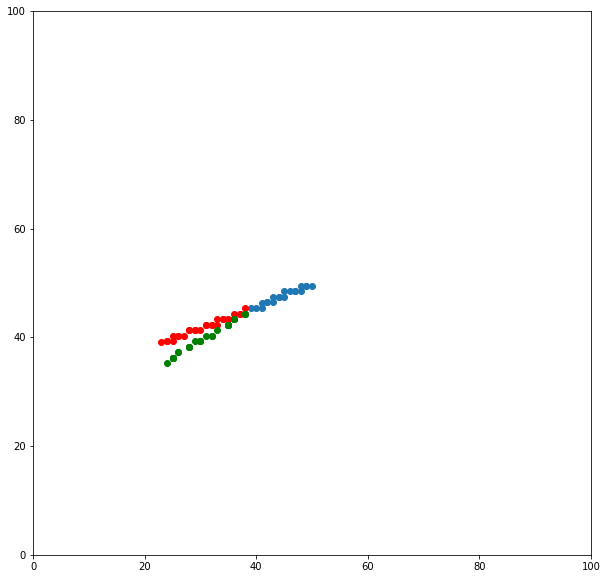

Input:  [[50, 49.5], [49, 49.49], [49, 49.49], [48, 49.48], [48, 48.48], [47, 48.47], [47, 48.47], [46, 48.46], [45, 48.45], [45, 47.45], [44, 47.44], [44, 47.44], [43, 47.43], [43, 46.43], [42, 46.42], [42, 46.42], [41, 46.41], [41, 45.41], [40, 45.4], [39, 45.39]]
Preds:  [[38, 44.38], [38, 44.38], [36, 43.36], [36, 43.36], [36, 43.36], [35, 42.35], [35, 42.35], [35, 42.35], [35, 42.35], [35, 42.35], [33, 41.33], [32, 40.32], [32, 40.32], [31, 40.31], [30, 39.3], [30, 39.3], [30, 39.3], [29, 39.29], [28, 38.28], [28, 38.28], [28, 38.28], [26, 37.26], [26, 37.26], [25, 36.25], [25, 36.25], [25, 36.25], [25, 36.25], [24, 35.24]]
Truth:  [[38, 45.38], [38, 44.38], [37, 44.37], [37, 44.37], [36, 44.36], [36, 43.36], [35, 43.35], [34, 43.34], [34, 43.34], [33, 43.33], [33, 42.33], [32, 42.32], [32, 42.32], [31, 42.31], [31, 42.31], [30, 41.3], [29, 41.29], [29, 41.29], [28, 41.28], [28, 41.28], [27, 40.27], [26, 40.26], [26, 40.26], [25, 40.25], [25, 39.25], [24, 39.24], [24, 39.24], [23,

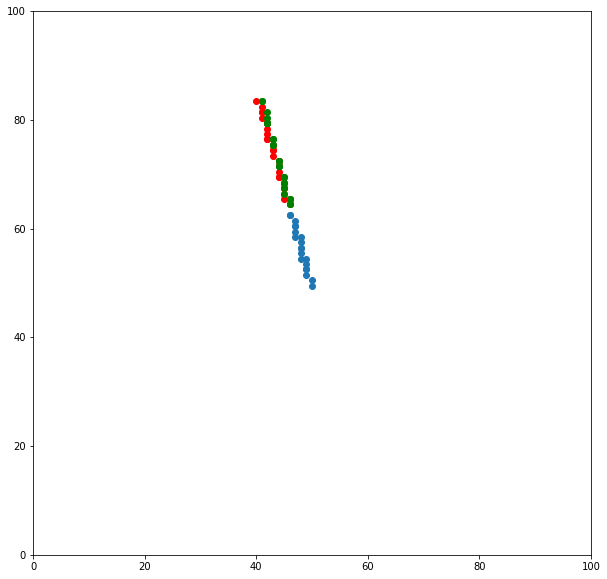

Input:  [[50, 49.5], [50, 50.5], [49, 51.49], [49, 52.49], [49, 52.49], [49, 53.49], [49, 54.49], [48, 54.48], [48, 55.48], [48, 56.48], [48, 56.48], [48, 57.48], [48, 58.48], [47, 58.47], [47, 59.47], [47, 60.47], [47, 60.47], [47, 61.47], [46, 62.46], [46, 62.46]]
Preds:  [[46, 64.46], [46, 64.46], [46, 65.46], [46, 65.46], [45, 66.45], [45, 67.45], [45, 68.45], [45, 68.45], [45, 69.45], [45, 69.45], [44, 71.44], [44, 71.44], [44, 71.44], [44, 72.44], [44, 72.44], [43, 75.43], [43, 75.43], [43, 75.43], [43, 76.43], [43, 76.43], [42, 79.42], [42, 79.42], [42, 79.42], [42, 79.42], [42, 80.42], [42, 81.42], [41, 83.41], [41, 83.41]]
Truth:  [[46, 64.46], [46, 65.46], [45, 65.45], [45, 66.45], [45, 67.45], [45, 67.45], [45, 68.45], [44, 69.44], [44, 69.44], [44, 70.44], [44, 71.44], [44, 72.44], [44, 72.44], [43, 73.43], [43, 74.43], [43, 74.43], [43, 75.43], [42, 76.42], [42, 76.42], [42, 77.42], [42, 78.42], [42, 79.42], [42, 79.42], [41, 80.41], [41, 81.41], [41, 81.41], [41, 82.41], 

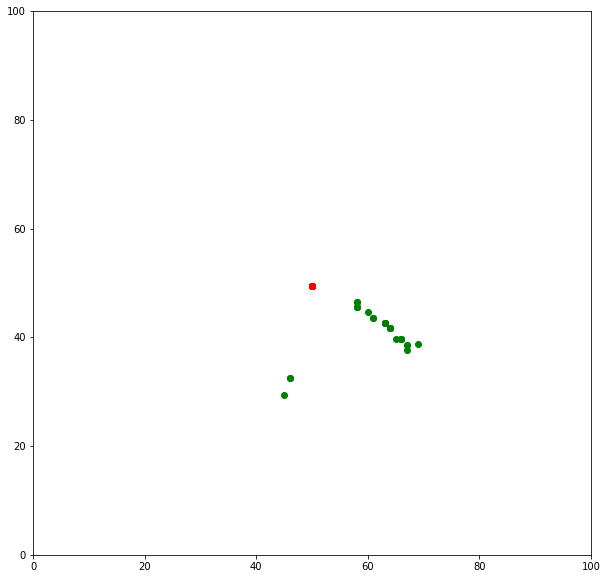

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
Preds:  [[58, 46.58], [58, 46.58], [58, 45.58], [58, 45.58], [58, 45.58], [46, 32.46], [46, 32.46], [60, 44.6], [61, 43.61], [61, 43.61], [45, 29.45], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [64, 41.64], [64, 41.64], [64, 41.64], [64, 41.64], [65, 39.65], [66, 39.66], [66, 39.66], [66, 39.66], [67, 38.67], [67, 38.67], [67, 37.67], [69, 38.69]]
Truth:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
63


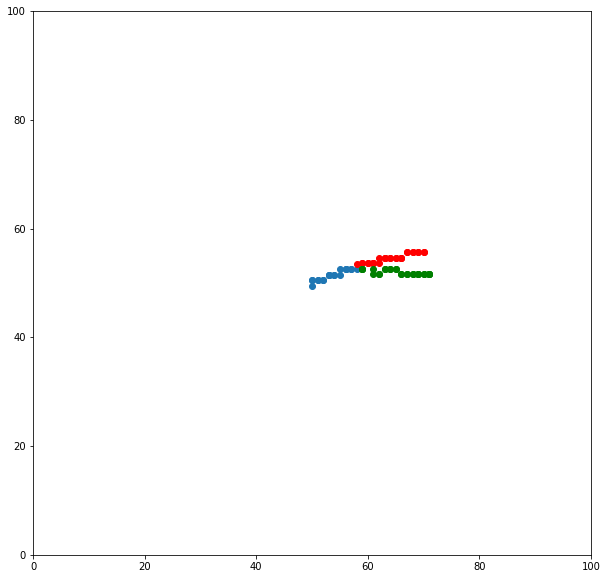

Input:  [[50, 49.5], [50, 50.5], [50, 50.5], [51, 50.51], [51, 50.51], [52, 50.52], [52, 50.52], [53, 51.53], [53, 51.53], [53, 51.53], [54, 51.54], [54, 51.54], [55, 51.55], [55, 52.55], [56, 52.56], [56, 52.56], [56, 52.56], [57, 52.57], [57, 52.57], [58, 52.58]]
Preds:  [[59, 52.59], [59, 52.59], [59, 52.59], [61, 52.61], [61, 51.61], [62, 51.62], [62, 51.62], [63, 52.63], [63, 52.63], [64, 52.64], [64, 52.64], [65, 52.65], [65, 52.65], [66, 51.66], [66, 51.66], [67, 51.67], [67, 51.67], [68, 51.68], [68, 51.68], [69, 51.69], [69, 51.69], [69, 51.69], [70, 51.7], [70, 51.7], [71, 51.71], [71, 51.71], [71, 51.71], [71, 51.71]]
Truth:  [[58, 53.58], [59, 53.59], [59, 53.59], [60, 53.6], [60, 53.6], [61, 53.61], [61, 53.61], [61, 53.61], [62, 53.62], [62, 54.62], [63, 54.63], [63, 54.63], [63, 54.63], [64, 54.64], [64, 54.64], [65, 54.65], [65, 54.65], [66, 54.66], [66, 54.66], [66, 54.66], [67, 55.67], [67, 55.67], [68, 55.68], [68, 55.68], [69, 55.69], [69, 55.69], [70, 55.7], [70, 5

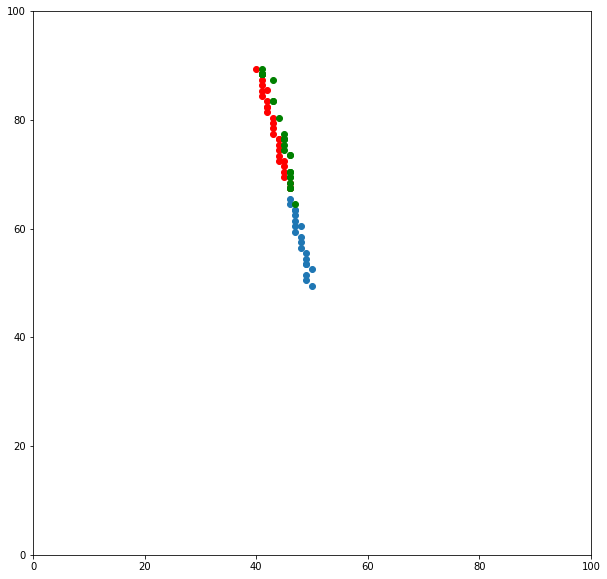

Input:  [[50, 49.5], [49, 50.49], [49, 51.49], [50, 52.5], [49, 53.49], [49, 53.49], [49, 54.49], [49, 55.49], [48, 56.48], [48, 57.48], [48, 58.48], [47, 59.47], [47, 60.47], [48, 60.48], [47, 61.47], [47, 62.47], [47, 63.47], [47, 63.47], [46, 64.46], [46, 65.46]]
Preds:  [[47, 64.47], [46, 67.46], [46, 67.46], [46, 67.46], [46, 68.46], [46, 69.46], [46, 69.46], [46, 70.46], [46, 70.46], [46, 70.46], [45, 74.45], [46, 73.46], [46, 73.46], [45, 75.45], [45, 76.45], [45, 76.45], [45, 76.45], [45, 77.45], [44, 80.44], [43, 83.43], [43, 83.43], [41, 88.41], [41, 88.41], [41, 88.41], [41, 88.41], [41, 88.41], [41, 89.41], [43, 87.43]]
Truth:  [[46, 67.46], [46, 67.46], [46, 68.46], [45, 69.45], [45, 70.45], [45, 71.45], [45, 72.45], [44, 72.44], [44, 73.44], [44, 74.44], [44, 75.44], [44, 76.44], [44, 76.44], [43, 77.43], [43, 78.43], [43, 79.43], [43, 80.43], [42, 81.42], [42, 82.42], [42, 82.42], [42, 83.42], [41, 84.41], [42, 85.42], [41, 85.41], [41, 86.41], [41, 87.41], [41, 88.41], 

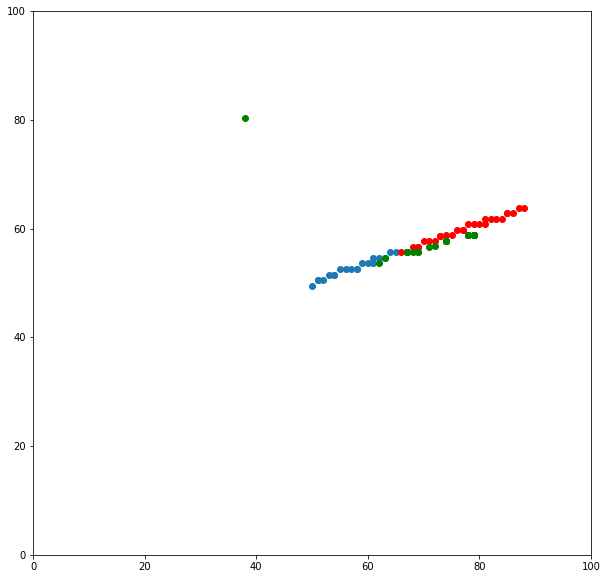

Input:  [[50, 49.5], [51, 50.51], [51, 50.51], [52, 50.52], [53, 51.53], [54, 51.54], [54, 51.54], [55, 52.55], [56, 52.56], [57, 52.57], [58, 52.58], [58, 52.58], [59, 53.59], [60, 53.6], [61, 53.61], [61, 54.61], [62, 54.62], [63, 54.63], [64, 55.64], [65, 55.65]]
Preds:  [[62, 53.62], [63, 54.63], [67, 55.67], [67, 55.67], [67, 55.67], [68, 55.68], [69, 55.69], [69, 55.69], [71, 56.71], [72, 56.72], [74, 57.74], [74, 57.74], [74, 57.74], [74, 57.74], [78, 58.78], [78, 58.78], [78, 58.78], [78, 58.78], [78, 58.78], [78, 58.78], [79, 58.79], [79, 58.79], [79, 58.79], [79, 58.79], [79, 58.79], [79, 58.79], [79, 58.79], [38, 80.38]]
Truth:  [[66, 55.66], [67, 55.67], [68, 56.68], [69, 56.69], [69, 56.69], [70, 57.7], [71, 57.71], [72, 57.72], [73, 58.73], [73, 58.73], [74, 58.74], [75, 58.75], [76, 59.76], [77, 59.77], [77, 59.77], [78, 60.78], [79, 60.79], [80, 60.8], [81, 61.81], [81, 60.81], [82, 61.82], [83, 61.83], [84, 61.84], [85, 62.85], [85, 62.85], [86, 62.86], [87, 63.87], [8

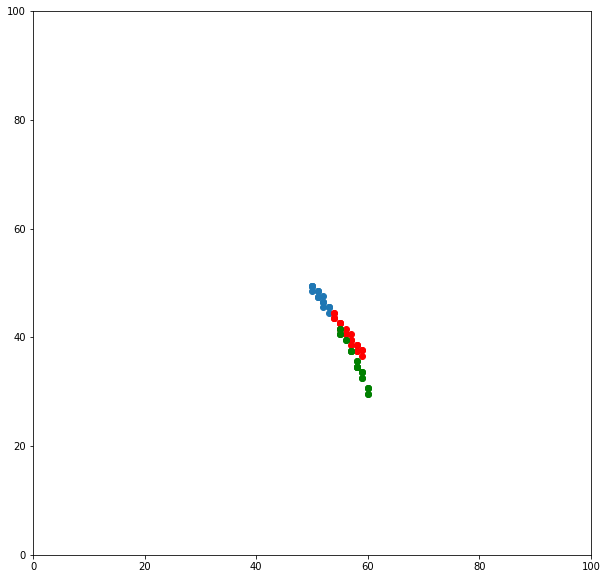

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 48.5], [51, 48.51], [51, 48.51], [51, 48.51], [51, 47.51], [51, 47.51], [51, 47.51], [52, 47.52], [52, 46.52], [52, 46.52], [52, 46.52], [52, 45.52], [53, 45.53], [53, 45.53], [53, 45.53], [53, 44.53]]
Preds:  [[55, 41.55], [55, 41.55], [55, 40.55], [55, 40.55], [55, 40.55], [56, 39.56], [56, 39.56], [57, 37.57], [57, 37.57], [57, 37.57], [57, 37.57], [58, 35.58], [58, 35.58], [58, 34.58], [58, 34.58], [58, 34.58], [58, 34.58], [58, 34.58], [59, 33.59], [59, 33.59], [59, 33.59], [59, 32.59], [59, 32.59], [60, 30.6], [60, 30.6], [60, 30.6], [60, 29.6], [60, 29.6]]
Truth:  [[54, 44.54], [54, 44.54], [54, 43.54], [54, 43.54], [54, 43.54], [55, 42.55], [55, 42.55], [55, 42.55], [55, 42.55], [55, 41.55], [55, 41.55], [56, 41.56], [56, 40.56], [56, 40.56], [56, 40.56], [57, 40.57], [57, 39.57], [57, 39.57], [57, 39.57], [57, 38.57], [58, 38.58], [58, 38.58], [58, 38.58], [58, 37.58], [58, 37.58], [59, 37.59], [59, 37.59], [59, 36.

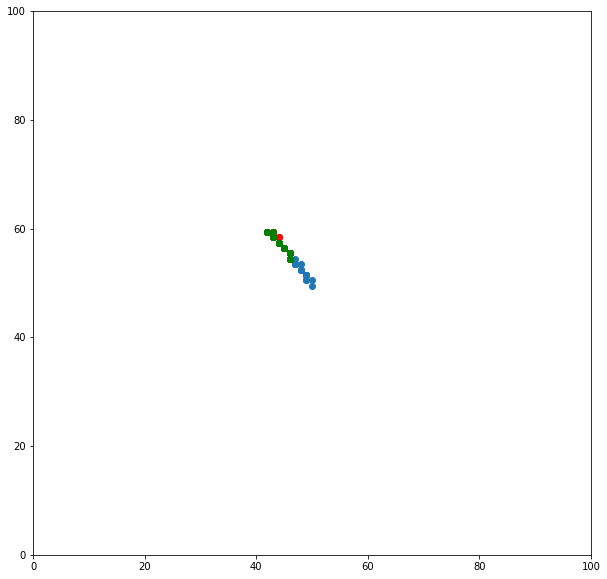

Input:  [[50, 49.5], [50, 50.5], [49, 50.49], [49, 50.49], [49, 51.49], [49, 51.49], [49, 51.49], [49, 51.49], [49, 51.49], [48, 52.48], [48, 52.48], [48, 52.48], [48, 52.48], [48, 53.48], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 53.47], [47, 54.47]]
Preds:  [[46, 54.46], [46, 54.46], [46, 54.46], [46, 54.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [45, 56.45], [45, 56.45], [45, 56.45], [45, 56.45], [45, 56.45], [44, 57.44], [44, 57.44], [44, 57.44], [44, 57.44], [44, 57.44], [44, 57.44], [43, 58.43], [43, 58.43], [43, 58.43], [43, 58.43], [43, 58.43], [43, 59.43], [42, 59.42], [42, 59.42], [42, 59.42]]
Truth:  [[46, 54.46], [46, 54.46], [46, 55.46], [46, 55.46], [46, 55.46], [46, 55.46], [45, 56.45], [45, 56.45], [45, 56.45], [45, 56.45], [45, 56.45], [45, 56.45], [44, 57.44], [44, 57.44], [44, 57.44], [44, 57.44], [44, 58.44], [44, 58.44], [43, 58.43], [43, 58.43], [43, 58.43], [43, 58.43], [43, 59.43], [43, 59.43], [43, 59.43], [43, 59.43], [42, 59.42], 

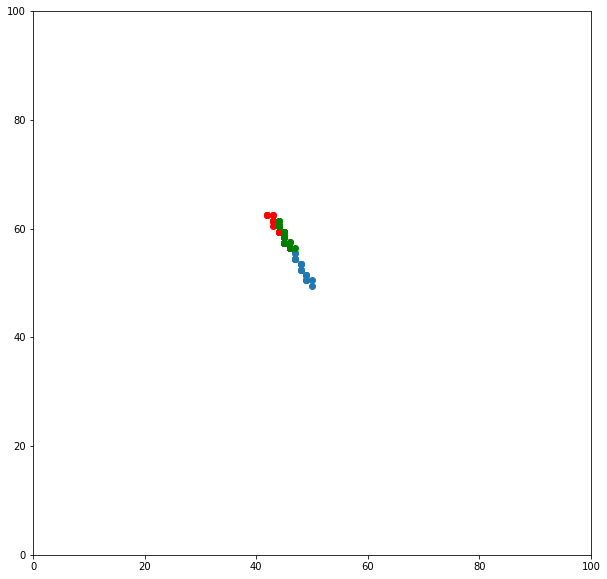

Input:  [[50, 49.5], [50, 50.5], [49, 50.49], [49, 50.49], [49, 50.49], [49, 51.49], [49, 51.49], [49, 51.49], [48, 52.48], [48, 52.48], [48, 52.48], [48, 53.48], [48, 53.48], [48, 53.48], [47, 54.47], [47, 54.47], [47, 54.47], [47, 54.47], [47, 55.47], [47, 55.47]]
Preds:  [[46, 56.46], [47, 56.47], [46, 56.46], [46, 56.46], [46, 56.46], [46, 56.46], [46, 57.46], [45, 57.45], [45, 57.45], [45, 57.45], [45, 57.45], [45, 58.45], [45, 58.45], [45, 58.45], [45, 58.45], [45, 59.45], [45, 59.45], [45, 59.45], [45, 59.45], [45, 59.45], [45, 59.45], [44, 60.44], [44, 60.44], [44, 60.44], [44, 60.44], [44, 61.44], [44, 61.44], [44, 61.44]]
Truth:  [[46, 56.46], [46, 56.46], [46, 56.46], [46, 56.46], [46, 57.46], [45, 57.45], [45, 57.45], [45, 57.45], [45, 58.45], [45, 58.45], [45, 58.45], [44, 59.44], [44, 59.44], [44, 59.44], [44, 59.44], [44, 60.44], [44, 60.44], [44, 60.44], [43, 60.43], [43, 61.43], [43, 61.43], [43, 61.43], [43, 61.43], [43, 62.43], [43, 62.43], [42, 62.42], [42, 62.42], 

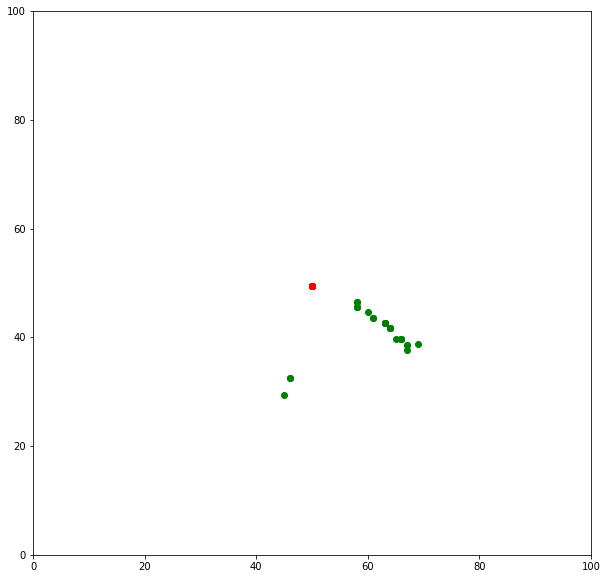

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
Preds:  [[58, 46.58], [58, 46.58], [58, 45.58], [58, 45.58], [58, 45.58], [46, 32.46], [46, 32.46], [60, 44.6], [61, 43.61], [61, 43.61], [45, 29.45], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [64, 41.64], [64, 41.64], [64, 41.64], [64, 41.64], [65, 39.65], [66, 39.66], [66, 39.66], [66, 39.66], [67, 38.67], [67, 38.67], [67, 37.67], [69, 38.69]]
Truth:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
70


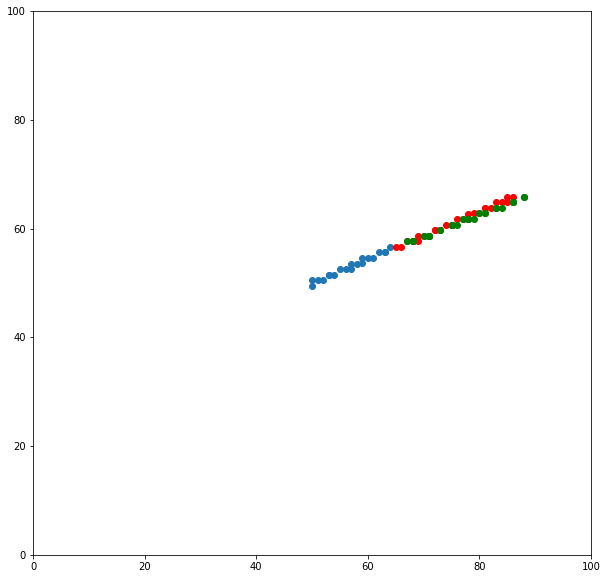

Input:  [[50, 49.5], [50, 50.5], [51, 50.51], [52, 50.52], [53, 51.53], [53, 51.53], [54, 51.54], [55, 52.55], [56, 52.56], [57, 52.57], [57, 53.57], [58, 53.58], [59, 53.59], [59, 54.59], [60, 54.6], [61, 54.61], [62, 55.62], [63, 55.63], [63, 55.63], [64, 56.64]]
Preds:  [[67, 57.67], [68, 57.68], [68, 57.68], [68, 57.68], [70, 58.7], [71, 58.71], [71, 58.71], [71, 58.71], [73, 59.73], [73, 59.73], [75, 60.75], [75, 60.75], [76, 60.76], [77, 61.77], [78, 61.78], [78, 61.78], [79, 61.79], [80, 62.8], [81, 62.81], [81, 62.81], [83, 63.83], [83, 63.83], [84, 63.84], [86, 64.86], [86, 64.86], [86, 64.86], [88, 65.88], [88, 65.88]]
Truth:  [[65, 56.65], [66, 56.66], [67, 57.67], [68, 57.68], [69, 57.69], [69, 58.69], [70, 58.7], [71, 58.71], [72, 59.72], [72, 59.72], [73, 59.73], [74, 60.74], [75, 60.75], [75, 60.75], [76, 61.76], [77, 61.77], [78, 61.78], [78, 62.78], [79, 62.79], [80, 62.8], [81, 63.81], [81, 63.81], [82, 63.82], [83, 64.83], [84, 64.84], [85, 64.85], [85, 65.85], [86, 

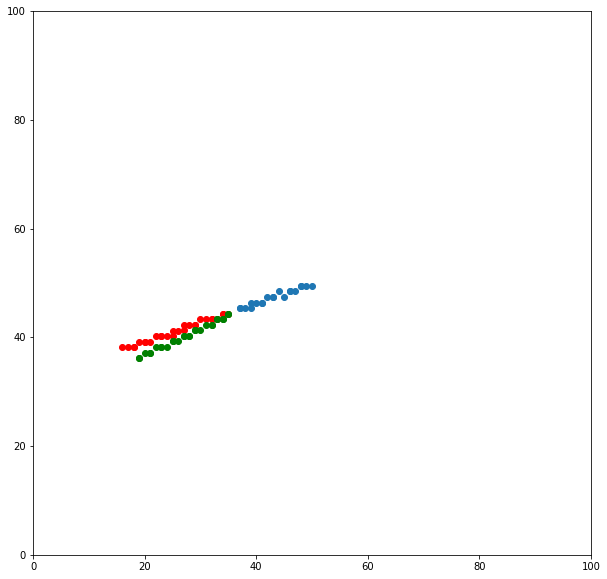

Input:  [[50, 49.5], [49, 49.49], [48, 49.48], [48, 49.48], [47, 48.47], [46, 48.46], [46, 48.46], [45, 47.45], [44, 48.44], [43, 47.43], [43, 47.43], [42, 47.42], [41, 46.41], [41, 46.41], [40, 46.4], [39, 46.39], [39, 45.39], [38, 45.38], [37, 45.37], [37, 45.37]]
Preds:  [[35, 44.35], [35, 44.35], [34, 43.34], [34, 43.34], [33, 43.33], [33, 43.33], [32, 42.32], [32, 42.32], [31, 42.31], [30, 41.3], [29, 41.29], [29, 41.29], [28, 40.28], [28, 40.28], [27, 40.27], [27, 40.27], [26, 39.26], [25, 39.25], [25, 39.25], [24, 38.24], [23, 38.23], [23, 38.23], [22, 38.22], [21, 37.21], [21, 37.21], [20, 37.2], [19, 36.19], [19, 36.19]]
Truth:  [[35, 44.35], [34, 44.34], [34, 44.34], [33, 43.33], [32, 43.32], [32, 43.32], [31, 43.31], [30, 43.3], [29, 42.29], [29, 42.29], [28, 42.28], [27, 42.27], [27, 41.27], [26, 41.26], [25, 41.25], [25, 40.25], [24, 40.24], [23, 40.23], [23, 40.23], [22, 40.22], [21, 39.21], [20, 39.2], [20, 39.2], [19, 39.19], [18, 38.18], [18, 38.18], [17, 38.17], [16, 

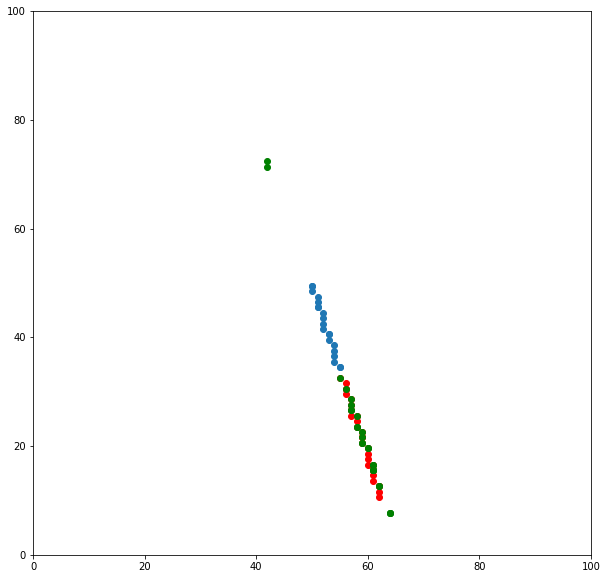

Input:  [[50, 49.5], [50, 49.5], [50, 48.5], [51, 47.51], [51, 46.51], [51, 45.51], [51, 45.51], [52, 44.52], [52, 43.52], [52, 42.52], [52, 41.52], [53, 40.53], [53, 40.53], [53, 39.53], [54, 38.54], [54, 37.54], [54, 36.54], [54, 35.54], [55, 34.55], [55, 34.55]]
Preds:  [[55, 32.55], [56, 30.56], [42, 71.42], [42, 72.42], [57, 28.57], [57, 27.57], [57, 26.57], [57, 26.57], [58, 25.58], [58, 23.58], [58, 23.58], [59, 22.59], [59, 21.59], [59, 20.59], [59, 20.59], [60, 19.6], [60, 19.6], [61, 16.61], [61, 16.61], [61, 15.61], [61, 15.61], [61, 15.61], [61, 15.61], [62, 12.62], [62, 12.62], [64, 7.64], [64, 7.64], [64, 7.64]]
Truth:  [[55, 32.55], [56, 31.56], [56, 30.56], [56, 30.56], [56, 29.56], [57, 28.57], [57, 27.57], [57, 26.57], [57, 25.57], [58, 25.58], [58, 24.58], [58, 23.58], [59, 22.59], [59, 21.59], [59, 21.59], [59, 20.59], [60, 19.6], [60, 18.6], [60, 17.6], [60, 16.6], [61, 16.61], [61, 15.61], [61, 14.61], [61, 13.61], [62, 12.62], [62, 12.62], [62, 11.62], [62, 10.62

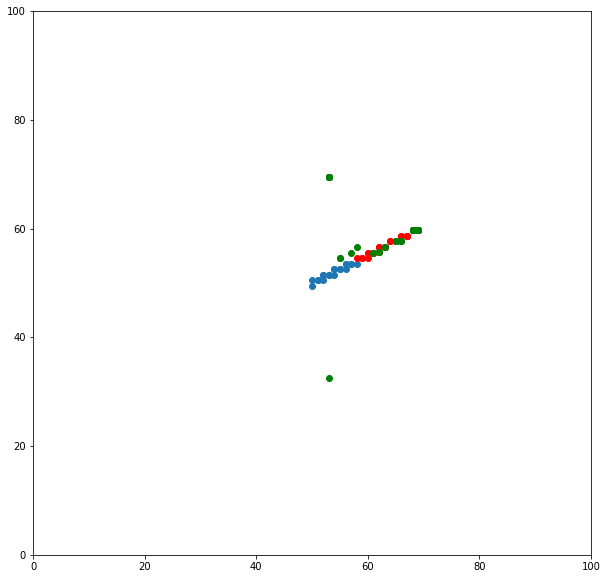

Input:  [[50, 49.5], [50, 50.5], [51, 50.51], [51, 50.51], [52, 50.52], [52, 51.52], [52, 51.52], [53, 51.53], [53, 51.53], [54, 51.54], [54, 52.54], [54, 52.54], [55, 52.55], [55, 52.55], [56, 52.56], [56, 53.56], [56, 53.56], [57, 53.57], [57, 53.57], [58, 53.58]]
Preds:  [[57, 55.57], [55, 54.55], [55, 54.55], [58, 56.58], [61, 55.61], [62, 55.62], [62, 55.62], [63, 56.63], [53, 32.53], [65, 57.65], [65, 57.65], [65, 57.65], [66, 57.66], [66, 57.66], [68, 59.68], [68, 59.68], [68, 59.68], [69, 59.69], [69, 59.69], [69, 59.69], [69, 59.69], [69, 59.69], [69, 59.69], [69, 59.69], [53, 69.53], [53, 69.53], [53, 69.53], [53, 69.53]]
Truth:  [[58, 54.58], [59, 54.59], [59, 54.59], [60, 54.6], [60, 55.6], [60, 55.6], [61, 55.61], [61, 55.61], [62, 55.62], [62, 56.62], [62, 56.62], [63, 56.63], [63, 56.63], [63, 56.63], [64, 57.64], [64, 57.64], [65, 57.65], [65, 57.65], [65, 57.65], [66, 58.66], [66, 58.66], [67, 58.67], [67, 58.67], [67, 58.67], [68, 59.68], [68, 59.68], [68, 59.68], [69

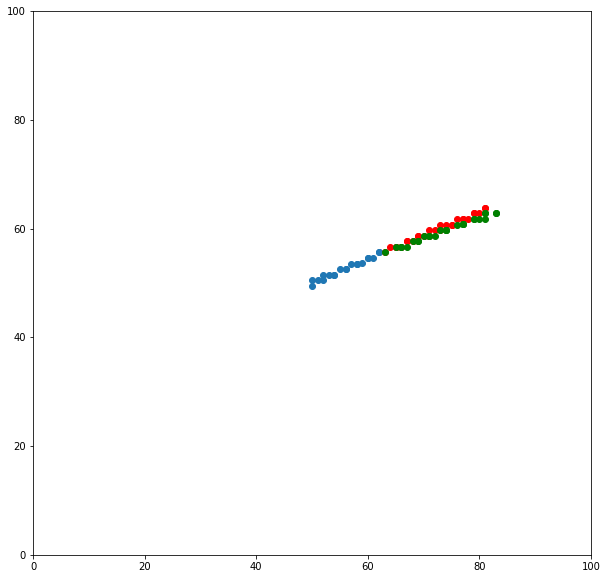

Input:  [[50, 49.5], [50, 50.5], [51, 50.51], [52, 50.52], [52, 51.52], [53, 51.53], [54, 51.54], [54, 51.54], [55, 52.55], [56, 52.56], [56, 52.56], [57, 53.57], [58, 53.58], [58, 53.58], [59, 53.59], [60, 54.6], [60, 54.6], [61, 54.61], [62, 55.62], [62, 55.62]]
Preds:  [[63, 55.63], [65, 56.65], [66, 56.66], [66, 56.66], [67, 56.67], [68, 57.68], [69, 57.69], [69, 57.69], [70, 58.7], [71, 58.71], [71, 58.71], [72, 58.72], [73, 59.73], [74, 59.74], [74, 59.74], [74, 59.74], [76, 60.76], [77, 60.77], [77, 60.77], [77, 60.77], [79, 61.79], [79, 61.79], [80, 61.8], [81, 62.81], [81, 62.81], [81, 61.81], [83, 62.83], [83, 62.83]]
Truth:  [[63, 55.63], [64, 56.64], [65, 56.65], [65, 56.65], [66, 56.66], [67, 57.67], [67, 57.67], [68, 57.68], [69, 58.69], [69, 58.69], [70, 58.7], [71, 58.71], [71, 59.71], [72, 59.72], [73, 59.73], [73, 60.73], [74, 60.74], [75, 60.75], [75, 60.75], [76, 61.76], [77, 61.77], [77, 61.77], [78, 61.78], [79, 62.79], [79, 62.79], [80, 62.8], [81, 63.81], [81, 6

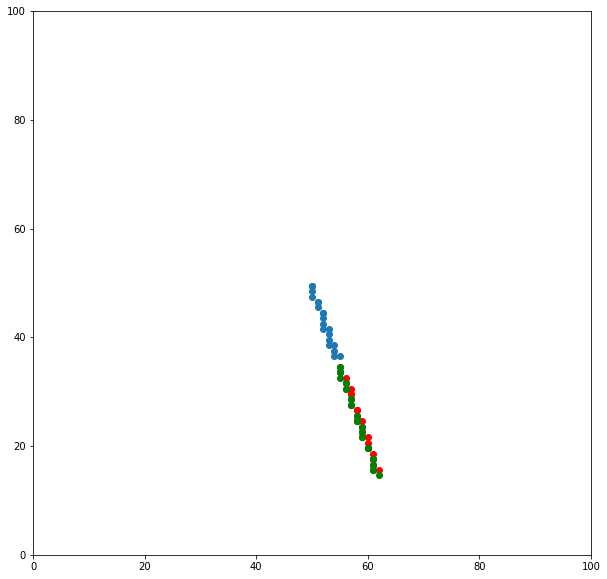

Input:  [[50, 49.5], [50, 49.5], [50, 48.5], [50, 47.5], [51, 46.51], [51, 46.51], [51, 45.51], [52, 44.52], [52, 44.52], [52, 43.52], [52, 42.52], [52, 41.52], [53, 41.53], [53, 40.53], [53, 39.53], [53, 38.53], [54, 38.54], [54, 37.54], [54, 36.54], [55, 36.55]]
Preds:  [[55, 34.55], [55, 33.55], [55, 33.55], [55, 32.55], [56, 31.56], [56, 30.56], [56, 30.56], [57, 28.57], [57, 28.57], [57, 27.57], [57, 27.57], [58, 25.58], [58, 25.58], [58, 24.58], [58, 24.58], [59, 23.59], [59, 22.59], [59, 21.59], [59, 21.59], [60, 19.6], [60, 19.6], [60, 19.6], [61, 17.61], [61, 17.61], [61, 16.61], [61, 15.61], [61, 15.61], [62, 14.62]]
Truth:  [[55, 34.55], [55, 33.55], [55, 33.55], [56, 32.56], [56, 31.56], [56, 31.56], [57, 30.57], [57, 29.57], [57, 29.57], [57, 28.57], [57, 27.57], [58, 26.58], [58, 26.58], [58, 25.58], [58, 24.58], [59, 24.59], [59, 23.59], [59, 22.59], [59, 22.59], [60, 21.6], [60, 20.6], [60, 19.6], [60, 19.6], [61, 18.61], [61, 17.61], [61, 16.61], [61, 16.61], [62, 15.6

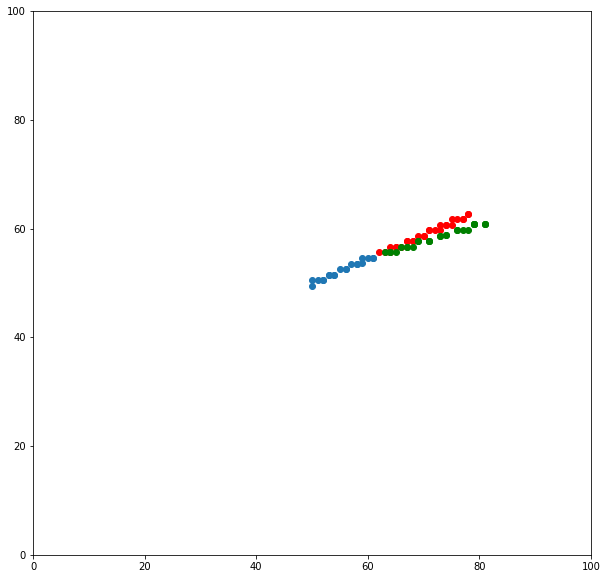

Input:  [[50, 49.5], [50, 50.5], [51, 50.51], [52, 50.52], [52, 50.52], [53, 51.53], [53, 51.53], [54, 51.54], [54, 51.54], [55, 52.55], [56, 52.56], [56, 52.56], [57, 53.57], [58, 53.58], [58, 53.58], [59, 53.59], [59, 54.59], [60, 54.6], [61, 54.61], [61, 54.61]]
Preds:  [[63, 55.63], [64, 55.64], [64, 55.64], [65, 55.65], [66, 56.66], [67, 56.67], [67, 56.67], [68, 56.68], [69, 57.69], [69, 57.69], [71, 57.71], [71, 57.71], [71, 57.71], [73, 58.73], [73, 58.73], [74, 58.74], [74, 58.74], [76, 59.76], [76, 59.76], [77, 59.77], [78, 59.78], [79, 60.79], [79, 60.79], [79, 60.79], [79, 60.79], [81, 60.81], [81, 60.81], [81, 60.81]]
Truth:  [[62, 55.62], [63, 55.63], [64, 55.64], [64, 56.64], [65, 56.65], [65, 56.65], [66, 56.66], [67, 57.67], [67, 57.67], [68, 57.68], [68, 57.68], [69, 58.69], [70, 58.7], [70, 58.7], [71, 59.71], [71, 59.71], [72, 59.72], [73, 59.73], [73, 60.73], [74, 60.74], [74, 60.74], [75, 60.75], [75, 61.75], [76, 61.76], [77, 61.77], [77, 61.77], [78, 62.78], [78

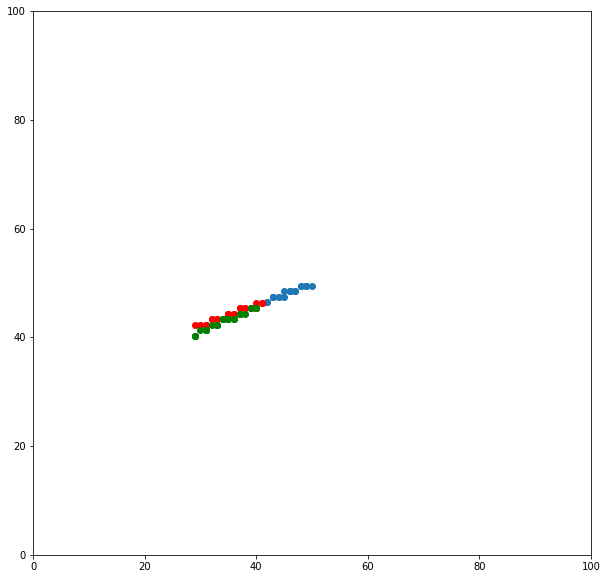

Input:  [[50, 49.5], [49, 49.49], [49, 49.49], [49, 49.49], [48, 49.48], [48, 49.48], [47, 48.47], [47, 48.47], [46, 48.46], [46, 48.46], [46, 48.46], [45, 48.45], [45, 47.45], [44, 47.44], [44, 47.44], [43, 47.43], [43, 47.43], [43, 47.43], [42, 46.42], [42, 46.42]]
Preds:  [[40, 45.4], [40, 45.4], [40, 45.4], [39, 45.39], [39, 45.39], [38, 44.38], [37, 44.37], [37, 44.37], [37, 44.37], [36, 43.36], [36, 43.36], [35, 43.35], [35, 43.35], [34, 43.34], [34, 43.34], [34, 43.34], [33, 42.33], [33, 42.33], [33, 42.33], [32, 42.32], [31, 41.31], [31, 41.31], [31, 41.31], [31, 41.31], [30, 41.3], [29, 40.29], [29, 40.29], [29, 40.29]]
Truth:  [[41, 46.41], [41, 46.41], [40, 46.4], [40, 45.4], [39, 45.39], [39, 45.39], [38, 45.38], [38, 45.38], [37, 45.37], [37, 45.37], [37, 44.37], [36, 44.36], [36, 44.36], [35, 44.35], [35, 44.35], [35, 44.35], [34, 43.34], [34, 43.34], [33, 43.33], [33, 43.33], [32, 43.32], [32, 43.32], [31, 42.31], [31, 42.31], [31, 42.31], [30, 42.3], [30, 42.3], [29, 42

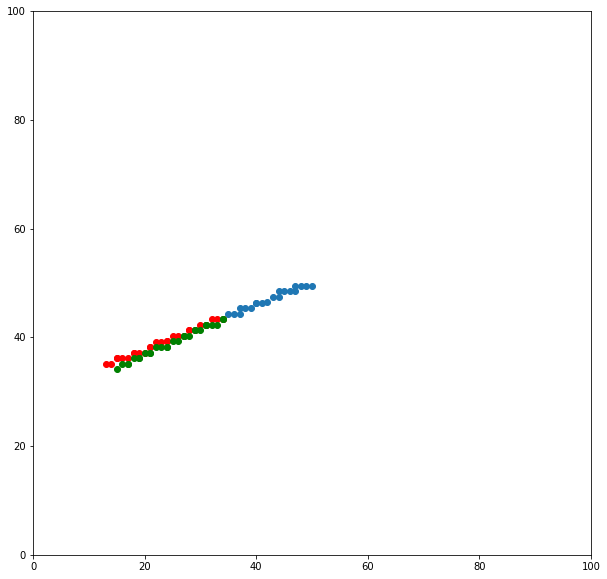

Input:  [[50, 49.5], [49, 49.49], [48, 49.48], [47, 49.47], [47, 48.47], [46, 48.46], [45, 48.45], [44, 48.44], [44, 47.44], [43, 47.43], [42, 46.42], [41, 46.41], [40, 46.4], [40, 46.4], [39, 45.39], [38, 45.38], [37, 45.37], [37, 44.37], [36, 44.36], [35, 44.35]]
Preds:  [[34, 43.34], [34, 43.34], [33, 42.33], [32, 42.32], [31, 42.31], [31, 42.31], [30, 41.3], [29, 41.29], [29, 41.29], [28, 40.28], [27, 40.27], [27, 40.27], [26, 39.26], [25, 39.25], [24, 38.24], [24, 38.24], [23, 38.23], [22, 38.22], [21, 37.21], [21, 37.21], [20, 37.2], [19, 36.19], [19, 36.19], [18, 36.18], [17, 35.17], [17, 35.17], [16, 35.16], [15, 34.15]]
Truth:  [[34, 43.34], [33, 43.33], [32, 43.32], [31, 42.31], [31, 42.31], [30, 42.3], [29, 41.29], [28, 41.28], [28, 41.28], [27, 40.27], [26, 40.26], [25, 40.25], [24, 39.24], [24, 39.24], [23, 39.23], [22, 39.22], [21, 38.21], [21, 38.21], [20, 37.2], [19, 37.19], [18, 37.18], [18, 37.18], [17, 36.17], [16, 36.16], [15, 36.15], [15, 36.15], [14, 35.14], [13, 

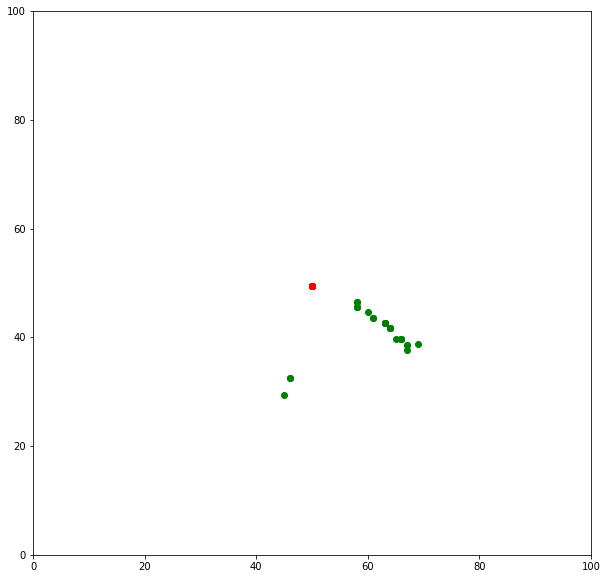

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
Preds:  [[58, 46.58], [58, 46.58], [58, 45.58], [58, 45.58], [58, 45.58], [46, 32.46], [46, 32.46], [60, 44.6], [61, 43.61], [61, 43.61], [45, 29.45], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [64, 41.64], [64, 41.64], [64, 41.64], [64, 41.64], [65, 39.65], [66, 39.66], [66, 39.66], [66, 39.66], [67, 38.67], [67, 38.67], [67, 37.67], [69, 38.69]]
Truth:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
80


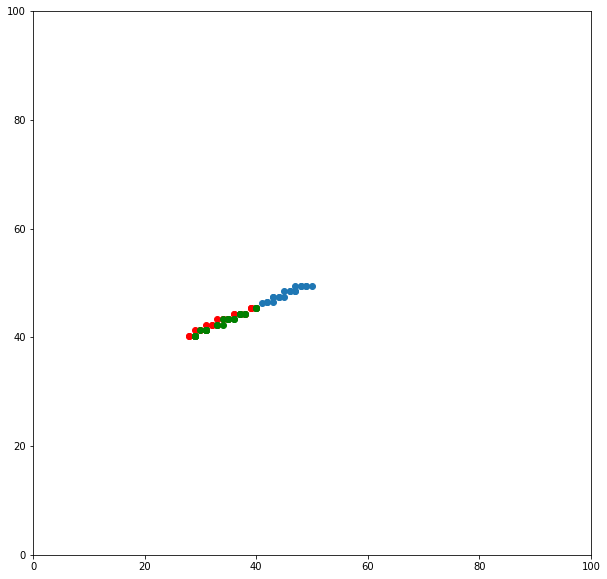

Input:  [[50, 49.5], [49, 49.49], [49, 49.49], [48, 49.48], [48, 49.48], [47, 49.47], [47, 48.47], [47, 48.47], [46, 48.46], [46, 48.46], [45, 48.45], [45, 47.45], [44, 47.44], [44, 47.44], [43, 47.43], [43, 47.43], [43, 46.43], [42, 46.42], [42, 46.42], [41, 46.41]]
Preds:  [[40, 45.4], [40, 45.4], [40, 45.4], [38, 44.38], [38, 44.38], [37, 44.37], [37, 44.37], [37, 44.37], [36, 43.36], [36, 43.36], [35, 43.35], [35, 43.35], [35, 43.35], [34, 43.34], [34, 42.34], [33, 42.33], [33, 42.33], [31, 41.31], [31, 41.31], [31, 41.31], [31, 41.31], [31, 41.31], [30, 41.3], [29, 40.29], [29, 40.29], [29, 40.29], [29, 40.29], [29, 40.29]]
Truth:  [[40, 45.4], [40, 45.4], [39, 45.39], [39, 45.39], [39, 45.39], [38, 44.38], [38, 44.38], [37, 44.37], [37, 44.37], [36, 44.36], [36, 44.36], [35, 43.35], [35, 43.35], [34, 43.34], [34, 43.34], [33, 43.33], [33, 42.33], [33, 42.33], [32, 42.32], [32, 42.32], [31, 42.31], [31, 41.31], [30, 41.3], [30, 41.3], [29, 41.29], [29, 40.29], [28, 40.28], [28, 40

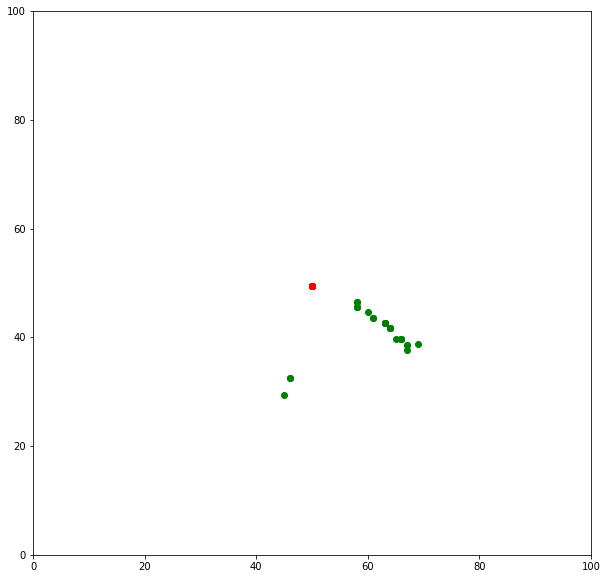

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
Preds:  [[58, 46.58], [58, 46.58], [58, 45.58], [58, 45.58], [58, 45.58], [46, 32.46], [46, 32.46], [60, 44.6], [61, 43.61], [61, 43.61], [45, 29.45], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [64, 41.64], [64, 41.64], [64, 41.64], [64, 41.64], [65, 39.65], [66, 39.66], [66, 39.66], [66, 39.66], [67, 38.67], [67, 38.67], [67, 37.67], [69, 38.69]]
Truth:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
82


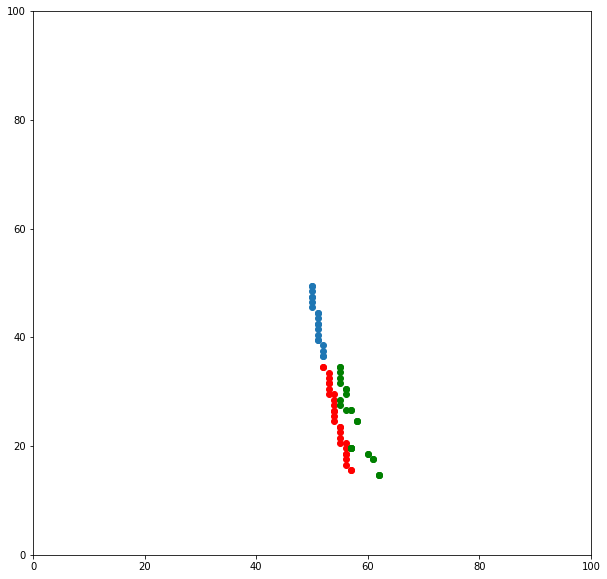

Input:  [[50, 49.5], [50, 49.5], [50, 48.5], [50, 47.5], [50, 47.5], [50, 46.5], [50, 45.5], [51, 44.51], [51, 44.51], [51, 43.51], [51, 42.51], [51, 42.51], [51, 41.51], [51, 40.51], [51, 39.51], [51, 39.51], [52, 38.52], [52, 37.52], [52, 36.52], [52, 36.52]]
Preds:  [[55, 34.55], [55, 34.55], [55, 33.55], [55, 32.55], [55, 31.55], [56, 30.56], [56, 30.56], [56, 29.56], [55, 28.55], [55, 27.55], [56, 26.56], [57, 26.57], [57, 26.57], [58, 24.58], [58, 24.58], [58, 24.58], [57, 19.57], [57, 19.57], [57, 19.57], [57, 19.57], [57, 19.57], [60, 18.6], [60, 18.6], [61, 17.61], [61, 17.61], [62, 14.62], [62, 14.62], [62, 14.62]]
Truth:  [[52, 34.52], [52, 34.52], [53, 33.53], [53, 32.53], [53, 31.53], [53, 31.53], [53, 30.53], [53, 29.53], [54, 29.54], [54, 28.54], [54, 27.54], [54, 26.54], [54, 26.54], [54, 25.54], [54, 24.54], [55, 23.55], [55, 23.55], [55, 22.55], [55, 21.55], [55, 20.55], [56, 20.56], [56, 19.56], [56, 18.56], [56, 18.56], [56, 17.56], [56, 16.56], [57, 15.57], [57, 15

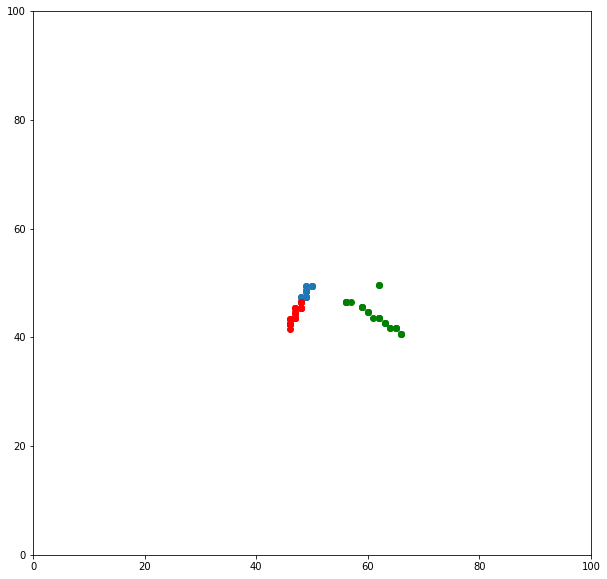

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [49, 49.49], [49, 49.49], [49, 48.49], [49, 48.49], [49, 48.49], [49, 48.49], [49, 48.49], [49, 48.49], [49, 47.49], [49, 47.49], [49, 47.49], [49, 47.49], [48, 47.48], [48, 47.48], [48, 46.48], [48, 46.48]]
Preds:  [[56, 46.56], [56, 46.56], [56, 46.56], [56, 46.56], [57, 46.57], [59, 45.59], [59, 45.59], [59, 45.59], [60, 44.6], [60, 44.6], [60, 44.6], [62, 49.62], [62, 49.62], [61, 43.61], [62, 43.62], [62, 43.62], [62, 43.62], [63, 42.63], [63, 42.63], [63, 42.63], [64, 41.64], [64, 41.64], [65, 41.65], [65, 41.65], [65, 41.65], [66, 40.66], [66, 40.66], [66, 40.66]]
Truth:  [[48, 46.48], [48, 46.48], [48, 46.48], [48, 45.48], [48, 45.48], [48, 45.48], [48, 45.48], [47, 45.47], [47, 45.47], [47, 45.47], [47, 44.47], [47, 44.47], [47, 44.47], [47, 44.47], [47, 44.47], [47, 43.47], [47, 43.47], [47, 43.47], [47, 43.47], [46, 43.46], [46, 43.46], [46, 42.46], [46, 42.46], [46, 42.46], [46, 42.46], [46, 42.46], [46, 42.46], [46, 

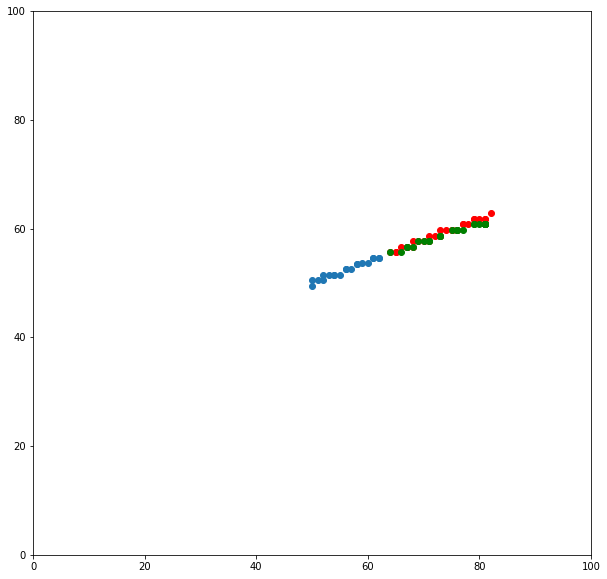

Input:  [[50, 49.5], [50, 50.5], [51, 50.51], [52, 50.52], [52, 51.52], [53, 51.53], [54, 51.54], [54, 51.54], [55, 51.55], [56, 52.56], [56, 52.56], [57, 52.57], [58, 53.58], [58, 53.58], [59, 53.59], [60, 53.6], [61, 54.61], [61, 54.61], [62, 54.62], [62, 54.62]]
Preds:  [[64, 55.64], [66, 55.66], [67, 56.67], [67, 56.67], [68, 56.68], [69, 57.69], [70, 57.7], [71, 57.71], [71, 57.71], [73, 58.73], [73, 58.73], [73, 58.73], [75, 59.75], [76, 59.76], [76, 59.76], [76, 59.76], [77, 59.77], [79, 60.79], [79, 60.79], [80, 60.8], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81], [81, 60.81]]
Truth:  [[64, 55.64], [65, 55.65], [65, 55.65], [66, 56.66], [67, 56.67], [67, 56.67], [68, 56.68], [68, 57.68], [69, 57.69], [70, 57.7], [71, 57.71], [71, 58.71], [72, 58.72], [73, 58.73], [73, 59.73], [74, 59.74], [75, 59.75], [75, 59.75], [76, 59.76], [77, 60.77], [77, 60.77], [78, 60.78], [79, 61.79], [79, 61.79], [80, 61.8], [81, 61.81], [81, 61.81], [82, 

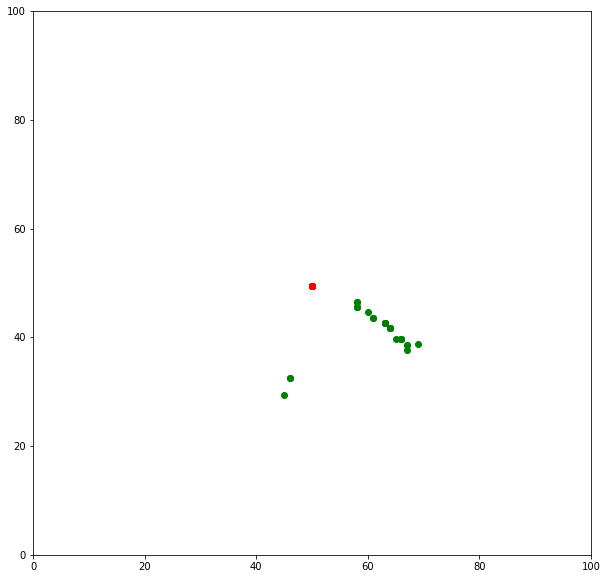

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
Preds:  [[58, 46.58], [58, 46.58], [58, 45.58], [58, 45.58], [58, 45.58], [46, 32.46], [46, 32.46], [60, 44.6], [61, 43.61], [61, 43.61], [45, 29.45], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [64, 41.64], [64, 41.64], [64, 41.64], [64, 41.64], [65, 39.65], [66, 39.66], [66, 39.66], [66, 39.66], [67, 38.67], [67, 38.67], [67, 37.67], [69, 38.69]]
Truth:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
86


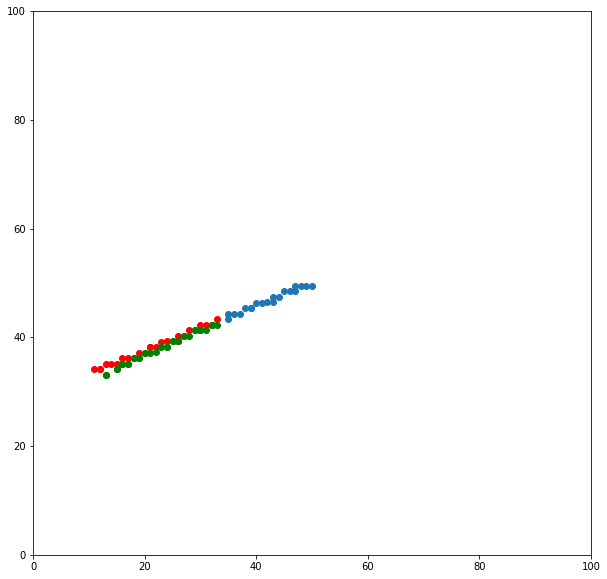

Input:  [[50, 49.5], [49, 49.49], [48, 49.48], [47, 49.47], [47, 48.47], [46, 48.46], [45, 48.45], [44, 47.44], [43, 47.43], [43, 46.43], [42, 46.42], [41, 46.41], [40, 46.4], [39, 45.39], [39, 45.39], [38, 45.38], [37, 44.37], [36, 44.36], [35, 44.35], [35, 43.35]]
Preds:  [[33, 42.33], [32, 42.32], [32, 42.32], [31, 41.31], [30, 41.3], [30, 41.3], [29, 41.29], [28, 40.28], [27, 40.27], [26, 39.26], [26, 39.26], [25, 39.25], [24, 38.24], [24, 38.24], [23, 38.23], [22, 37.22], [21, 37.21], [20, 37.2], [19, 36.19], [19, 36.19], [18, 36.18], [17, 35.17], [17, 35.17], [16, 35.16], [15, 34.15], [15, 34.15], [13, 33.13], [13, 33.13]]
Truth:  [[33, 43.33], [32, 42.32], [31, 42.31], [30, 42.3], [30, 41.3], [29, 41.29], [28, 41.28], [27, 40.27], [26, 40.26], [26, 39.26], [25, 39.25], [24, 39.24], [23, 39.23], [22, 38.22], [21, 38.21], [21, 38.21], [20, 37.2], [19, 37.19], [18, 36.18], [17, 36.17], [16, 36.16], [16, 35.16], [15, 35.15], [14, 35.14], [13, 35.13], [12, 34.12], [12, 34.12], [11, 3

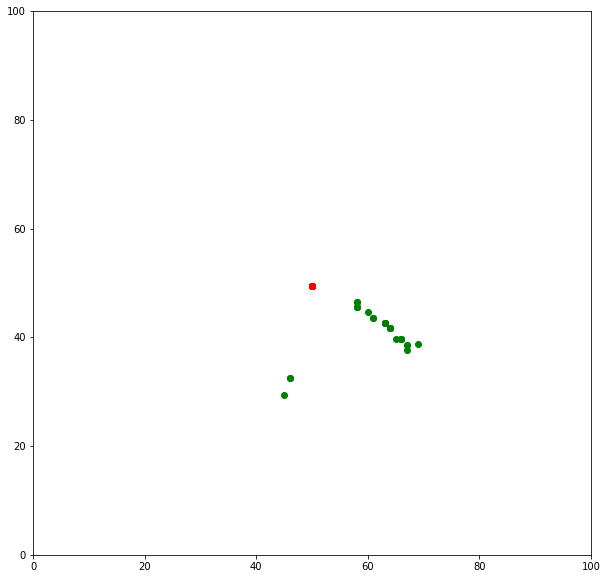

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
Preds:  [[58, 46.58], [58, 46.58], [58, 45.58], [58, 45.58], [58, 45.58], [46, 32.46], [46, 32.46], [60, 44.6], [61, 43.61], [61, 43.61], [45, 29.45], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [64, 41.64], [64, 41.64], [64, 41.64], [64, 41.64], [65, 39.65], [66, 39.66], [66, 39.66], [66, 39.66], [67, 38.67], [67, 38.67], [67, 37.67], [69, 38.69]]
Truth:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
88


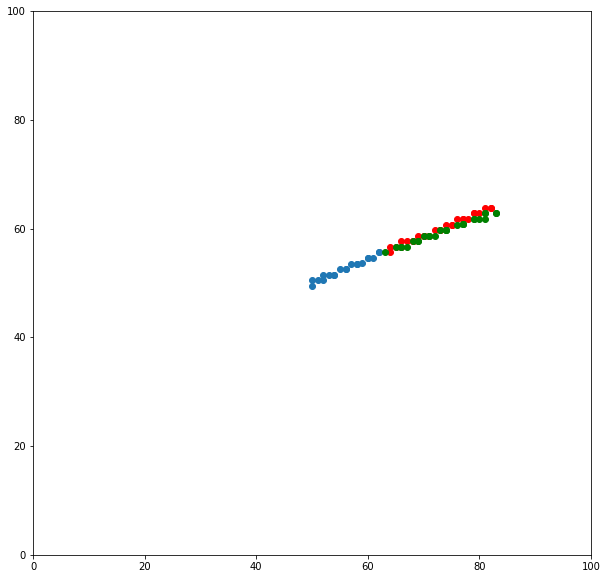

Input:  [[50, 49.5], [50, 50.5], [51, 50.51], [52, 50.52], [52, 51.52], [53, 51.53], [54, 51.54], [54, 51.54], [55, 52.55], [56, 52.56], [56, 52.56], [57, 53.57], [58, 53.58], [58, 53.58], [59, 53.59], [60, 54.6], [60, 54.6], [61, 54.61], [62, 55.62], [62, 55.62]]
Preds:  [[63, 55.63], [65, 56.65], [66, 56.66], [66, 56.66], [67, 56.67], [68, 57.68], [69, 57.69], [69, 57.69], [70, 58.7], [71, 58.71], [71, 58.71], [72, 58.72], [73, 59.73], [74, 59.74], [74, 59.74], [74, 59.74], [76, 60.76], [77, 60.77], [77, 60.77], [77, 60.77], [79, 61.79], [79, 61.79], [80, 61.8], [81, 62.81], [81, 62.81], [81, 61.81], [83, 62.83], [83, 62.83]]
Truth:  [[64, 55.64], [64, 56.64], [65, 56.65], [66, 56.66], [66, 57.66], [67, 57.67], [68, 57.68], [68, 57.68], [69, 58.69], [70, 58.7], [70, 58.7], [71, 58.71], [72, 59.72], [73, 59.73], [73, 59.73], [74, 60.74], [75, 60.75], [75, 60.75], [76, 61.76], [77, 61.77], [77, 61.77], [78, 61.78], [79, 62.79], [79, 62.79], [80, 62.8], [81, 63.81], [82, 63.82], [82, 63

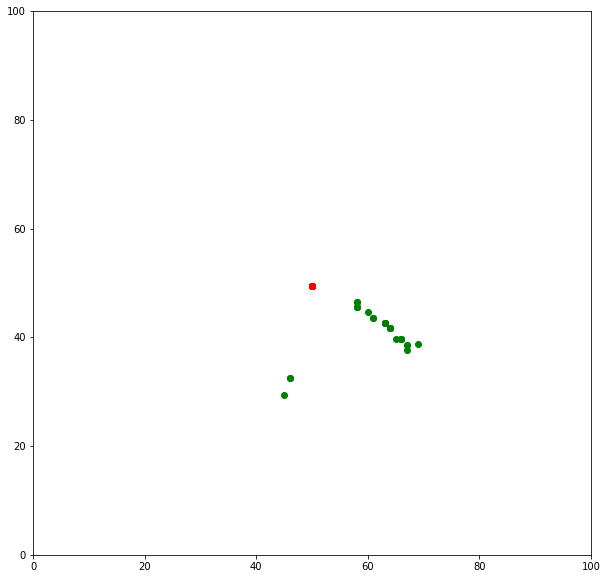

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
Preds:  [[58, 46.58], [58, 46.58], [58, 45.58], [58, 45.58], [58, 45.58], [46, 32.46], [46, 32.46], [60, 44.6], [61, 43.61], [61, 43.61], [45, 29.45], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [64, 41.64], [64, 41.64], [64, 41.64], [64, 41.64], [65, 39.65], [66, 39.66], [66, 39.66], [66, 39.66], [67, 38.67], [67, 38.67], [67, 37.67], [69, 38.69]]
Truth:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
90


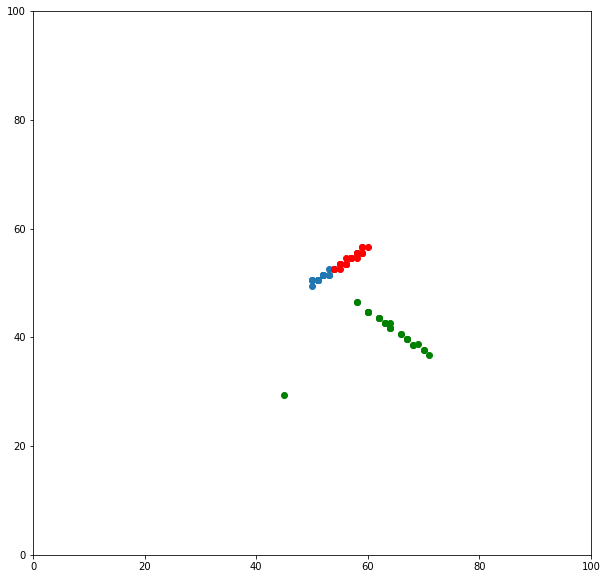

Input:  [[50, 49.5], [50, 50.5], [50, 50.5], [50, 50.5], [51, 50.51], [51, 50.51], [51, 50.51], [51, 50.51], [51, 50.51], [52, 51.52], [52, 51.52], [52, 51.52], [52, 51.52], [52, 51.52], [53, 51.53], [53, 51.53], [53, 51.53], [53, 52.53], [54, 52.54], [54, 52.54]]
Preds:  [[58, 46.58], [58, 46.58], [60, 44.6], [60, 44.6], [60, 44.6], [60, 44.6], [45, 29.45], [62, 43.62], [62, 43.62], [62, 43.62], [63, 42.63], [63, 42.63], [63, 42.63], [64, 42.64], [64, 41.64], [64, 41.64], [64, 41.64], [66, 40.66], [66, 40.66], [67, 39.67], [67, 39.67], [67, 39.67], [68, 38.68], [68, 38.68], [69, 38.69], [70, 37.7], [70, 37.7], [71, 36.71]]
Truth:  [[54, 52.54], [54, 52.54], [55, 52.55], [55, 53.55], [55, 53.55], [55, 53.55], [55, 53.55], [56, 53.56], [56, 53.56], [56, 53.56], [56, 53.56], [56, 54.56], [57, 54.57], [57, 54.57], [57, 54.57], [57, 54.57], [57, 54.57], [58, 54.58], [58, 55.58], [58, 55.58], [58, 55.58], [58, 55.58], [59, 55.59], [59, 55.59], [59, 55.59], [59, 56.59], [59, 56.59], [60, 56.

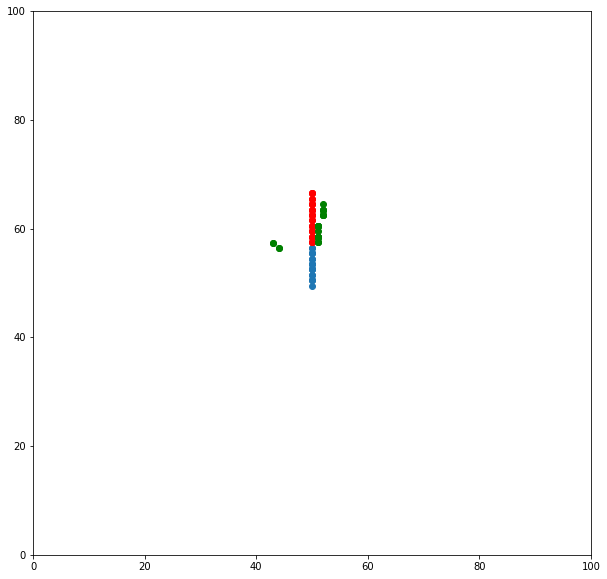

Input:  [[50, 49.5], [50, 50.5], [50, 50.5], [50, 50.5], [50, 51.5], [50, 51.5], [50, 52.5], [50, 52.5], [50, 52.5], [50, 52.5], [50, 53.5], [50, 53.5], [50, 53.5], [50, 54.5], [50, 54.5], [50, 55.5], [50, 55.5], [50, 55.5], [50, 56.5], [50, 56.5]]
Preds:  [[51, 58.51], [51, 57.51], [51, 57.51], [51, 57.51], [51, 58.51], [51, 58.51], [51, 58.51], [51, 58.51], [51, 58.51], [51, 59.51], [44, 56.44], [44, 56.44], [51, 60.51], [51, 60.51], [51, 60.51], [51, 60.51], [51, 60.51], [43, 57.43], [43, 57.43], [52, 62.52], [52, 62.52], [52, 62.52], [52, 62.52], [52, 63.52], [52, 63.52], [52, 63.52], [52, 63.52], [52, 64.52]]
Truth:  [[50, 57.5], [50, 57.5], [50, 57.5], [50, 58.5], [50, 58.5], [50, 58.5], [50, 59.5], [50, 59.5], [50, 59.5], [50, 60.5], [50, 60.5], [50, 60.5], [50, 61.5], [50, 61.5], [50, 62.5], [50, 62.5], [50, 62.5], [50, 63.5], [50, 63.5], [50, 63.5], [50, 64.5], [50, 64.5], [50, 64.5], [50, 65.5], [50, 65.5], [50, 66.5], [50, 66.5], [50, 66.5]]
92


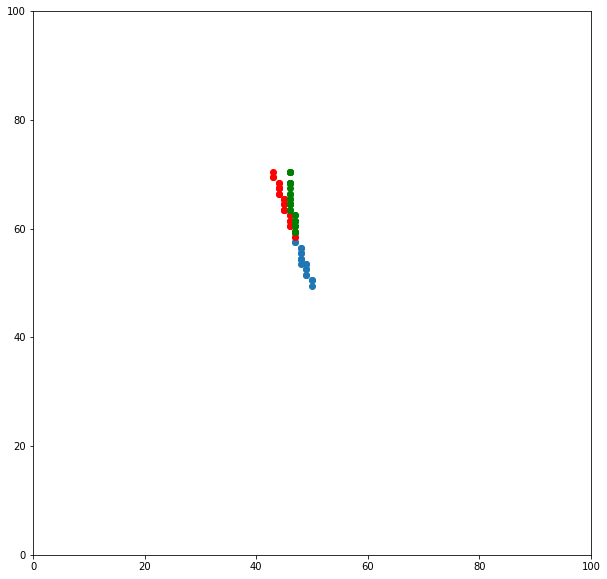

Input:  [[50, 49.5], [50, 50.5], [50, 50.5], [49, 51.49], [49, 51.49], [49, 52.49], [49, 52.49], [49, 53.49], [49, 53.49], [48, 53.48], [48, 54.48], [48, 54.48], [48, 54.48], [48, 55.48], [48, 55.48], [48, 56.48], [48, 56.48], [47, 57.47], [47, 57.47], [47, 58.47]]
Preds:  [[47, 59.47], [47, 59.47], [47, 60.47], [47, 60.47], [47, 61.47], [47, 61.47], [47, 61.47], [47, 62.47], [47, 62.47], [46, 63.46], [46, 63.46], [46, 64.46], [46, 64.46], [46, 64.46], [46, 64.46], [46, 65.46], [46, 65.46], [46, 66.46], [46, 66.46], [46, 67.46], [46, 68.46], [46, 68.46], [46, 68.46], [46, 68.46], [46, 70.46], [46, 70.46], [46, 70.46], [46, 70.46]]
Truth:  [[47, 58.47], [47, 59.47], [47, 59.47], [47, 59.47], [46, 60.46], [46, 60.46], [46, 61.46], [46, 61.46], [46, 62.46], [46, 62.46], [45, 63.45], [45, 63.45], [45, 63.45], [45, 64.45], [45, 64.45], [45, 65.45], [45, 65.45], [45, 65.45], [44, 66.44], [44, 66.44], [44, 67.44], [44, 67.44], [44, 67.44], [44, 68.44], [44, 68.44], [43, 69.43], [43, 69.43], [

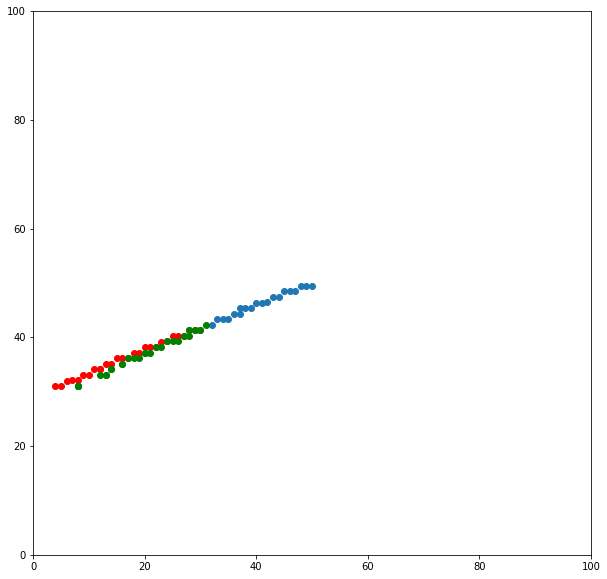

Input:  [[50, 49.5], [49, 49.49], [48, 49.48], [47, 48.47], [46, 48.46], [45, 48.45], [44, 47.44], [43, 47.43], [42, 46.42], [41, 46.41], [40, 46.4], [39, 45.39], [38, 45.38], [37, 45.37], [37, 44.37], [36, 44.36], [35, 43.35], [34, 43.34], [33, 43.33], [32, 42.32]]
Preds:  [[31, 42.31], [30, 41.3], [29, 41.29], [28, 41.28], [28, 40.28], [27, 40.27], [26, 39.26], [25, 39.25], [24, 39.24], [23, 38.23], [22, 38.22], [21, 37.21], [20, 37.2], [20, 37.2], [19, 36.19], [18, 36.18], [17, 36.17], [16, 35.16], [16, 35.16], [14, 34.14], [14, 34.14], [13, 33.13], [12, 33.12], [13, 33.13], [8, 31.08], [8, 31.08], [8, 31.08], [8, 31.08]]
Truth:  [[30, 41.3], [29, 41.29], [28, 41.28], [27, 40.27], [26, 40.26], [25, 40.25], [24, 39.24], [23, 39.23], [22, 38.22], [21, 38.21], [20, 38.2], [19, 37.19], [18, 37.18], [17, 36.17], [16, 36.16], [15, 36.15], [14, 35.14], [13, 35.13], [12, 34.12], [12, 34.12], [11, 34.11], [10, 33.1], [9, 33.09], [8, 32.08], [7, 32.07], [6, 32.06], [5, 31.05], [4, 31.04]]
94


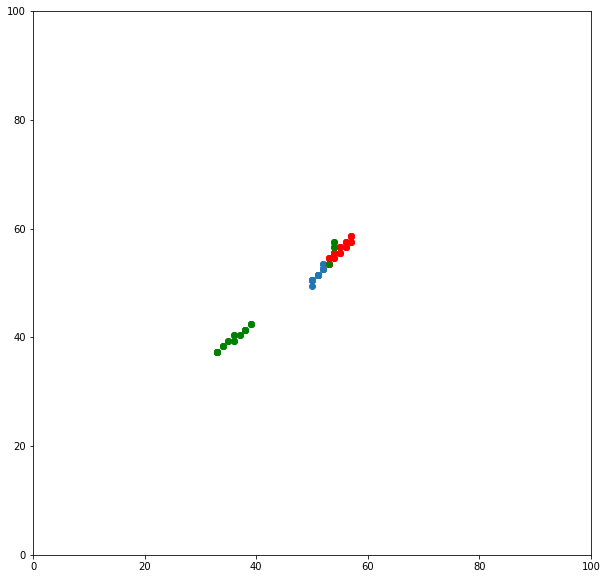

Input:  [[50, 49.5], [50, 50.5], [50, 50.5], [50, 50.5], [50, 50.5], [50, 50.5], [51, 51.51], [51, 51.51], [51, 51.51], [51, 51.51], [51, 51.51], [51, 51.51], [52, 52.52], [52, 52.52], [52, 52.52], [52, 52.52], [52, 52.52], [52, 53.52], [52, 53.52], [53, 53.53]]
Preds:  [[53, 53.53], [54, 56.54], [54, 56.54], [54, 57.54], [54, 57.54], [39, 42.39], [39, 42.39], [39, 42.39], [38, 41.38], [38, 41.38], [38, 41.38], [38, 41.38], [37, 40.37], [37, 40.37], [36, 40.36], [36, 40.36], [36, 39.36], [36, 39.36], [35, 39.35], [35, 39.35], [34, 38.34], [34, 38.34], [34, 38.34], [33, 37.33], [33, 37.33], [33, 37.33], [33, 37.33], [33, 37.33]]
Truth:  [[53, 53.53], [53, 53.53], [53, 54.53], [53, 54.53], [53, 54.53], [54, 54.54], [54, 54.54], [54, 55.54], [54, 55.54], [54, 55.54], [54, 55.54], [55, 55.55], [55, 55.55], [55, 55.55], [55, 56.55], [55, 56.55], [55, 56.55], [56, 56.56], [56, 56.56], [56, 56.56], [56, 57.56], [56, 57.56], [56, 57.56], [57, 57.57], [57, 57.57], [57, 58.57], [57, 58.57], [57,

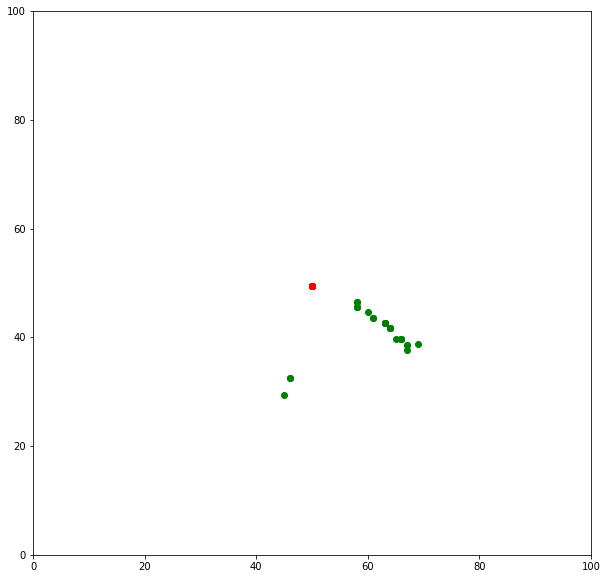

Input:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
Preds:  [[58, 46.58], [58, 46.58], [58, 45.58], [58, 45.58], [58, 45.58], [46, 32.46], [46, 32.46], [60, 44.6], [61, 43.61], [61, 43.61], [45, 29.45], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [63, 42.63], [64, 41.64], [64, 41.64], [64, 41.64], [64, 41.64], [65, 39.65], [66, 39.66], [66, 39.66], [66, 39.66], [67, 38.67], [67, 38.67], [67, 37.67], [69, 38.69]]
Truth:  [[50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5], [50, 49.5]]
96


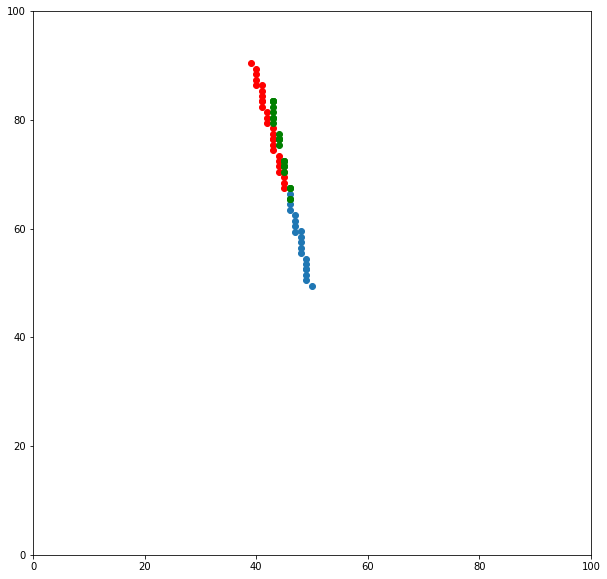

Input:  [[50, 49.5], [49, 50.49], [49, 51.49], [49, 52.49], [49, 52.49], [49, 53.49], [49, 54.49], [48, 55.48], [48, 56.48], [48, 57.48], [48, 58.48], [47, 59.47], [48, 59.48], [47, 60.47], [47, 61.47], [47, 62.47], [46, 63.46], [46, 64.46], [46, 65.46], [46, 66.46]]
Preds:  [[46, 65.46], [46, 65.46], [46, 67.46], [46, 67.46], [46, 67.46], [45, 70.45], [45, 71.45], [45, 71.45], [45, 71.45], [45, 72.45], [45, 72.45], [45, 72.45], [44, 75.44], [44, 76.44], [44, 76.44], [44, 76.44], [44, 76.44], [44, 77.44], [43, 79.43], [43, 80.43], [43, 80.43], [43, 80.43], [43, 81.43], [43, 82.43], [43, 83.43], [43, 83.43], [43, 83.43], [43, 83.43]]
Truth:  [[45, 67.45], [45, 68.45], [45, 69.45], [45, 70.45], [44, 70.44], [44, 71.44], [44, 72.44], [44, 73.44], [43, 74.43], [43, 75.43], [43, 76.43], [43, 76.43], [43, 77.43], [43, 78.43], [42, 79.42], [42, 80.42], [42, 81.42], [41, 82.41], [41, 83.41], [41, 83.41], [41, 84.41], [41, 85.41], [41, 86.41], [40, 86.4], [40, 87.4], [40, 88.4], [40, 89.4], [39

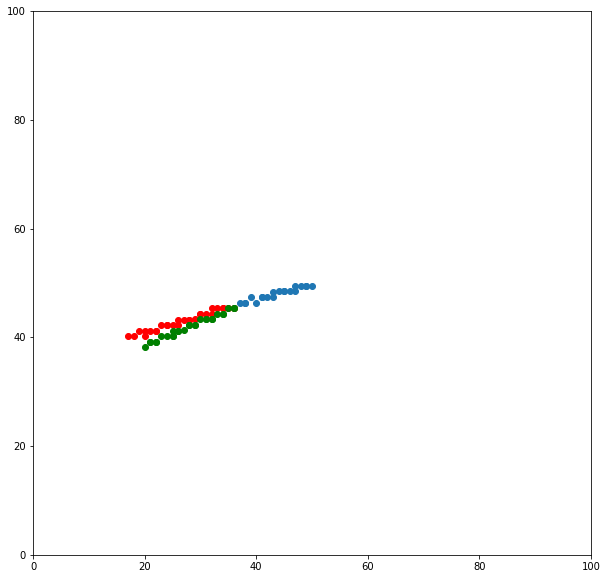

Input:  [[50, 49.5], [49, 49.49], [49, 49.49], [48, 49.48], [47, 49.47], [47, 48.47], [46, 48.46], [45, 48.45], [45, 48.45], [44, 48.44], [43, 48.43], [43, 47.43], [42, 47.42], [41, 47.41], [41, 47.41], [40, 46.4], [39, 47.39], [38, 46.38], [38, 46.38], [37, 46.37]]
Preds:  [[36, 45.36], [36, 45.36], [35, 45.35], [34, 44.34], [34, 44.34], [33, 44.33], [32, 43.32], [32, 43.32], [31, 43.31], [31, 43.31], [30, 43.3], [29, 42.29], [29, 42.29], [28, 42.28], [28, 42.28], [27, 41.27], [26, 41.26], [26, 41.26], [25, 41.25], [25, 40.25], [25, 40.25], [24, 40.24], [23, 40.23], [22, 39.22], [22, 39.22], [21, 39.21], [21, 39.21], [20, 38.2]]
Truth:  [[36, 45.36], [35, 45.35], [34, 45.34], [34, 45.34], [33, 45.33], [32, 45.32], [32, 44.32], [31, 44.31], [30, 44.3], [30, 44.3], [29, 43.29], [28, 43.28], [28, 43.28], [27, 43.27], [26, 43.26], [26, 42.26], [25, 42.25], [24, 42.24], [24, 42.24], [23, 42.23], [22, 41.22], [22, 41.22], [21, 41.21], [20, 41.2], [20, 40.2], [19, 41.19], [18, 40.18], [17, 4

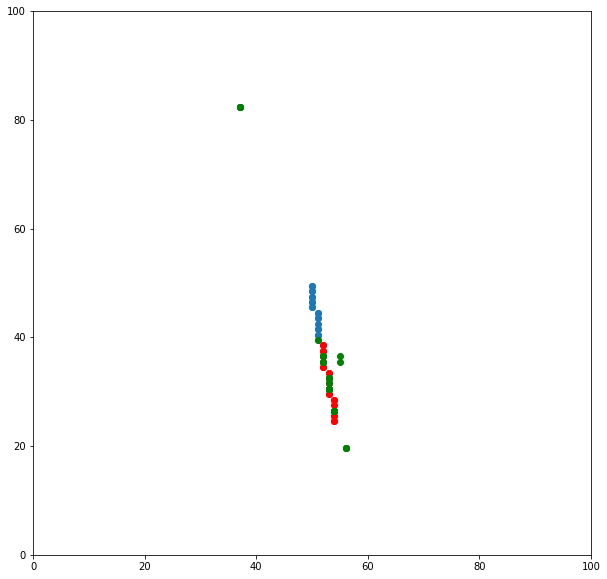

Input:  [[50, 49.5], [50, 49.5], [50, 48.5], [50, 48.5], [50, 47.5], [50, 47.5], [50, 46.5], [50, 46.5], [50, 45.5], [50, 45.5], [51, 44.51], [51, 44.51], [51, 43.51], [51, 43.51], [51, 42.51], [51, 41.51], [51, 41.51], [51, 40.51], [51, 40.51], [51, 39.51]]
Preds:  [[52, 36.52], [52, 36.52], [51, 39.51], [52, 35.52], [52, 35.52], [55, 36.55], [55, 35.55], [53, 32.53], [53, 32.53], [53, 32.53], [53, 31.53], [53, 30.53], [53, 30.53], [53, 30.53], [53, 30.53], [53, 30.53], [54, 26.54], [54, 26.54], [54, 26.54], [54, 26.54], [54, 26.54], [37, 82.37], [37, 82.37], [37, 82.37], [37, 82.37], [56, 19.56], [56, 19.56], [56, 19.56]]
Truth:  [[52, 38.52], [52, 38.52], [52, 37.52], [52, 37.52], [52, 36.52], [52, 36.52], [52, 35.52], [52, 34.52], [52, 34.52], [53, 33.53], [53, 33.53], [53, 32.53], [53, 32.53], [53, 31.53], [53, 31.53], [53, 30.53], [53, 30.53], [53, 29.53], [53, 29.53], [54, 28.54], [54, 28.54], [54, 27.54], [54, 26.54], [54, 26.54], [54, 25.54], [54, 25.54], [54, 24.54], [54, 24.

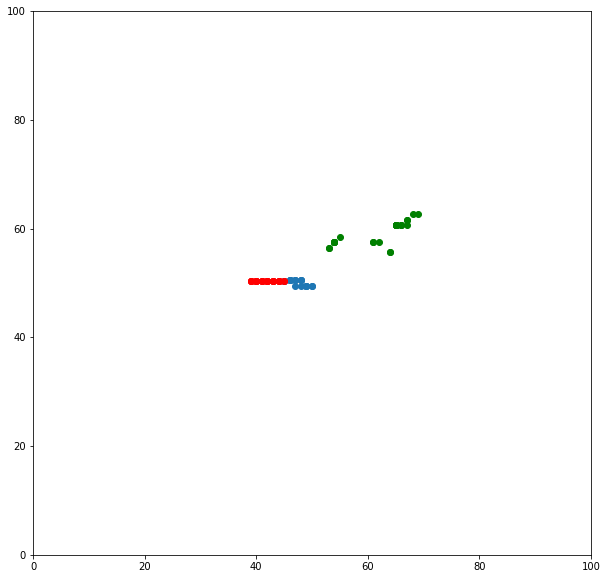

Input:  [[50, 49.5], [50, 49.5], [49, 49.49], [49, 49.49], [49, 49.49], [49, 49.49], [48, 49.48], [48, 50.48], [48, 50.48], [48, 50.48], [47, 49.47], [47, 50.47], [47, 50.47], [47, 50.47], [46, 50.46], [46, 50.46], [46, 50.46], [46, 50.46], [45, 50.45], [45, 50.45]]
Preds:  [[62, 57.62], [61, 57.61], [61, 57.61], [64, 55.64], [64, 55.64], [53, 56.53], [53, 56.53], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [54, 57.54], [55, 58.55], [67, 60.67], [65, 60.65], [65, 60.65], [65, 60.65], [65, 60.65], [65, 60.65], [65, 60.65], [65, 60.65], [66, 60.66], [66, 60.66], [66, 60.66], [67, 61.67], [67, 61.67], [68, 62.68], [69, 62.69]]
Truth:  [[45, 50.45], [45, 50.45], [44, 50.44], [44, 50.44], [44, 50.44], [44, 50.44], [43, 50.43], [43, 50.43], [43, 50.43], [43, 50.43], [42, 50.42], [42, 50.42], [42, 50.42], [42, 50.42], [42, 50.42], [41, 50.41], [41, 50.41], [41, 50.41], [41, 50.41], [40, 50.4], [40, 50.4], [40, 50.4], [40, 50.4], [40, 50.4], [39, 50.39], [39, 50.39], [39, 50.39], [39, 

In [130]:
vis_trajectory_scatter(inputs_list, target_list, preds_list)

In [103]:
inputs_list

[[[4950],
  [4949],
  [4948],
  [4948],
  [4947],
  [4846],
  [4846],
  [4845],
  [4844],
  [4743],
  [4743],
  [4742],
  [4641],
  [4740],
  [4640],
  [4639],
  [4638],
  [4538],
  [4537],
  [4536]],
 [[4950],
  [5050],
  [5150],
  [5249],
  [5349],
  [5449],
  [5548],
  [5648],
  [5748],
  [5848],
  [5848],
  [5947],
  [6047],
  [6147],
  [6247],
  [6346],
  [6446],
  [6546],
  [6646],
  [6745]],
 [[4950],
  [5050],
  [5049],
  [5149],
  [5149],
  [5249],
  [5249],
  [5349],
  [5348],
  [5448],
  [5448],
  [5548],
  [5548],
  [5548],
  [5647],
  [5647],
  [5747],
  [5747],
  [5747],
  [5847]],
 [[4950],
  [4949],
  [4949],
  [4948],
  [4948],
  [4847],
  [4847],
  [4846],
  [4846],
  [4845],
  [4745],
  [4744],
  [4744],
  [4743],
  [4743],
  [4642],
  [4642],
  [4641],
  [4641],
  [4640]],
 [[4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [4950],
  [495